In [223]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

In [154]:
# Load the data into a DataFrame
df = pd.read_csv('acr2024.csv')

# Data Cleaning and Preprocessing

In [155]:
# Check for missing values
missing_values = df.isnull().sum()
print(missing_values)

# For simplicity, let's fill missing values with the mean of the column
# This is a placeholder; more sophisticated methods can be used based on the context
for column in df.columns:
    if df[column].isnull().sum() > 0:
        if df[column].dtype == 'object':
            df[column].fillna(df[column].mode()[0], inplace=True)
        else:
            df[column].fillna(df[column].mean(), inplace=True)

year                 0
uslc                 0
ussc                 0
intd                 0
em                   0
All US Bonds         0
Hi-Yield US Bonds    0
Int'l Bonds          0
Cash (T-Bill)        0
REIT                 0
Gold                 0
CPIAUCSL             0
T10Y2Y               0
MORTGAGE30US         0
FEDFUNDS             0
UNRATE               0
T10Y3M               0
M2SL                 0
GDP                  0
dtype: int64


In [156]:
# Check for duplicates 
print(df.duplicated().sum())

# Remove duplicates
initial_shape = df.shape
print('Initial shape:', initial_shape)
df.drop_duplicates(inplace=True)
print('Shape after removing duplicates:', df.shape)

0
Initial shape: (40, 19)
Shape after removing duplicates: (40, 19)


In [157]:
# Print data types
print(df.dtypes)

year                   int64
uslc                  object
ussc                  object
intd                  object
em                    object
All US Bonds          object
Hi-Yield US Bonds     object
Int'l Bonds           object
Cash (T-Bill)         object
REIT                  object
Gold                  object
CPIAUCSL             float64
T10Y2Y               float64
MORTGAGE30US         float64
FEDFUNDS             float64
UNRATE               float64
T10Y3M               float64
M2SL                 float64
GDP                  float64
dtype: object


***Most of the columns are of object data type, which means they contain string values. We'll need to convert the percentage columns to float for analysis.***

In [158]:
# Print first few rows of the dataframe
print(df.head())

   year    uslc     ussc    intd      em All US Bonds Hi-Yield US Bonds  \
0  1985  26.40%   26.20%  50.30%  22.90%       17.60%            17.50%   
1  1986  16.80%    4.50%  67.50%  10.40%       13.90%            15.60%   
2  1987   0.30%  -12.70%  19.30%   9.30%       -2.80%            -1.70%   
3  1988  11.30%   19.70%  22.80%  33.90%        2.80%             8.80%   
4  1989  25.50%   11.00%   5.60%  56.90%        8.60%            -2.60%   

  Int'l Bonds Cash (T-Bill)    REIT     Gold  CPIAUCSL  T10Y2Y  MORTGAGE30US  \
0       7.00%         3.80%  14.60%    1.70%     105.5    1.53         13.14   
1      10.10%         5.00%  17.70%   17.90%     109.5    1.02         11.09   
2       4.50%         1.30%  -7.80%   19.00%     110.8    0.88          9.29   
3       4.40%         2.10%   8.60%  -19.60%     115.6    1.06         10.61   
4      -0.60%         3.70%   3.90%   -6.80%     120.7    0.00         10.77   

   FEDFUNDS  UNRATE  T10Y3M    M2SL       GDP  
0      8.38     7.3 

***The first few rows give a glimpse of the data, showing various economic indicators and asset class returns over time.***

In [159]:
# Convert percentage columns to float
pct_cols = ['uslc', 'ussc', 'intd', 'em', 'All US Bonds', 'Hi-Yield US Bonds', "Int'l Bonds", 'Cash (T-Bill)', 'REIT', 'Gold']

for col in pct_cols:
    df[col] = df[col].str.rstrip('%').astype('float') / 100

print(df.dtypes)

year                   int64
uslc                 float64
ussc                 float64
intd                 float64
em                   float64
All US Bonds         float64
Hi-Yield US Bonds    float64
Int'l Bonds          float64
Cash (T-Bill)        float64
REIT                 float64
Gold                 float64
CPIAUCSL             float64
T10Y2Y               float64
MORTGAGE30US         float64
FEDFUNDS             float64
UNRATE               float64
T10Y3M               float64
M2SL                 float64
GDP                  float64
dtype: object


**The code successfully converted the percentage columns to float data type for analysis.**

In [160]:
#Descriptive statistics for each column
print(df.describe())

              year       uslc       ussc       intd         em  All US Bonds  \
count    40.000000  40.000000  40.000000  40.000000  40.000000     40.000000   
mean   2004.500000   0.096950   0.089675   0.073450   0.107050      0.030025   
std      11.690452   0.165198   0.178874   0.211095   0.283892      0.064544   
min    1985.000000  -0.370000  -0.361000  -0.413000  -0.528000     -0.190000   
25%    1994.750000   0.005250  -0.033750  -0.022750  -0.097250      0.001500   
50%    2004.500000   0.128500   0.133500   0.076000   0.094000      0.028000   
75%    2014.250000   0.224000   0.197500   0.195500   0.266500      0.064000   
max    2024.000000   0.340000   0.431000   0.675000   0.715000      0.176000   

       Hi-Yield US Bonds  Int'l Bonds  Cash (T-Bill)       REIT       Gold  \
count          40.000000    40.000000      40.000000  40.000000  40.000000   
mean            0.047975     0.026700       0.003925   0.080125   0.028700   
std             0.104173     0.058005       0

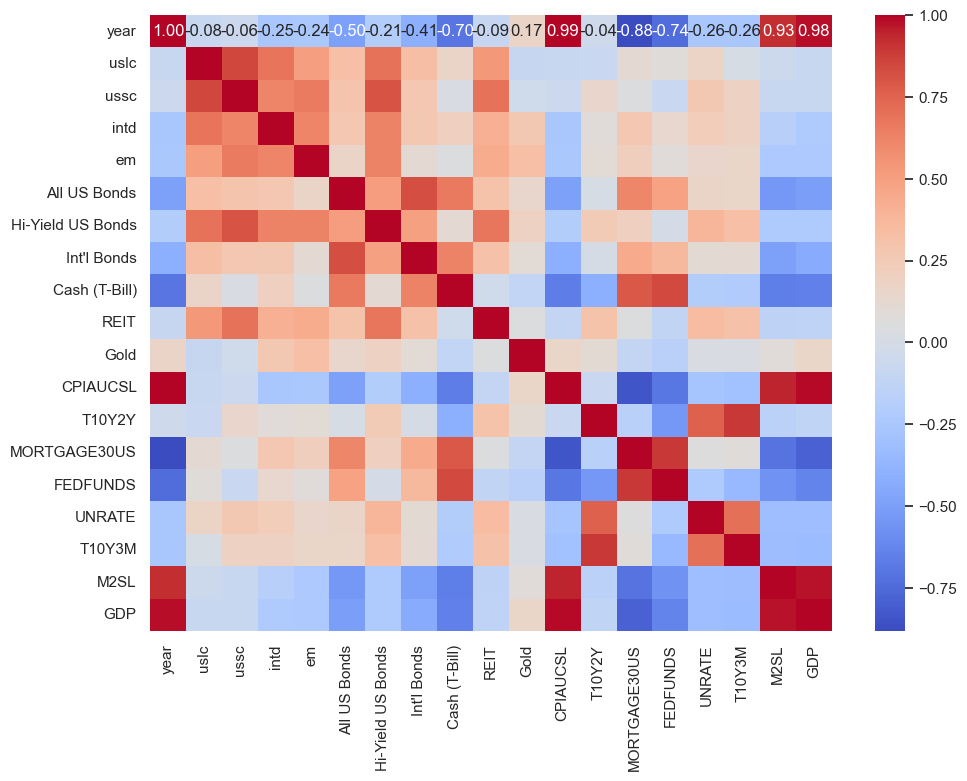

In [161]:
# Correlation matrix and heatmap
corr = df.corr()
sns.set(rc={'figure.figsize':(11,8)})
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.2f')
plt.show()

***The heatmap shows some interesting correlations, such as a strong positive correlation between GDP and M2SL (money supply). There are also notable correlations between interest rates (FEDFUNDS, MORTGAGE30US) and bond returns.***

***To further explore the data, we could create additional visualizations like line plots to show trends over time, or scatter plots to examine relationships between specific variables. We should also consider any data transformations or feature engineering that could help with modeling in later stages***

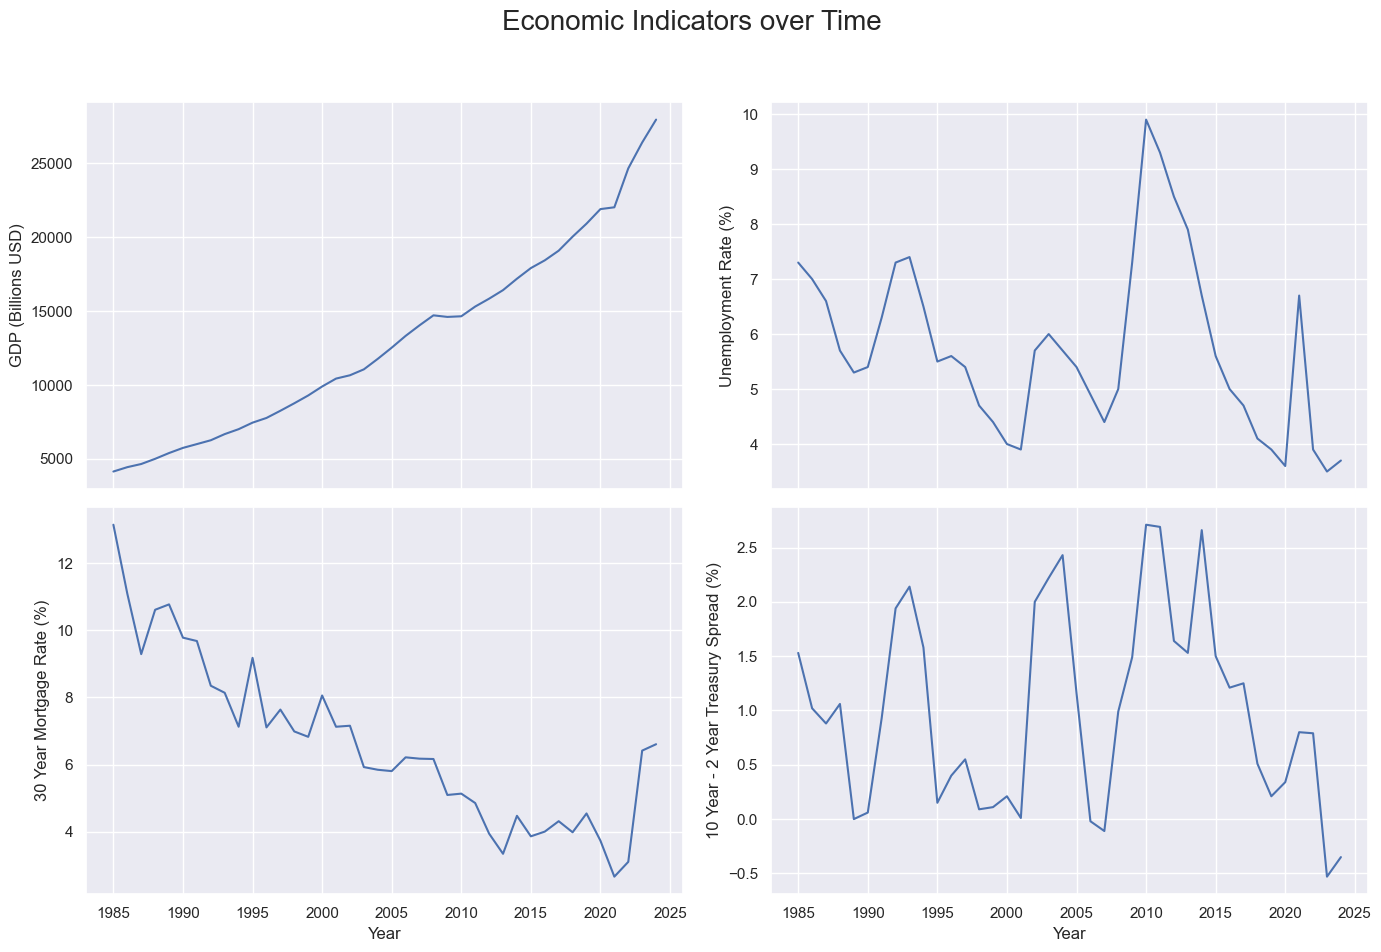

In [162]:
fig, axes = plt.subplots(2, 2, figsize=(14,10), sharex=True)

cols = ['GDP', 'UNRATE', 'MORTGAGE30US', 'T10Y2Y'] 
labels = ['GDP (Billions USD)', 'Unemployment Rate (%)',
          '30 Year Mortgage Rate (%)', '10 Year - 2 Year Treasury Spread (%)']

for ax, col, label in zip(axes.flatten(), cols, labels):
    ax.plot(df['year'], df[col])
    ax.set_ylabel(label)
    
axes[1,0].set_xlabel('Year') 
axes[1,1].set_xlabel('Year')

fig.suptitle('Economic Indicators over Time', size=20)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

***These line plots show the trends in GDP, unemployment rate, 30-year mortgage rate, and the 10-year/2-year Treasury spread. This helps provide a quick contextual snapshot on the overall economic conditions during the time period covered by the dataset***

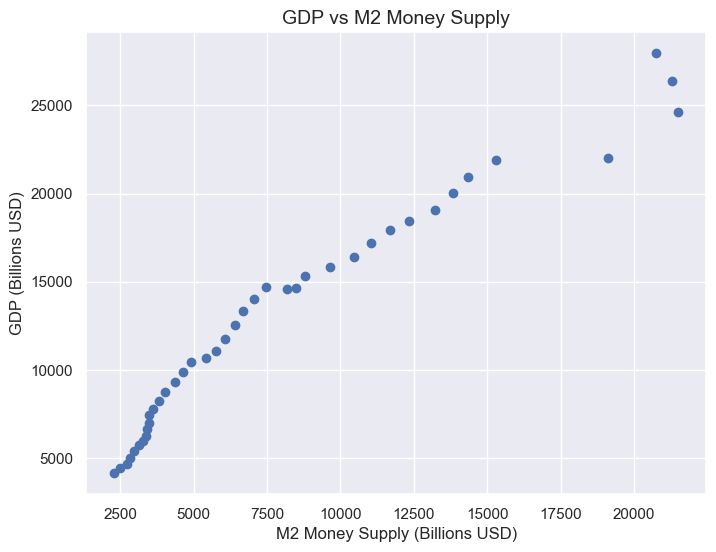

In [163]:
plt.figure(figsize=(8,6))
plt.scatter(df['M2SL'], df['GDP'])
plt.xlabel('M2 Money Supply (Billions USD)')
plt.ylabel('GDP (Billions USD)')
plt.title('GDP vs M2 Money Supply', size=14)
plt.show()

**This scatter plot illustrates the strong positive relationship between GDP and the M2 money supply, which was also evident in the correlation matrix.**

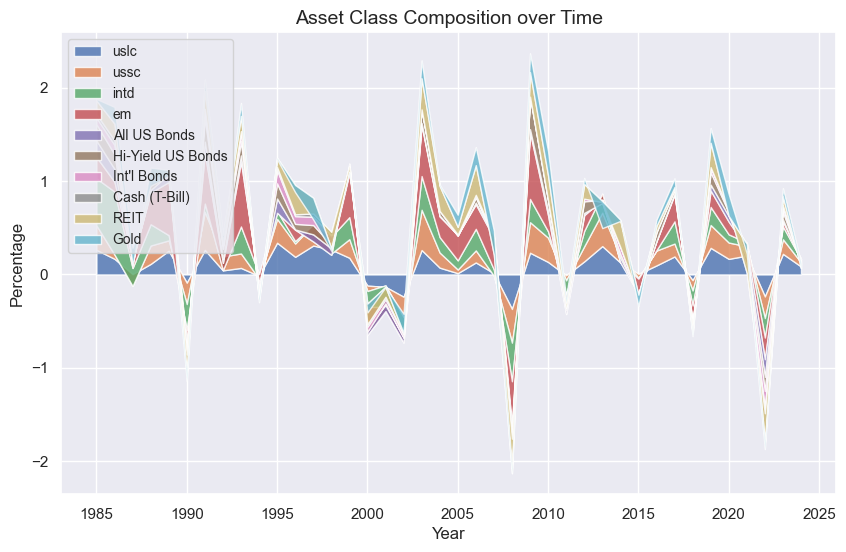

In [164]:
# Stacked area chart of asset class composition over time
asset_cols = ['uslc', 'ussc', 'intd', 'em', 'All US Bonds', 'Hi-Yield US Bonds', 
              "Int'l Bonds", 'Cash (T-Bill)', 'REIT', 'Gold']

plt.figure(figsize=(10,6))
plt.stackplot(df['year'], df[asset_cols].T, labels=asset_cols, alpha=0.8)
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.title('Asset Class Composition over Time', size=14)
plt.legend(loc='upper left', fontsize=10)
plt.show()

**This stacked area chart showing the composition of the different asset classes (stocks, bonds, real estate, etc.) over time. This would give a sense of how the relative importance of each asset class has changed.**

In [165]:
# Check for outliers using IQR method
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

outliers = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any()
print('Columns with outliers:\n', outliers[outliers])

Columns with outliers:
 uslc                 True
intd                 True
All US Bonds         True
Hi-Yield US Bonds    True
Int'l Bonds          True
Cash (T-Bill)        True
REIT                 True
UNRATE               True
dtype: bool


**The code identified several columns with outliers using the IQR method. These outliers could potentially impact the analysis, so we may need to investigate further and consider handling them through winsorization or other techniques.**

**These lagged variables could be useful for capturing time-dependent relationships in the data.**

In [166]:
# Create interaction terms
df['gdp_m2'] = df['GDP'] * df['M2SL'] 
df['unemp_ffr'] = df['UNRATE'] * df['FEDFUNDS']

print('\nFirst few rows with interaction terms:') 
print(df.head())


First few rows with interaction terms:
   year   uslc   ussc   intd     em  All US Bonds  Hi-Yield US Bonds  \
0  1985  0.264  0.262  0.503  0.229         0.176              0.175   
1  1986  0.168  0.045  0.675  0.104         0.139              0.156   
2  1987  0.003 -0.127  0.193  0.093        -0.028             -0.017   
3  1988  0.113  0.197  0.228  0.339         0.028              0.088   
4  1989  0.255  0.110  0.056  0.569         0.086             -0.026   

   Int'l Bonds  Cash (T-Bill)   REIT  ...  CPIAUCSL  T10Y2Y  MORTGAGE30US  \
0        0.070          0.038  0.146  ...     105.5    1.53         13.14   
1        0.101          0.050  0.177  ...     109.5    1.02         11.09   
2        0.045          0.013 -0.078  ...     110.8    0.88          9.29   
3        0.044          0.021  0.086  ...     115.6    1.06         10.61   
4       -0.006          0.037  0.039  ...     120.7    0.00         10.77   

   FEDFUNDS  UNRATE  T10Y3M    M2SL       GDP        gdp_m2  une

**Finally, the code created interaction terms between GDP and M2SL, and between unemployment rate and the federal funds rate:**

**Interaction terms can help capture non-linear relationships between variables.**

**The next step would be to split the data into training and testing sets, and start building baseline models to predict the target variable. We can then iterate on the models by incorporating the engineered features and tuning hyperparameters.**

In [167]:
# Display the first few rows of the dataframe
print(df.head())

   year   uslc   ussc   intd     em  All US Bonds  Hi-Yield US Bonds  \
0  1985  0.264  0.262  0.503  0.229         0.176              0.175   
1  1986  0.168  0.045  0.675  0.104         0.139              0.156   
2  1987  0.003 -0.127  0.193  0.093        -0.028             -0.017   
3  1988  0.113  0.197  0.228  0.339         0.028              0.088   
4  1989  0.255  0.110  0.056  0.569         0.086             -0.026   

   Int'l Bonds  Cash (T-Bill)   REIT  ...  CPIAUCSL  T10Y2Y  MORTGAGE30US  \
0        0.070          0.038  0.146  ...     105.5    1.53         13.14   
1        0.101          0.050  0.177  ...     109.5    1.02         11.09   
2        0.045          0.013 -0.078  ...     110.8    0.88          9.29   
3        0.044          0.021  0.086  ...     115.6    1.06         10.61   
4       -0.006          0.037  0.039  ...     120.7    0.00         10.77   

   FEDFUNDS  UNRATE  T10Y3M    M2SL       GDP        gdp_m2  unemp_ffr  
0      8.38     7.3    3.43  23

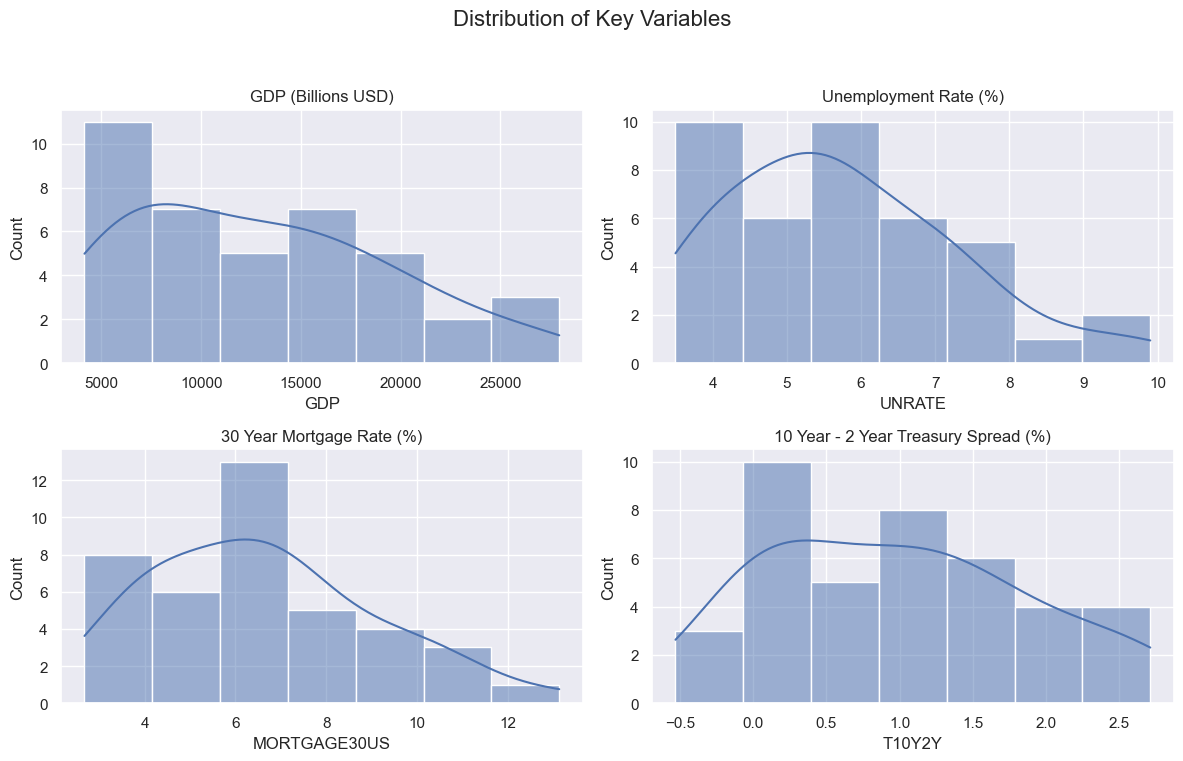

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

In [168]:
# Distribution plots for key variables
fig, axes = plt.subplots(2, 2, figsize=(12,8))

cols = ['GDP', 'UNRATE', 'MORTGAGE30US', 'T10Y2Y'] 
labels = ['GDP (Billions USD)', 'Unemployment Rate (%)',
          '30 Year Mortgage Rate (%)', '10 Year - 2 Year Treasury Spread (%)']

for ax, col, label in zip(axes.flatten(), cols, labels):
    sns.histplot(df[col], ax=ax, kde=True)
    ax.set_title(label)
    
fig.suptitle('Distribution of Key Variables', size=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Correlation heatmap
plt.figure(figsize=(12,10))


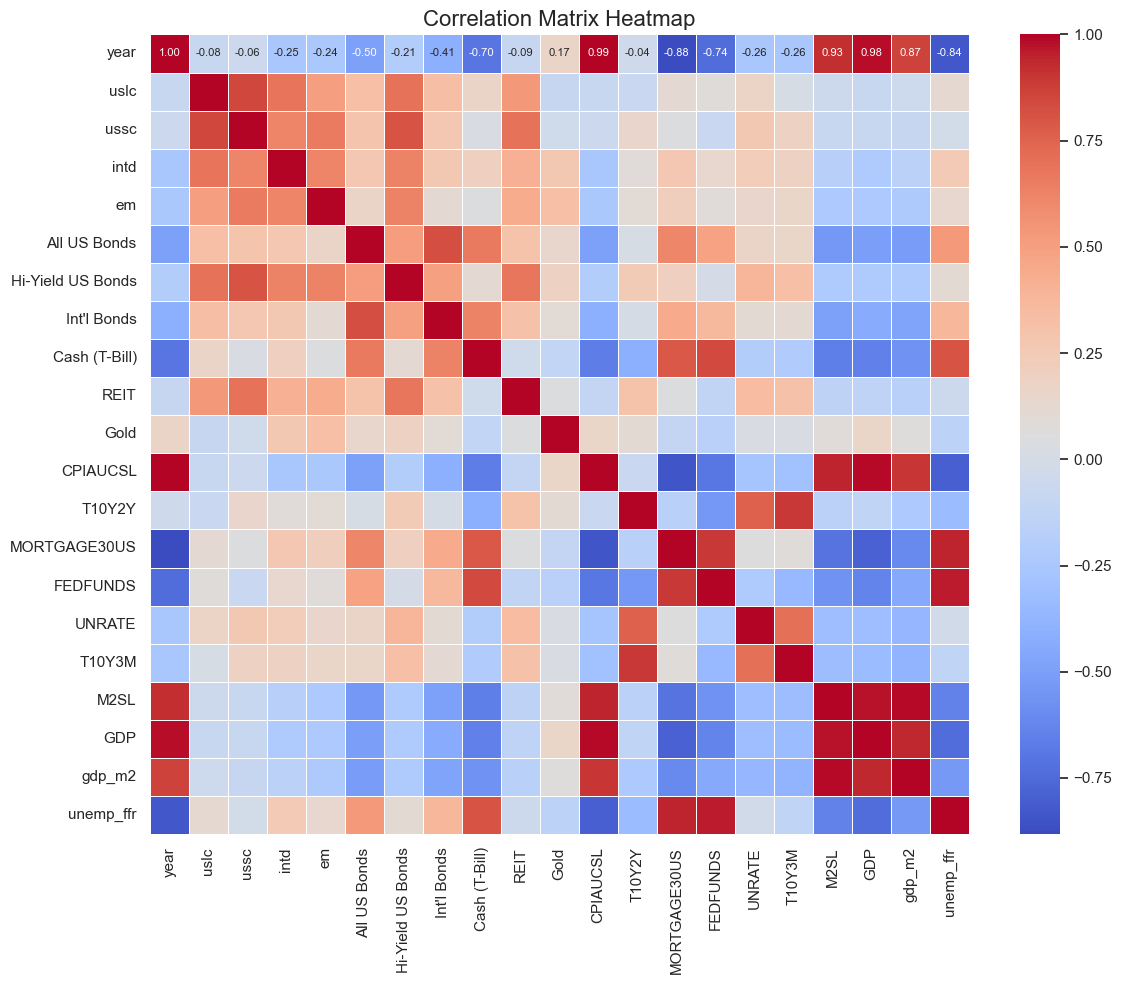

In [169]:
# Correlation heatmap
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f', 
            linewidths=0.5, annot_kws={'size':8})
plt.title('Correlation Matrix Heatmap', size=16)
plt.tight_layout()
plt.show()

**Additional EDA on the most relevant variables, I'll select a subset of columns that capture key economic indicators and asset class returns. Here are the steps I'll take:**

1. Create a new dataframe with the selected columns
2. Generate distribution plots for the key variables
3. Calculate a correlation matrix for the subset of columns
4. Visualize the correlation matrix as a heatmap
5. Analyze the plots and heatmap to identify patterns and relationships


**Let's start with the first step of creating a new dataframe:**

In [170]:
# Select key columns for EDA
key_cols = ['year', 'GDP', 'UNRATE', 'MORTGAGE30US', 'T10Y2Y', 'uslc', 'ussc', 'intd', 
            'em', 'All US Bonds', 'REIT', 'Gold']

df_key = df[key_cols]

print('New dataframe shape:', df_key.shape)
print('\nFirst few rows:')
print(df_key.head())

New dataframe shape: (40, 12)

First few rows:
   year       GDP  UNRATE  MORTGAGE30US  T10Y2Y   uslc   ussc   intd     em  \
0  1985  4148.551     7.3         13.14    1.53  0.264  0.262  0.503  0.229   
1  1986  4444.094     7.0         11.09    1.02  0.168  0.045  0.675  0.104   
2  1987  4657.627     6.6          9.29    0.88  0.003 -0.127  0.193  0.093   
3  1988  5007.994     5.7         10.61    1.06  0.113  0.197  0.228  0.339   
4  1989  5399.509     5.3         10.77    0.00  0.255  0.110  0.056  0.569   

   All US Bonds   REIT   Gold  
0         0.176  0.146  0.017  
1         0.139  0.177  0.179  
2        -0.028 -0.078  0.190  
3         0.028  0.086 -0.196  
4         0.086  0.039 -0.068  


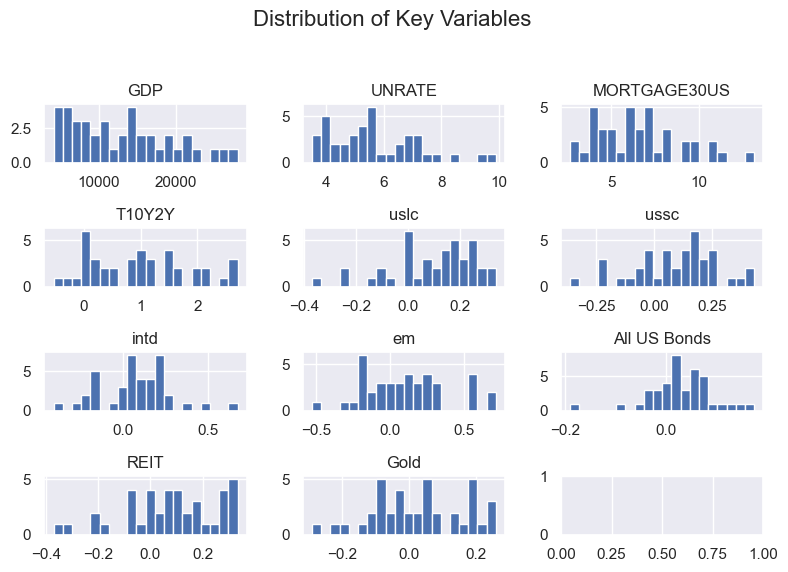

In [171]:
# Distribution plots for key variables
fig, axes = plt.subplots(4, 3, figsize=(8,6))

for ax, col in zip(axes.flatten(), df_key.columns[1:]):
    ax.hist(df_key[col], bins=20)
    ax.set_title(col)
    ax.set_xlabel('')
    
fig.suptitle('Distribution of Key Variables', size=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Some observations:**

- **GDP and the unemployment rate (UNRATE) appear to have a bimodal distribution, suggesting two distinct economic regimes during the time period**


- **Most of the asset class returns (uslc, ussc, intd, em, All US Bonds, REIT) are right-skewed, with a few years of very high returns**


- **The 30-year mortgage rate and 10y-2y Treasury spread look more normally distributed**

              year           GDP     UNRATE  MORTGAGE30US     T10Y2Y  \
count    40.000000     40.000000  40.000000     40.000000  40.000000   
mean   2004.500000  12967.863175   5.742500      6.610250   0.994500   
std      11.690452   6523.866281   1.563016      2.468865   0.897538   
min    1985.000000   4148.551000   3.500000      2.670000  -0.530000   
25%    1994.750000   7344.900500   4.625000      4.532500   0.195000   
50%    2004.500000  12149.724000   5.550000      6.320000   0.960000   
75%    2014.250000  17372.034000   6.700000      8.080000   1.542500   
max    2024.000000  27956.998000   9.900000     13.140000   2.710000   

            uslc       ussc       intd         em  All US Bonds       REIT  \
count  40.000000  40.000000  40.000000  40.000000     40.000000  40.000000   
mean    0.096950   0.089675   0.073450   0.107050      0.030025   0.080125   
std     0.165198   0.178874   0.211095   0.283892      0.064544   0.177616   
min    -0.370000  -0.361000  -0.413000 

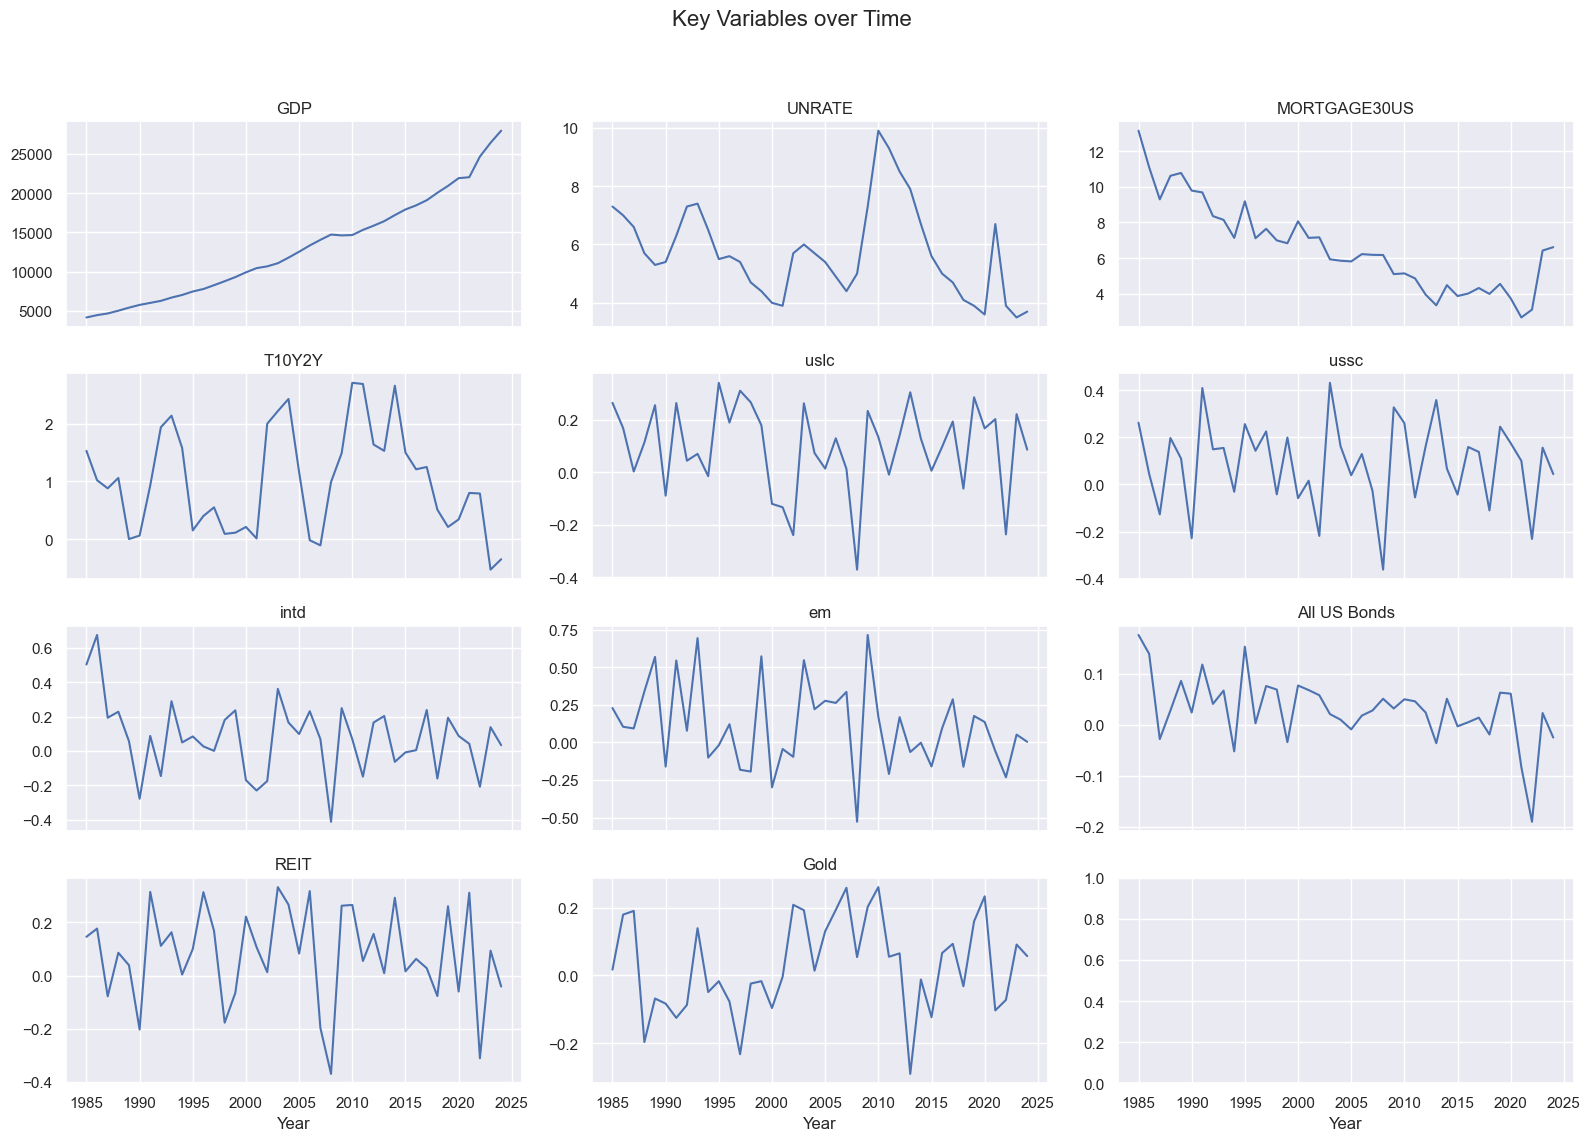

In [172]:
# Summary statistics
print(df_key.describe())

# Line plots over time
fig, axes = plt.subplots(4, 3, figsize=(16,12), sharex=True)

for ax, col in zip(axes.flatten(), df_key.columns[1:]):
    ax.plot(df_key['year'], df_key[col])
    ax.set_title(col)
    ax.set_xlabel('')
    
axes[-1,0].set_xlabel('Year') 
axes[-1,1].set_xlabel('Year')
axes[-1,2].set_xlabel('Year')

fig.suptitle('Key Variables over Time', size=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Advanced EDA & Baseline Models

In [173]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
year                 0
uslc                 0
ussc                 0
intd                 0
em                   0
All US Bonds         0
Hi-Yield US Bonds    0
Int'l Bonds          0
Cash (T-Bill)        0
REIT                 0
Gold                 0
CPIAUCSL             0
T10Y2Y               0
MORTGAGE30US         0
FEDFUNDS             0
UNRATE               0
T10Y3M               0
M2SL                 0
GDP                  0
gdp_m2               0
unemp_ffr            0
dtype: int64


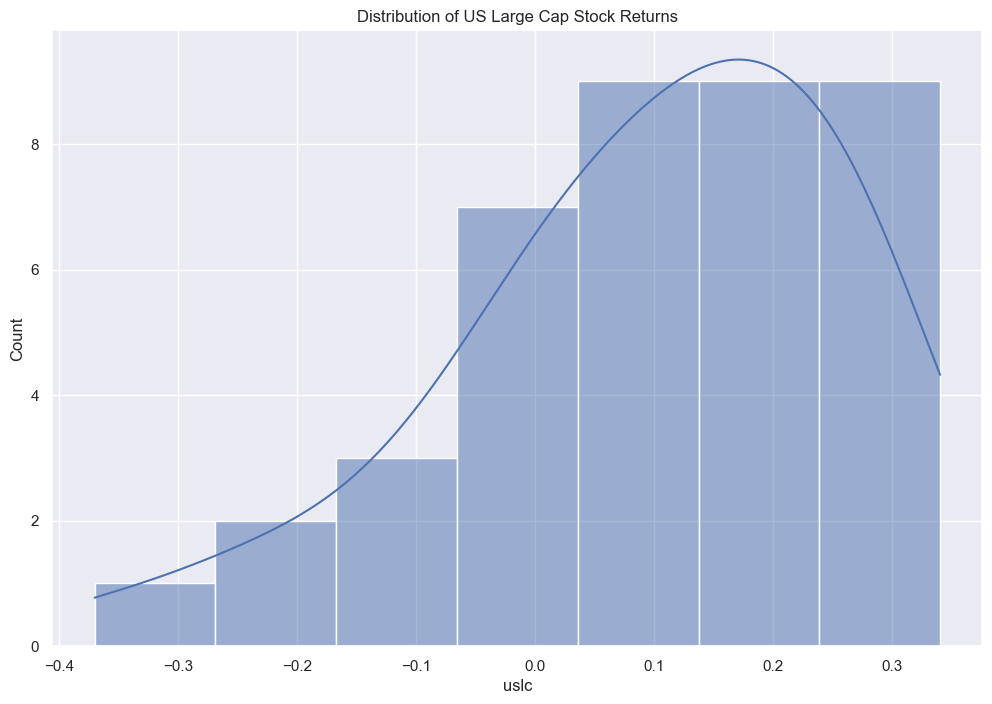

In [175]:
#Histogram of US Large Cap
plt.figure(figsize=(12,8))
sns.histplot(df['uslc'], kde=True)
plt.title('Distribution of US Large Cap Stock Returns')
plt.show()

We can see that the distribution is someone normal though the data does exhibit skewness.

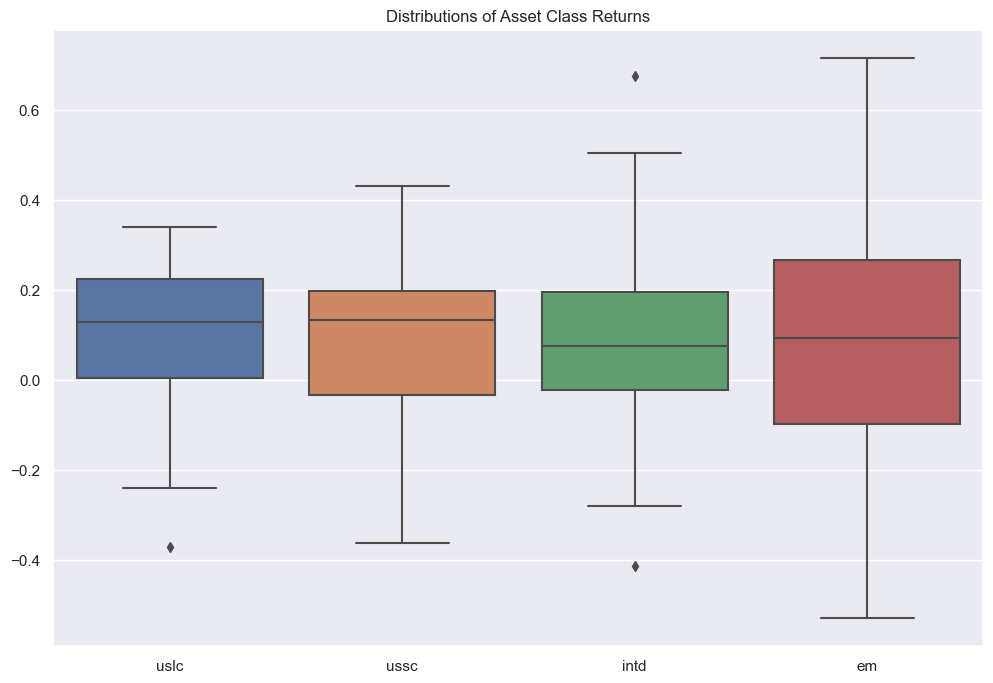

In [176]:
#Box plots showing the Distributions of Asset Class Returns
plt.figure(figsize=(12,8)) 
sns.boxplot(data=df[['uslc', 'ussc', 'intd', 'em']])
plt.title('Distributions of Asset Class Returns')
plt.show()

We can see here that international developed stocks and emergining market stocks tend to be more volatile and have a wider range of returns. These assets are often seen as more speculative than US large cap stocks.

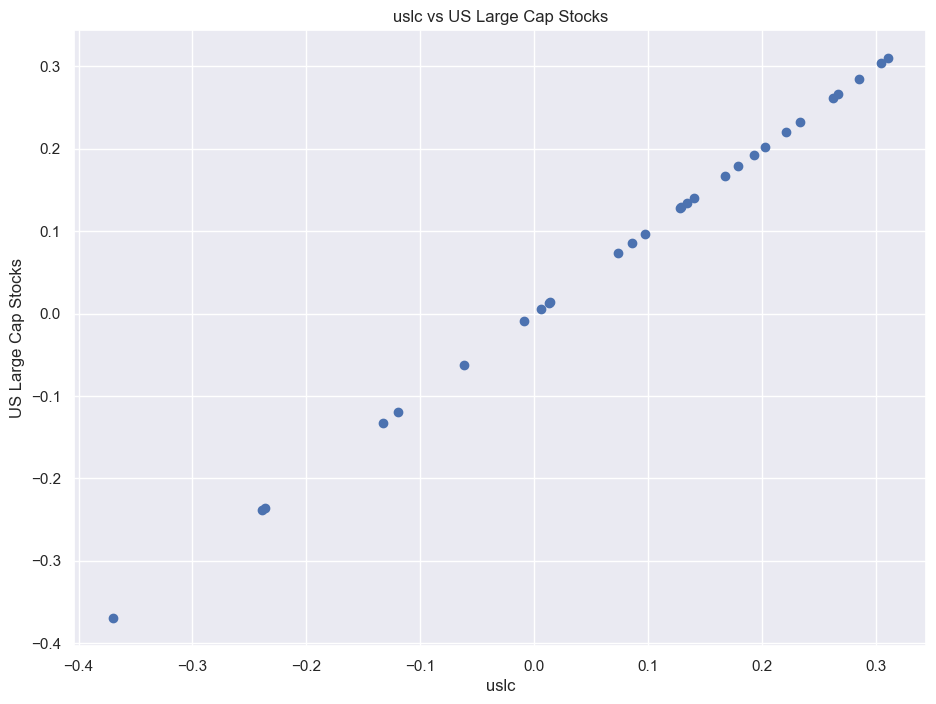

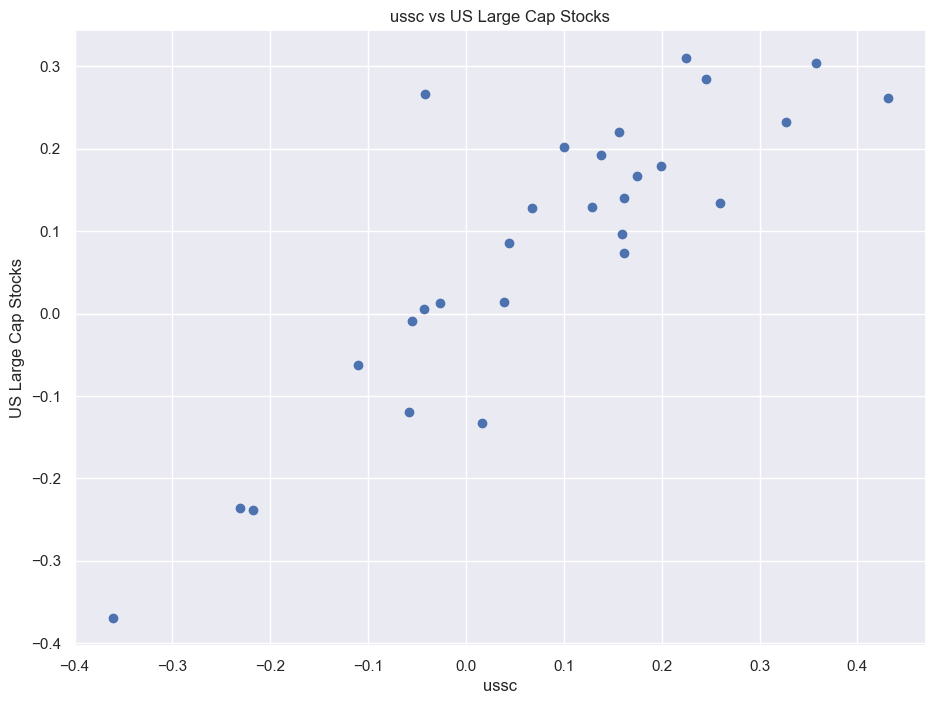

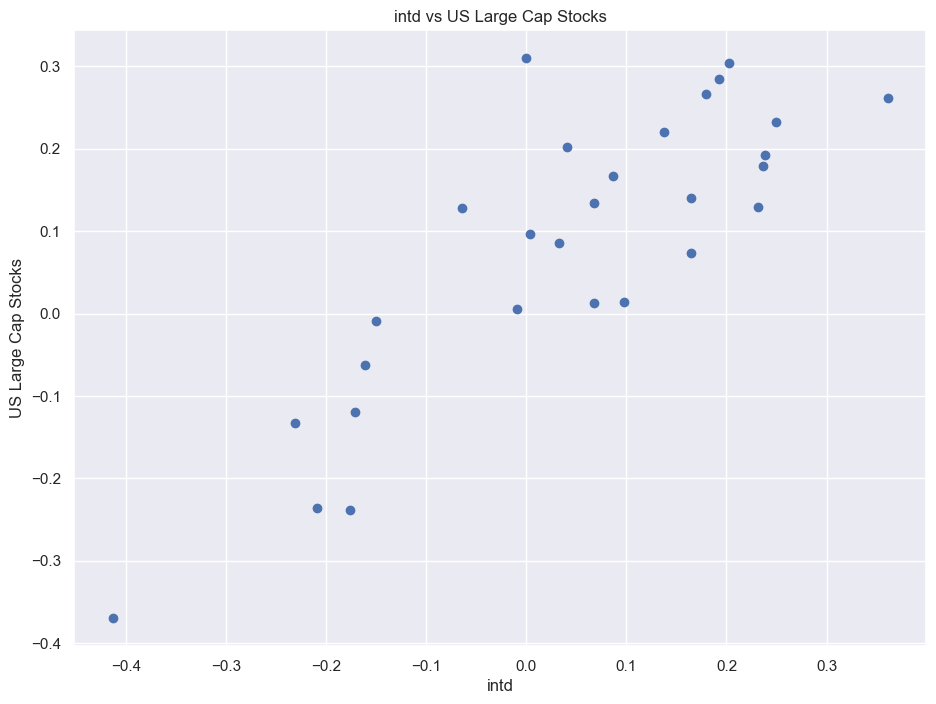

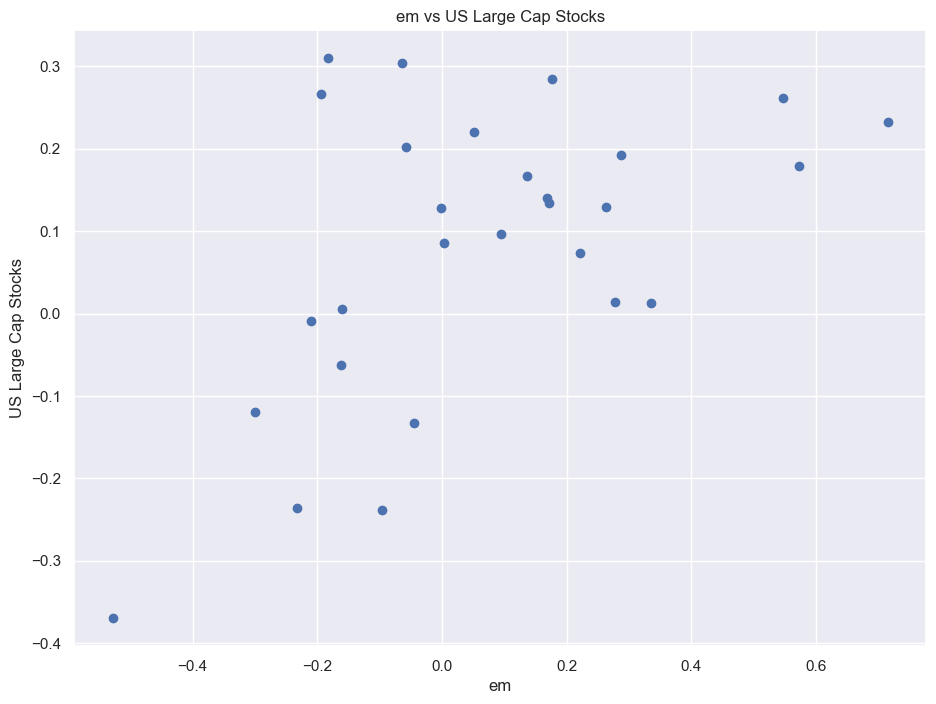

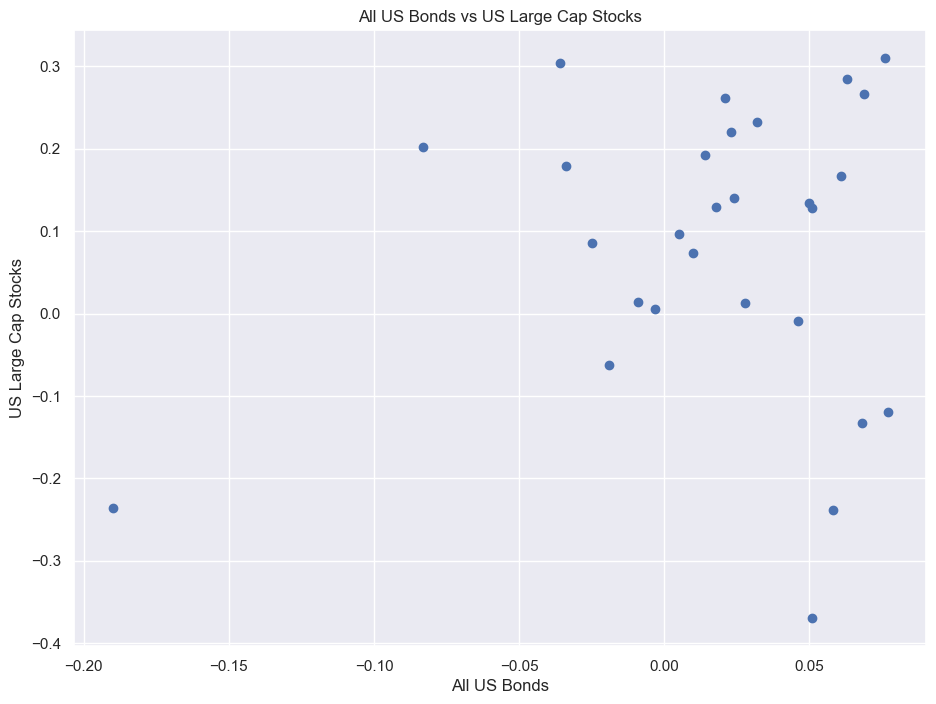

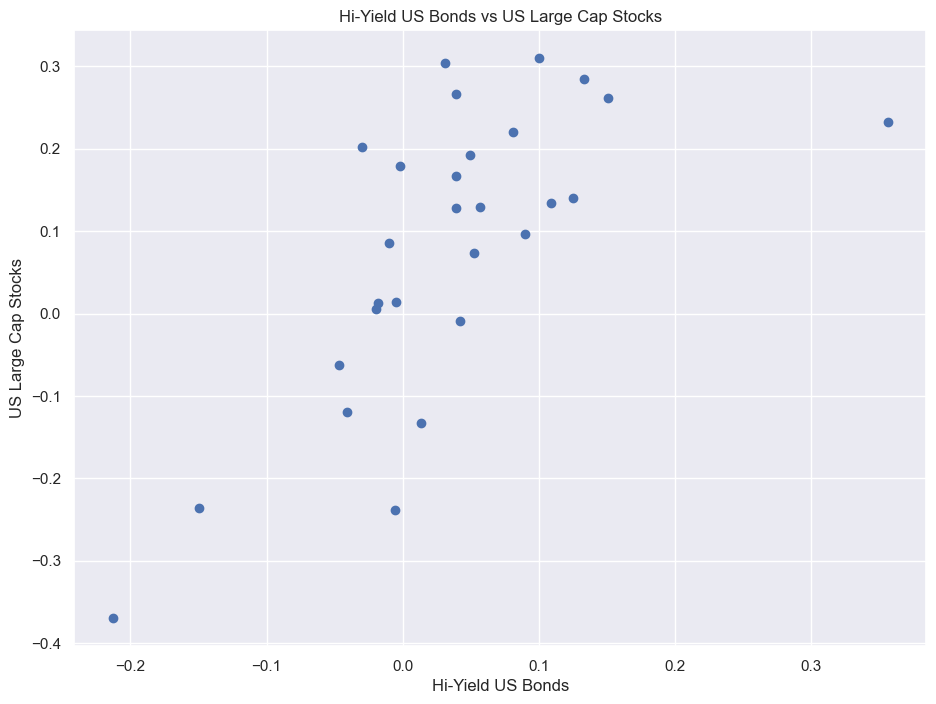

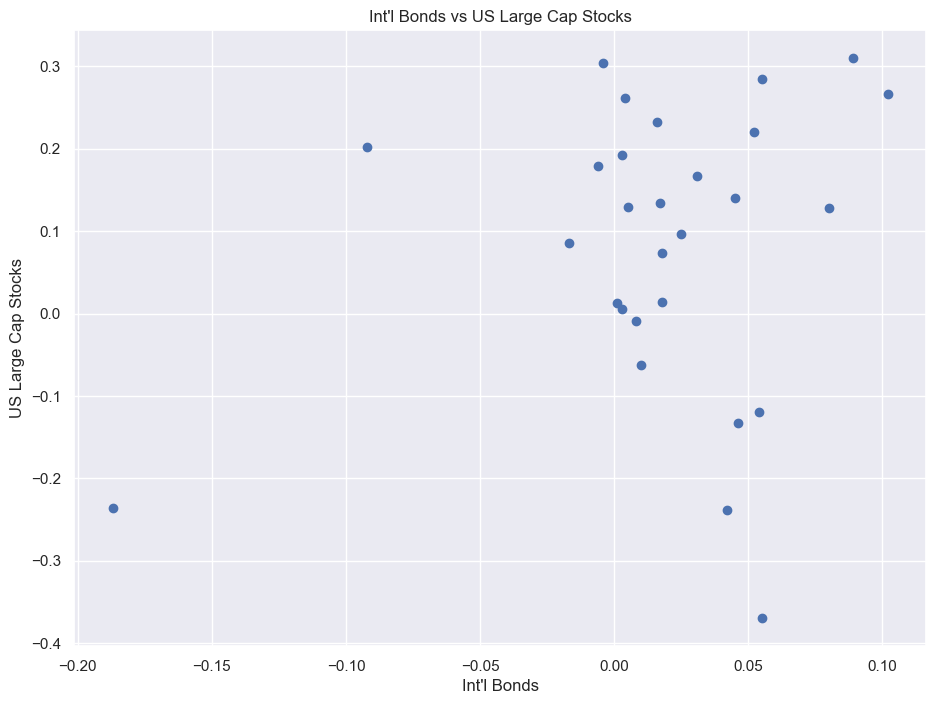

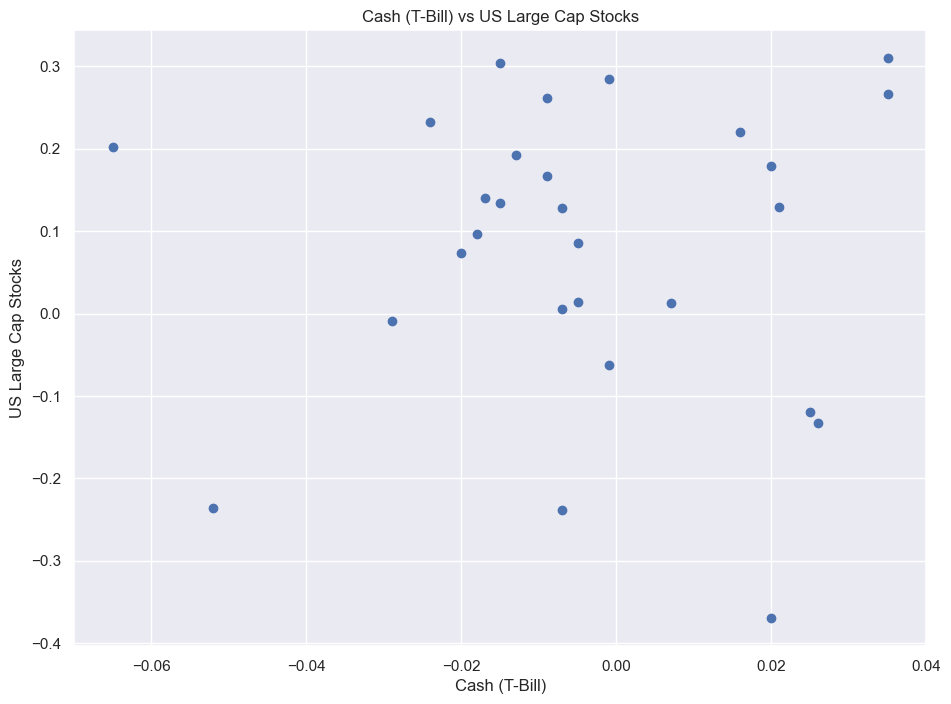

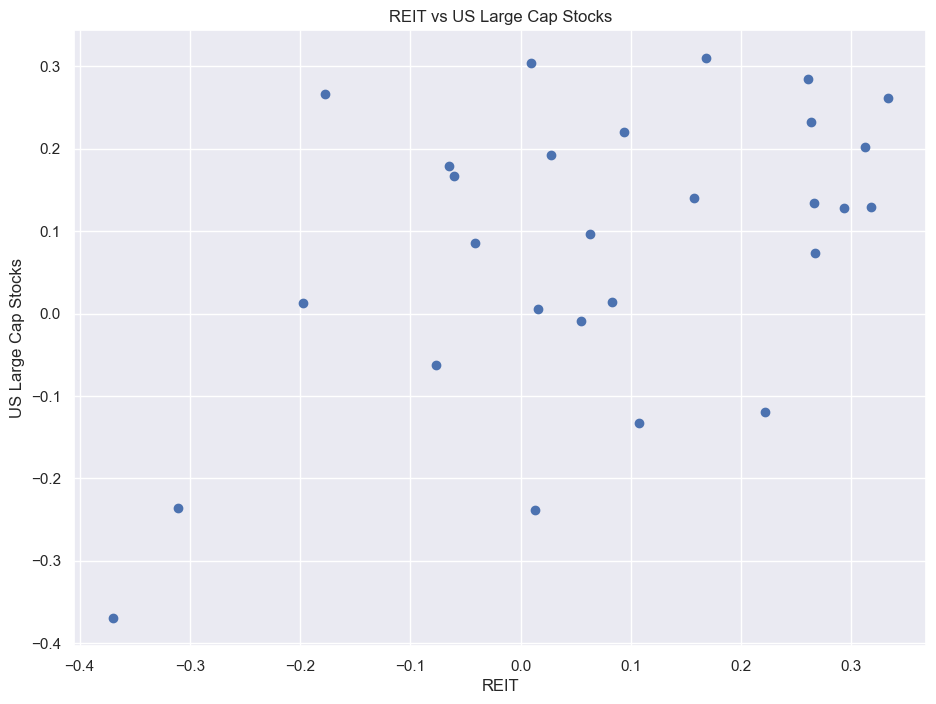

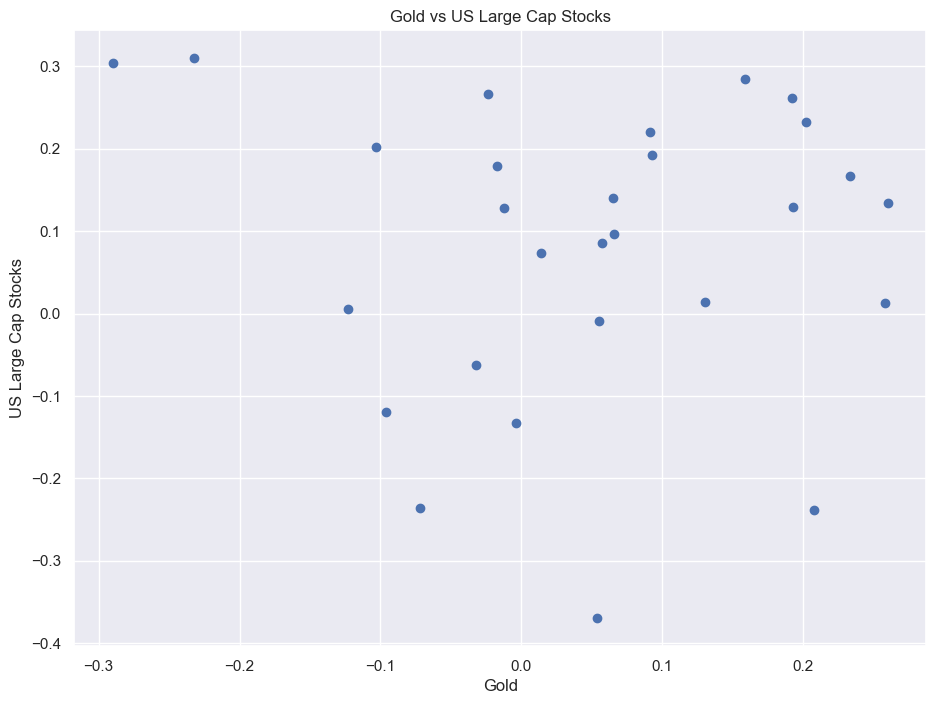

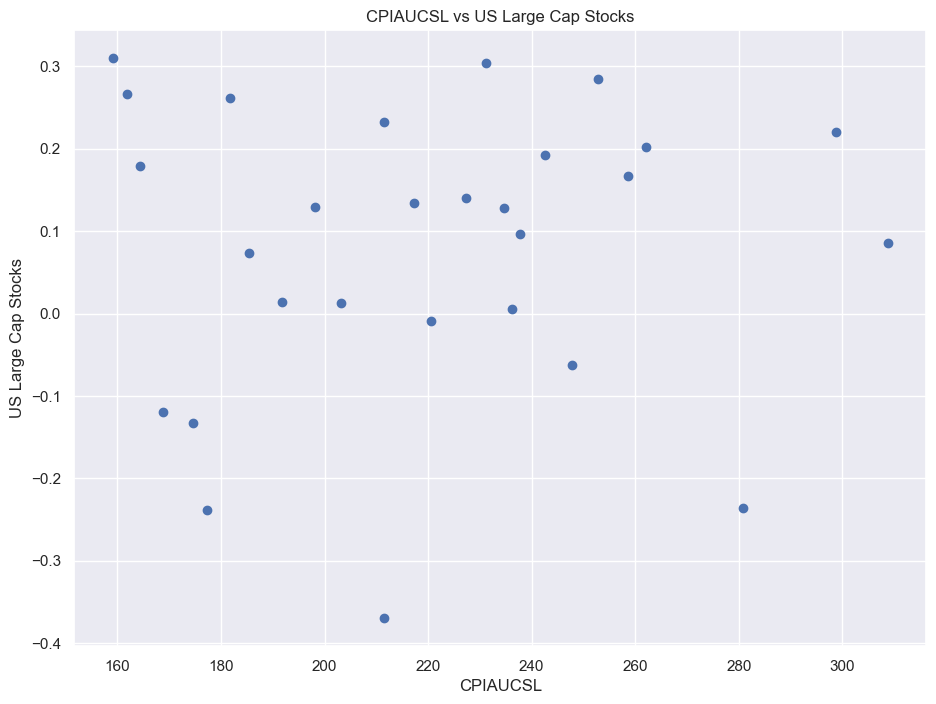

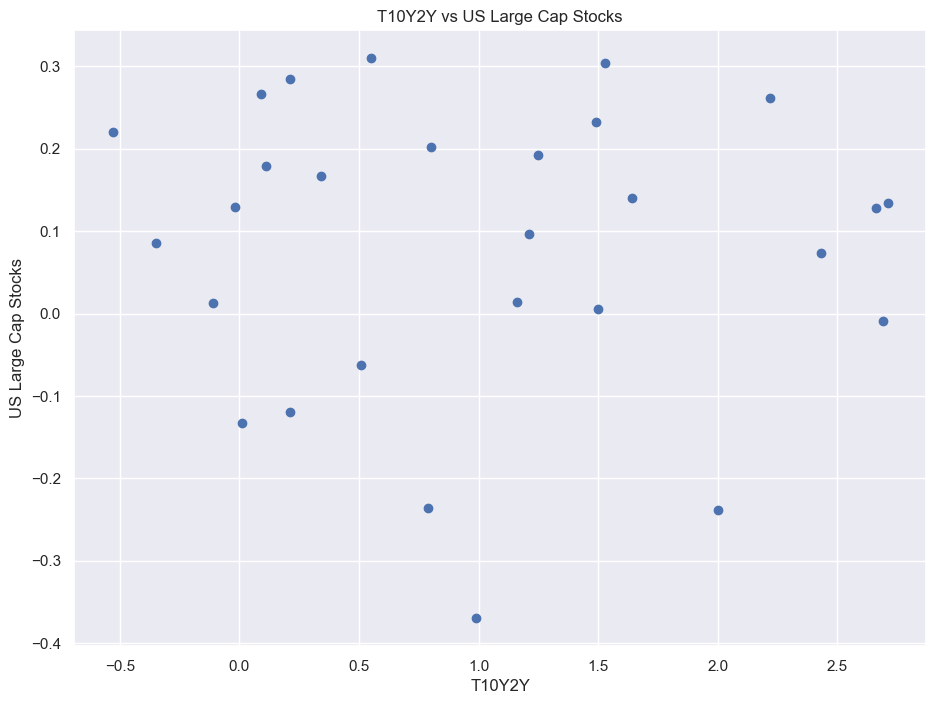

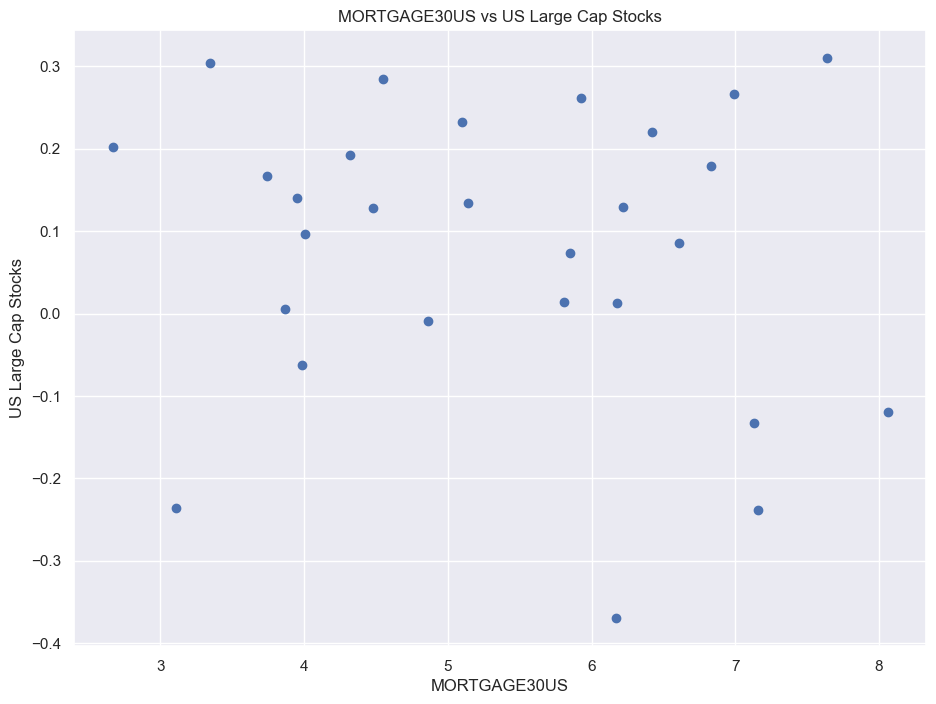

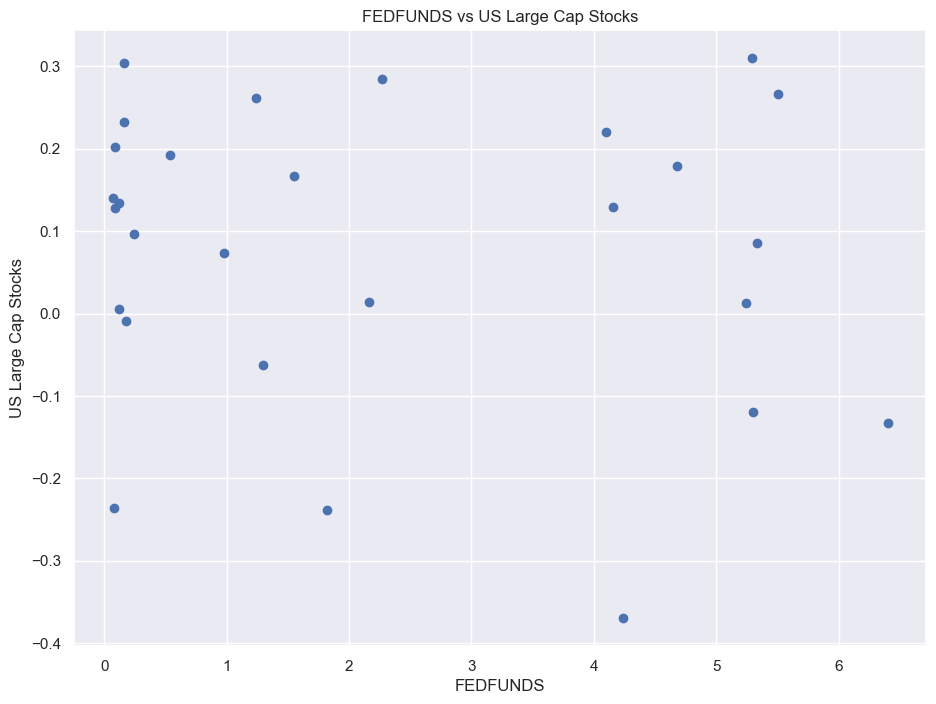

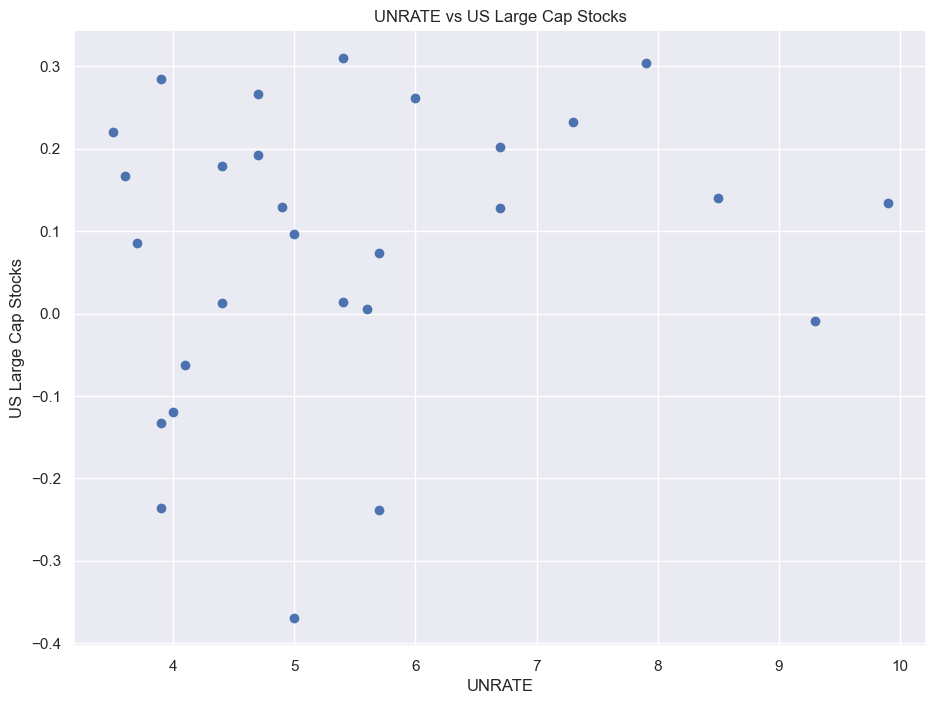

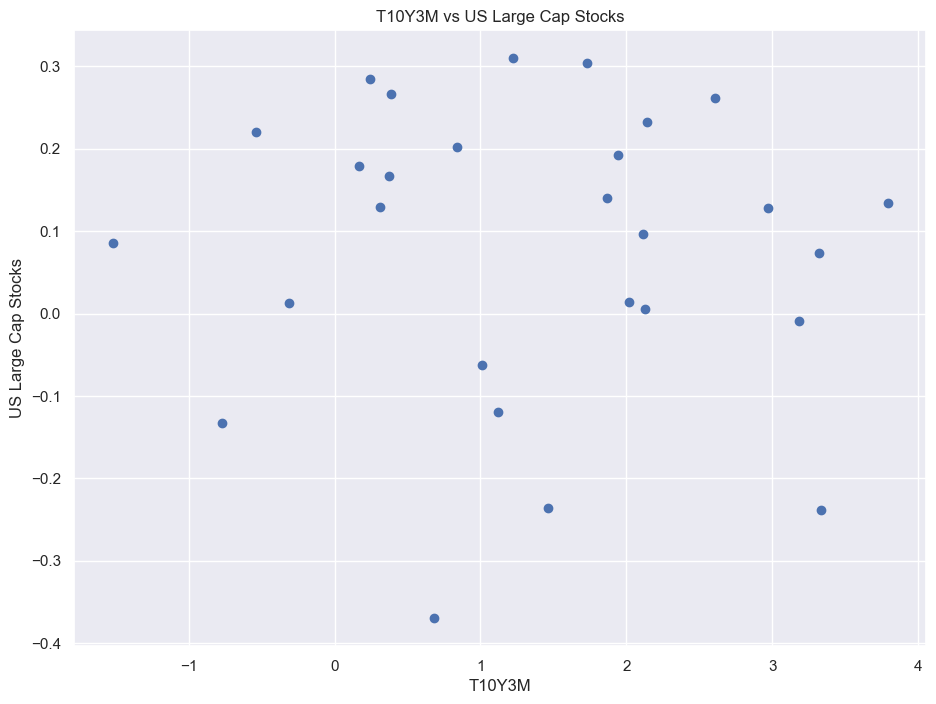

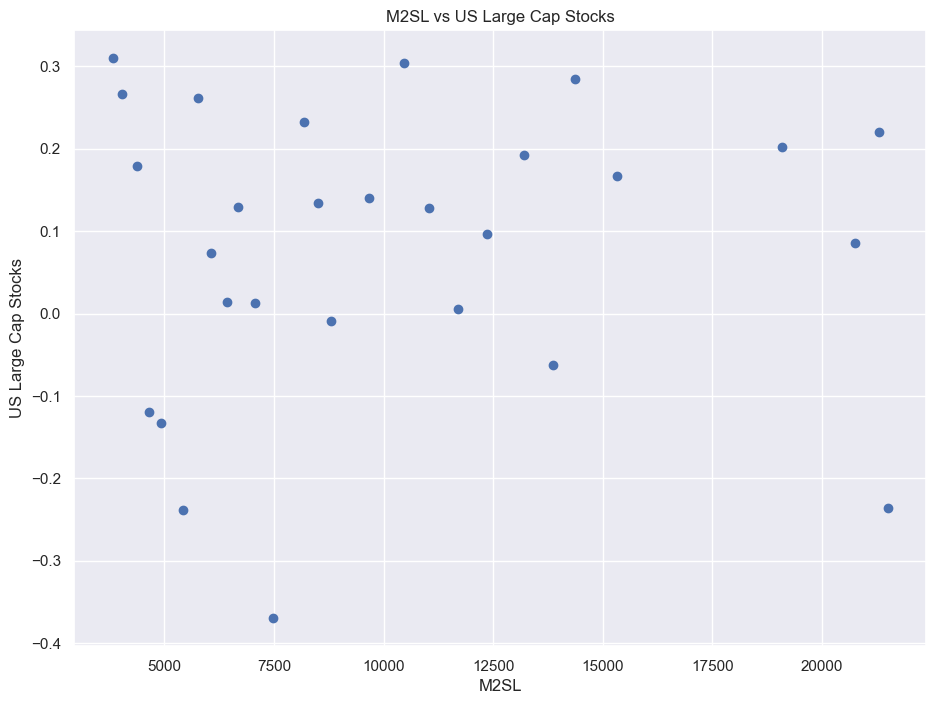

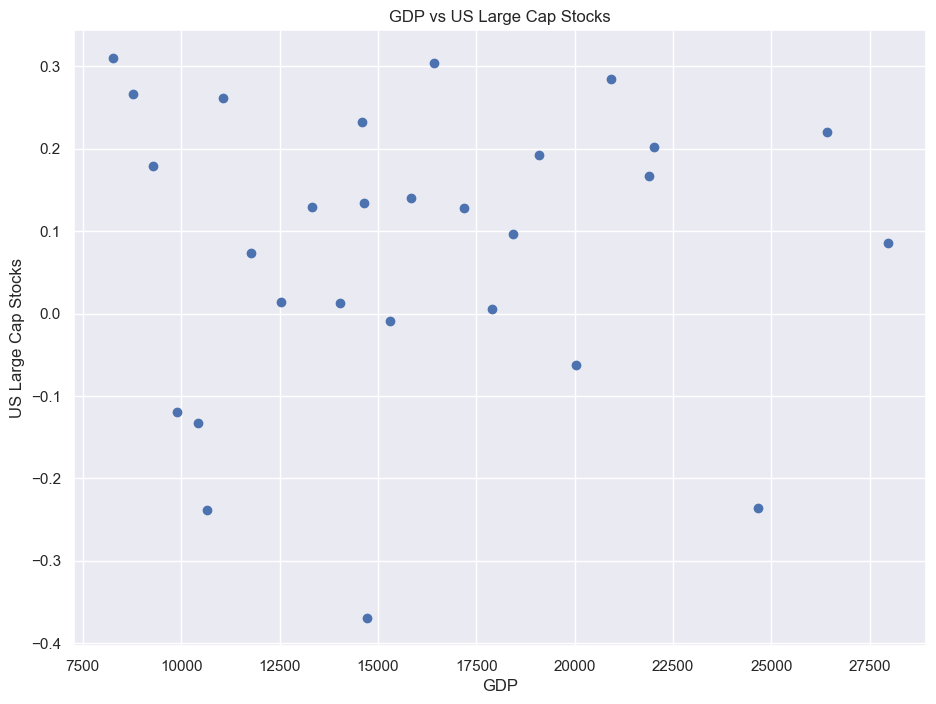

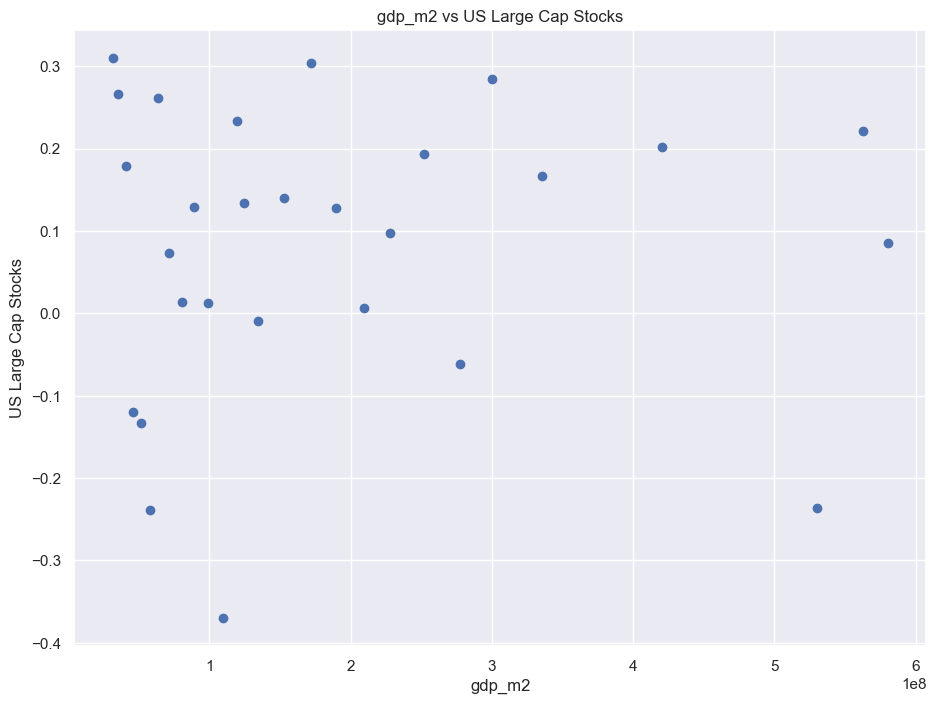

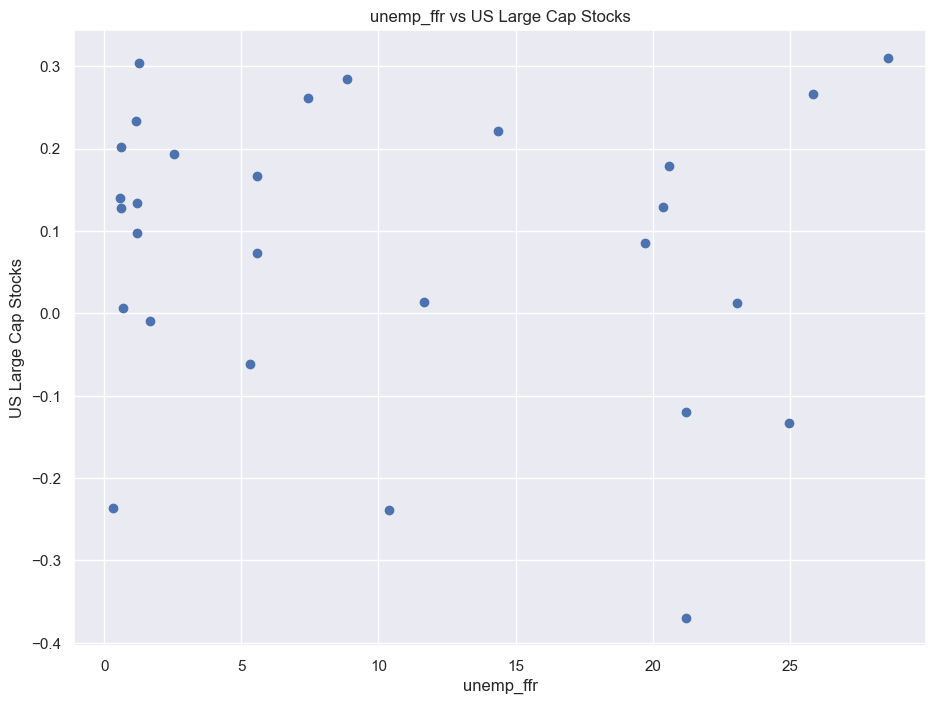

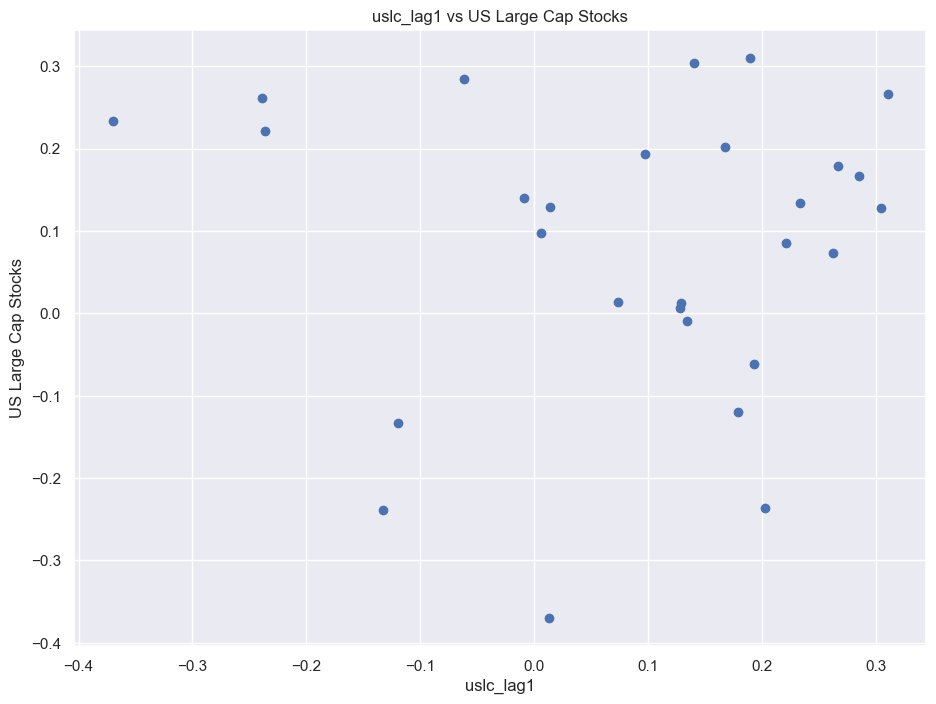

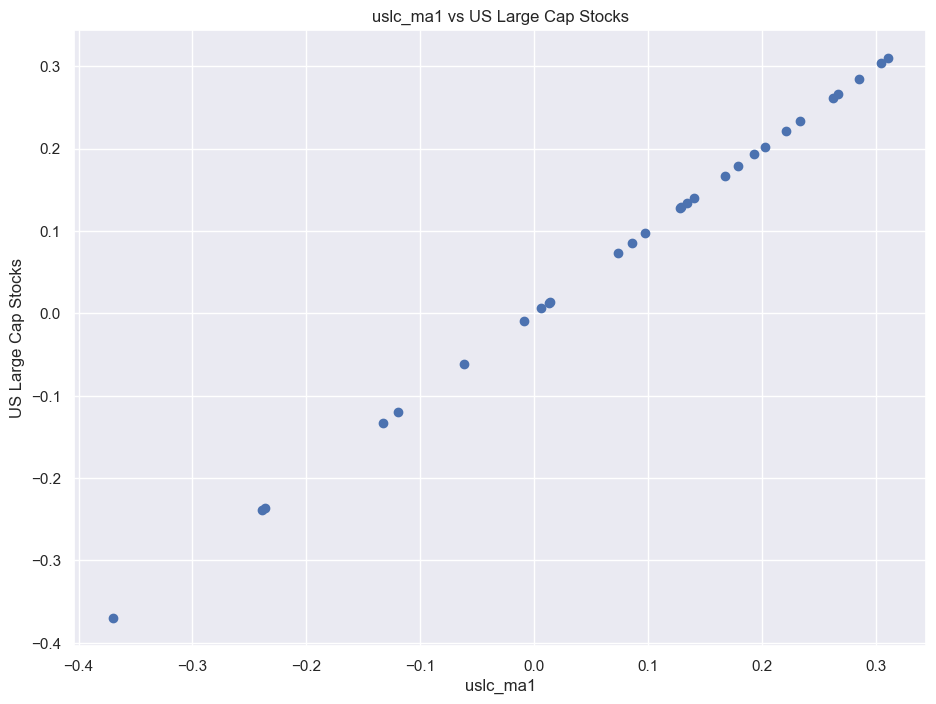

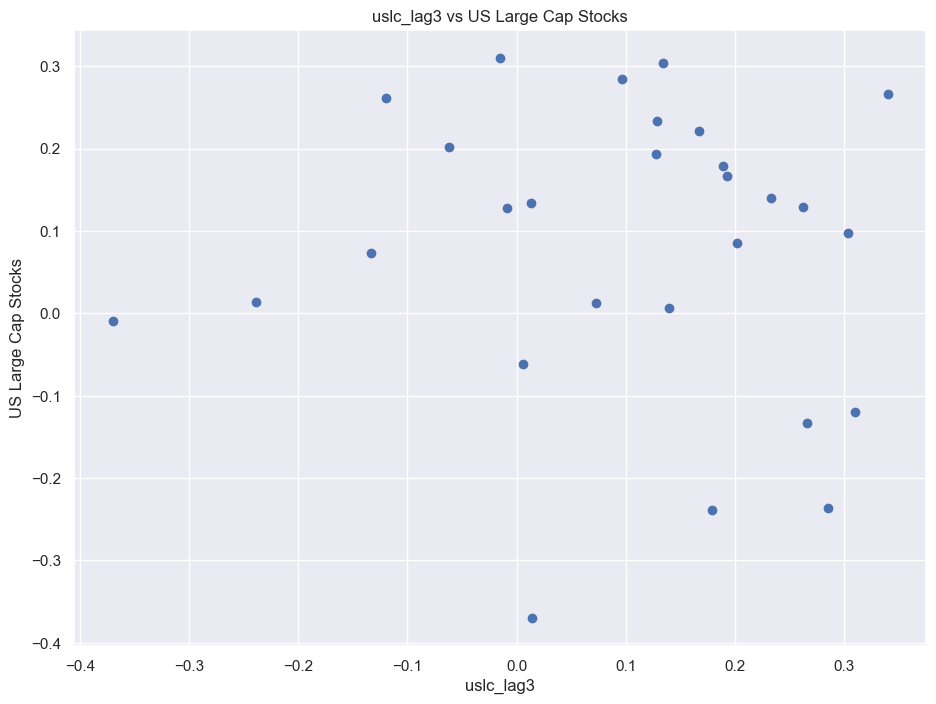

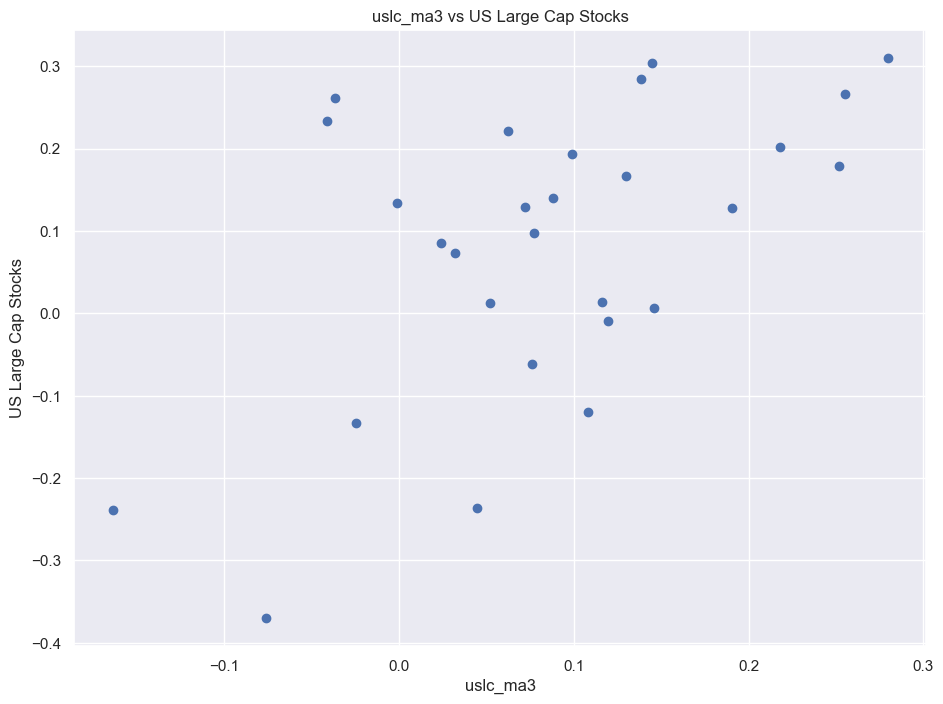

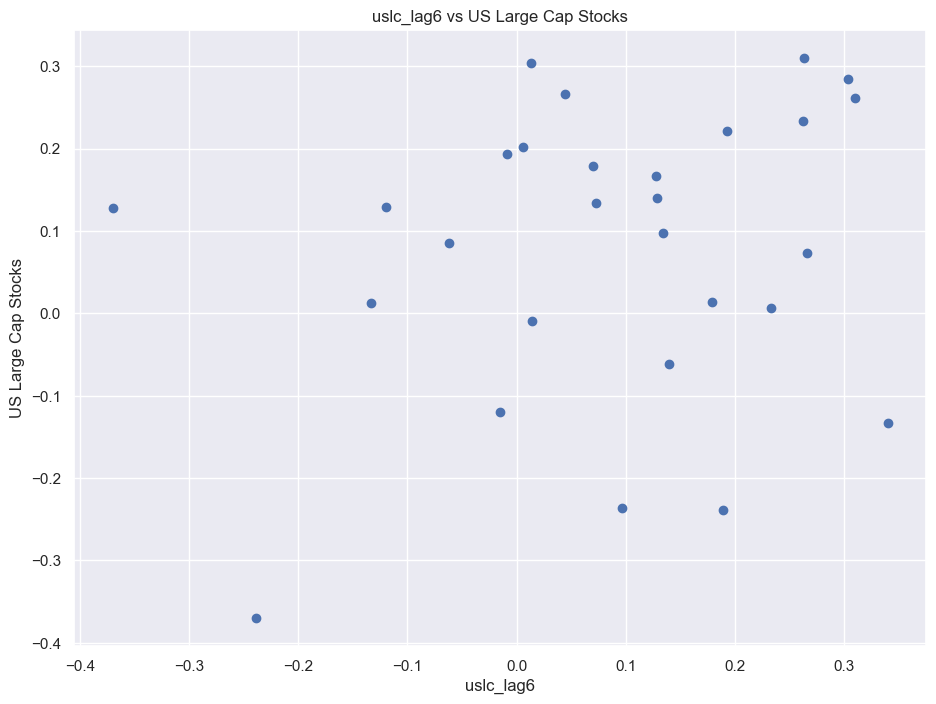

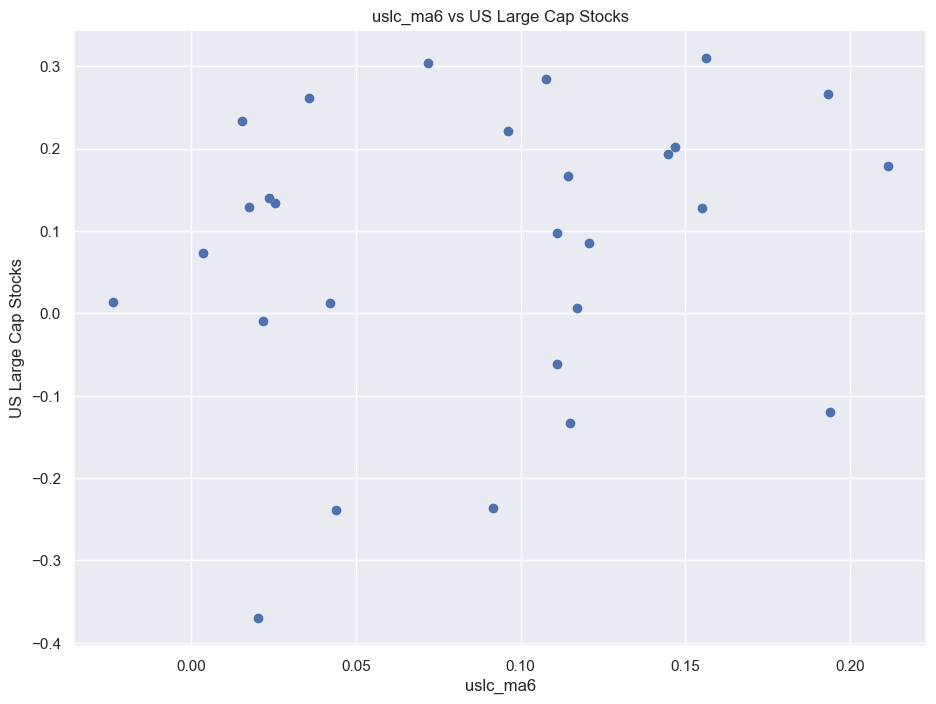

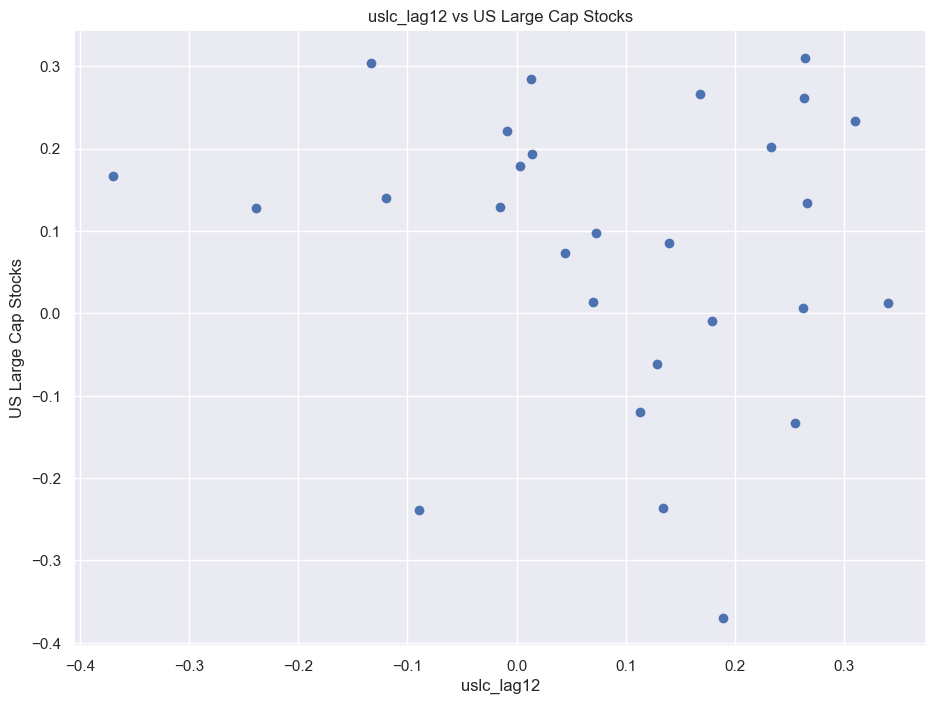

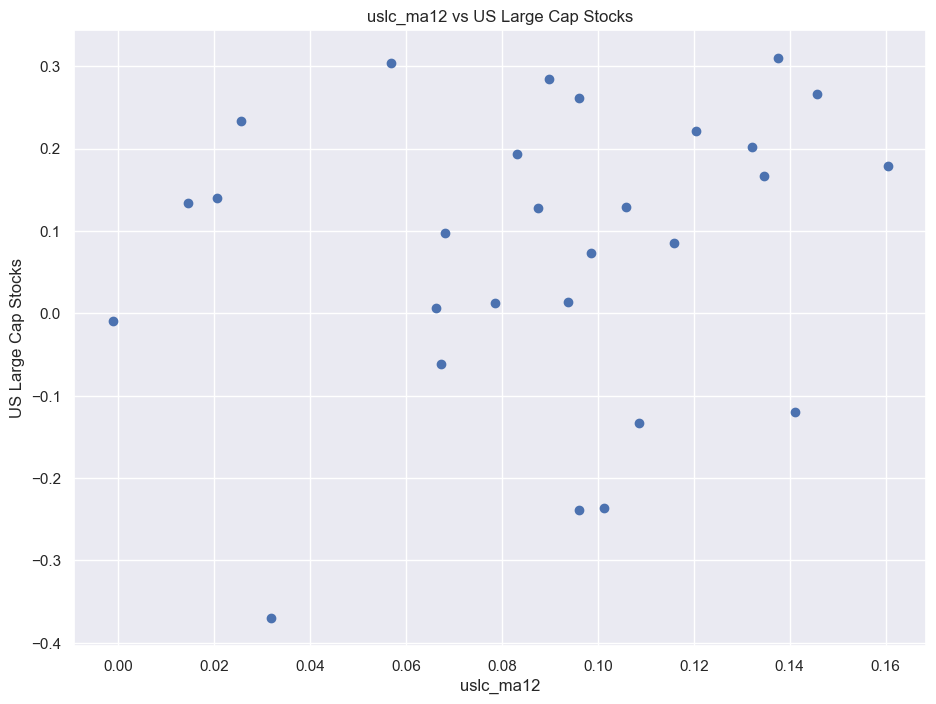

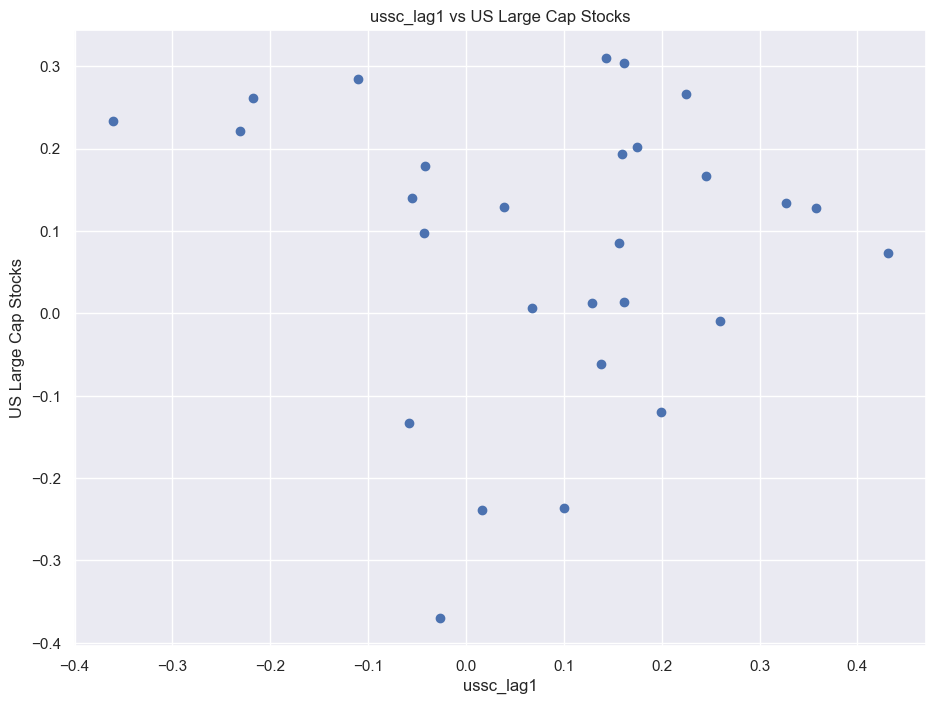

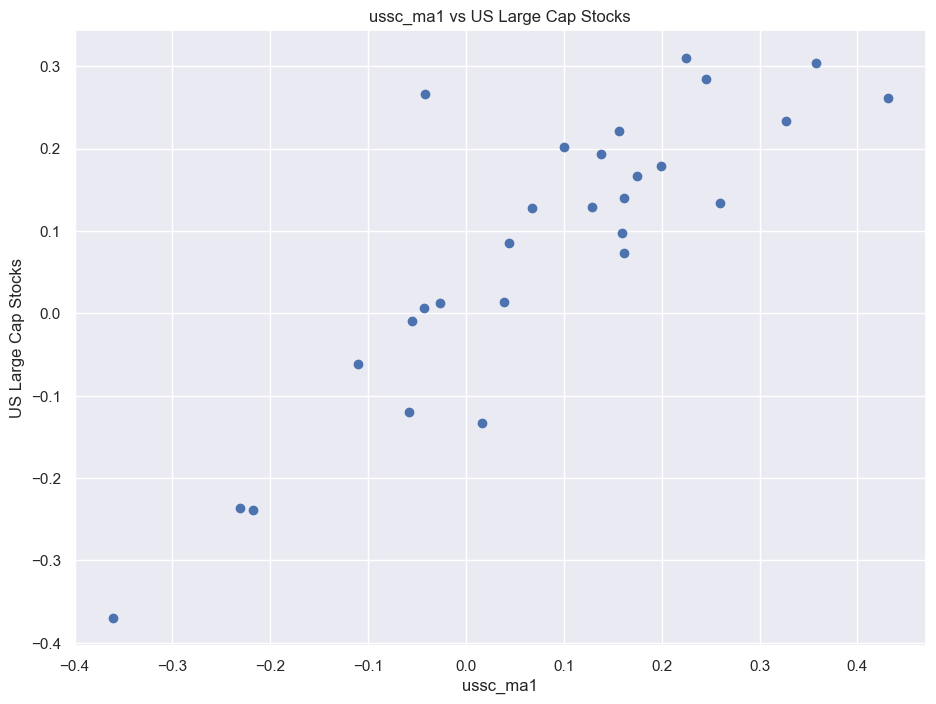

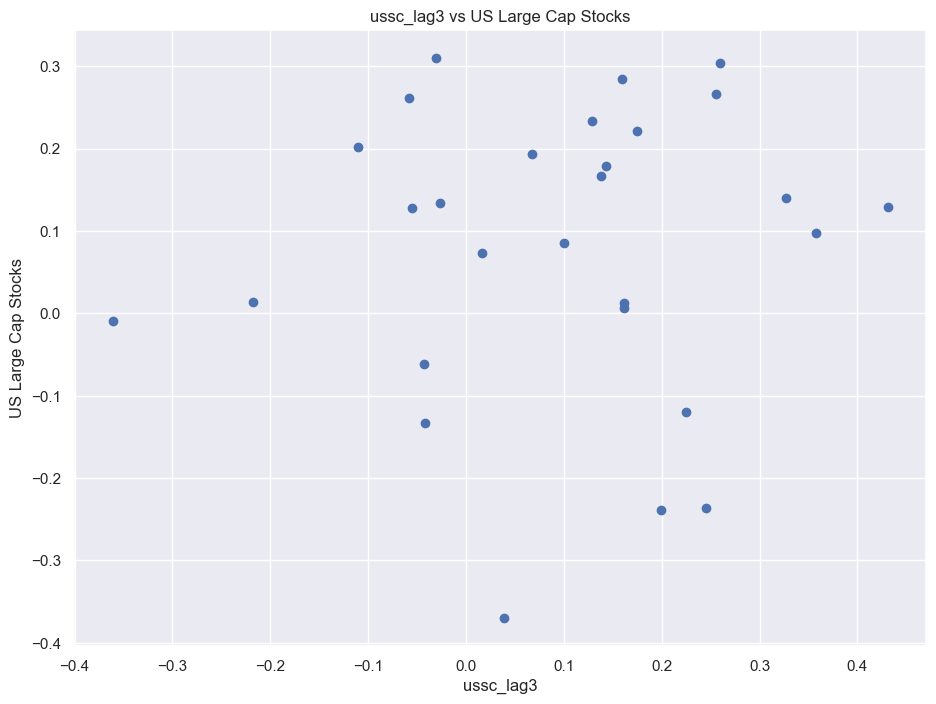

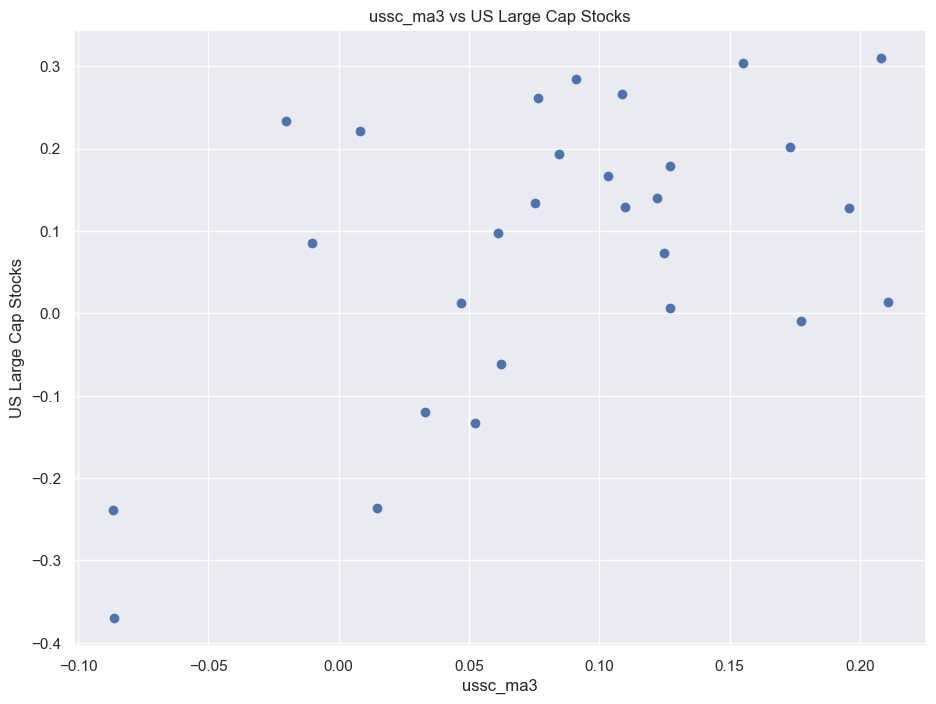

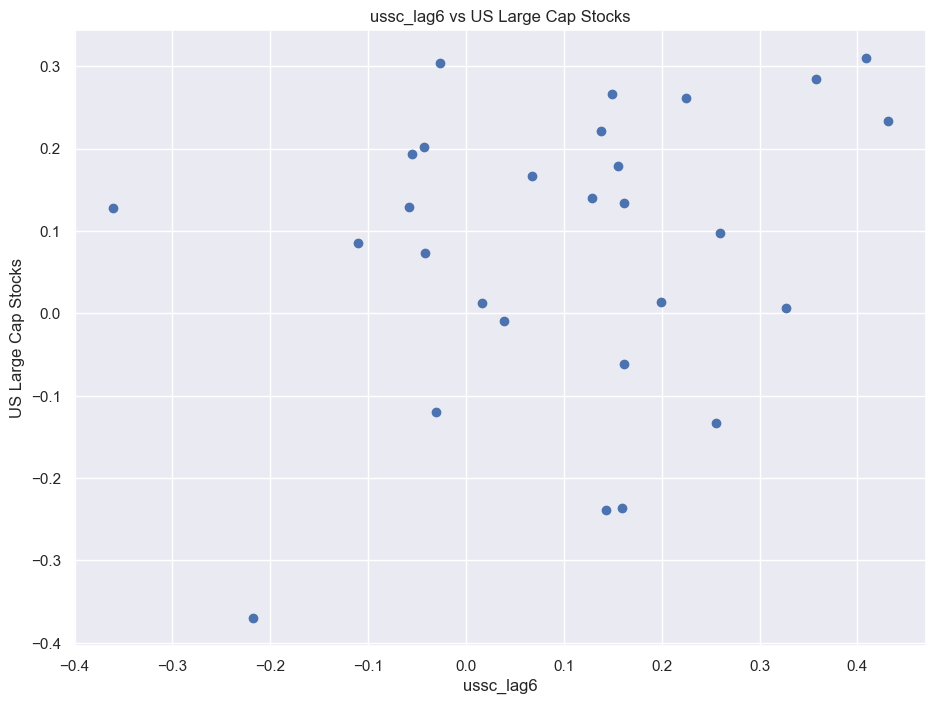

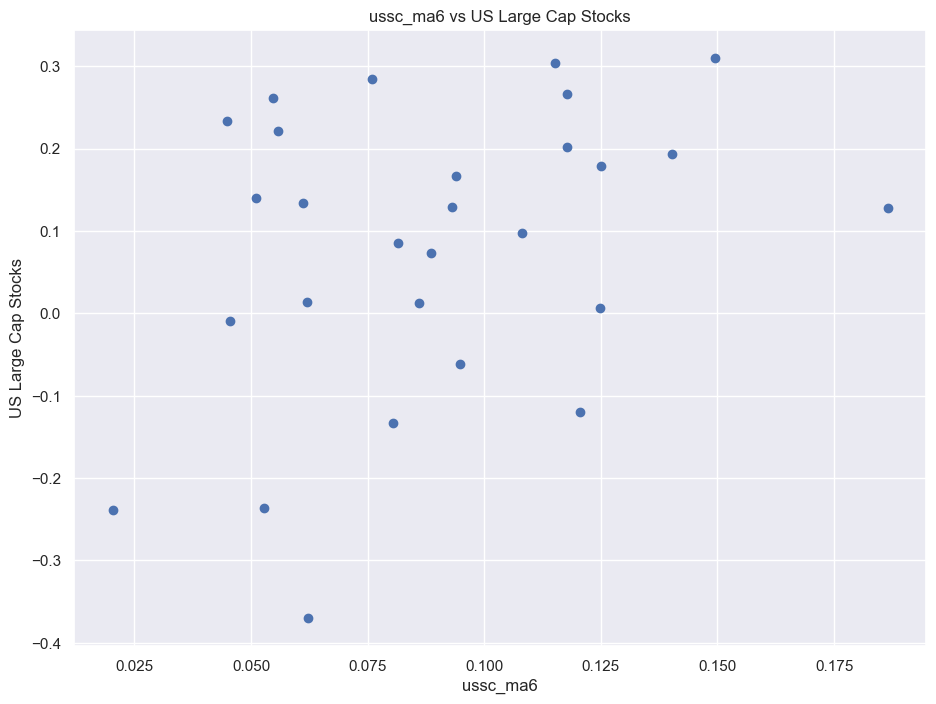

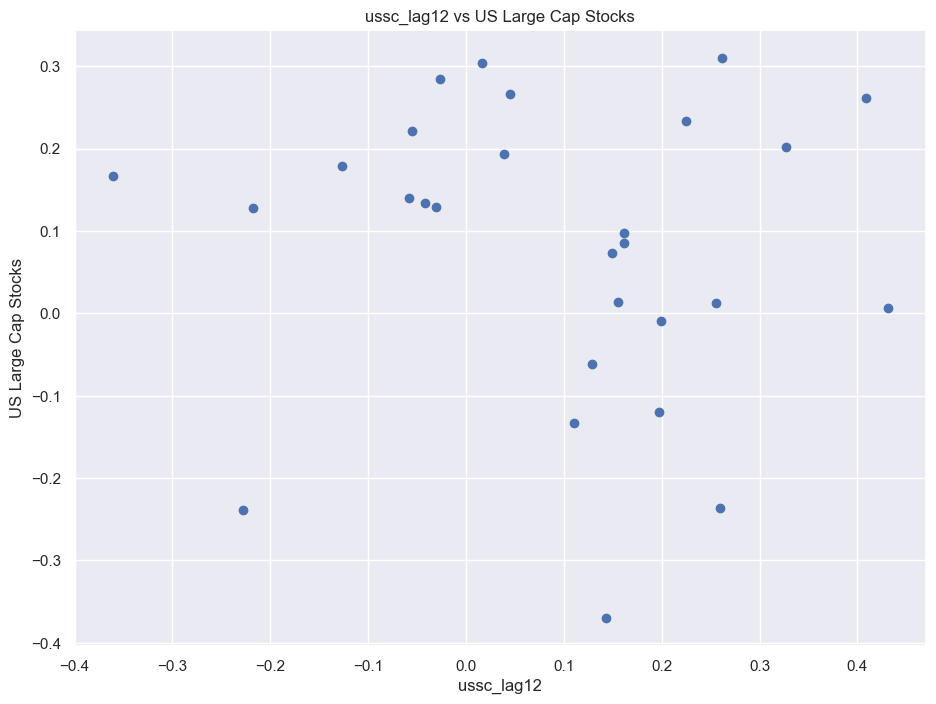

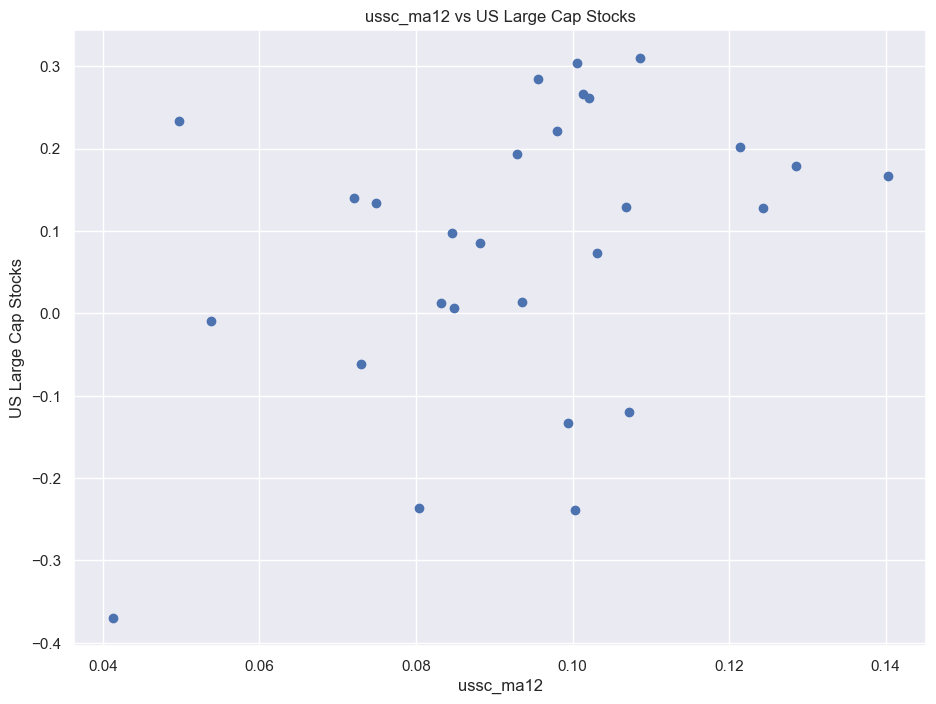

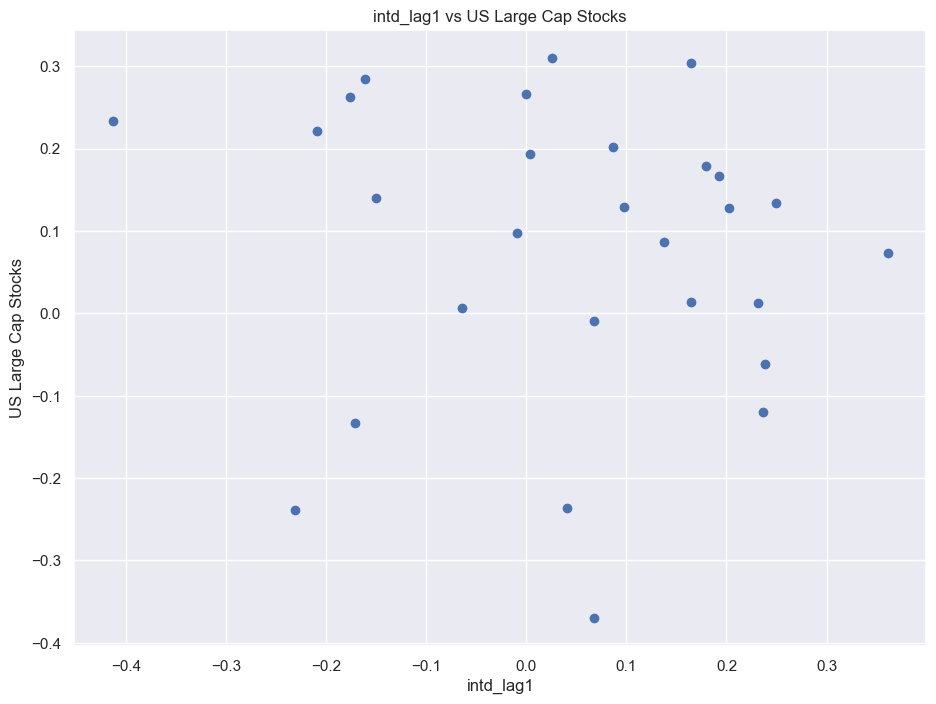

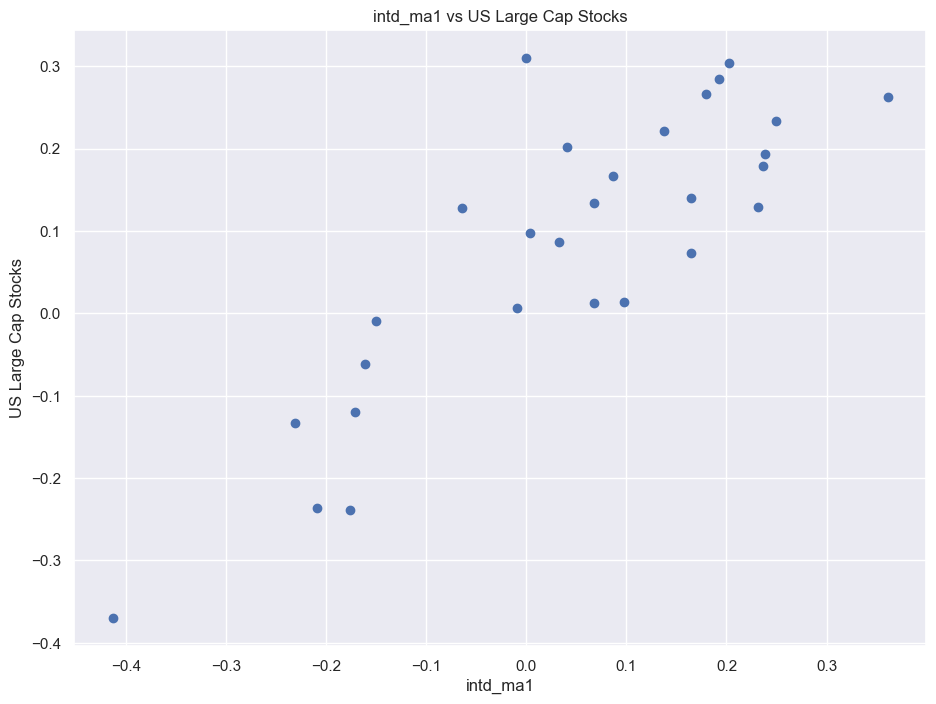

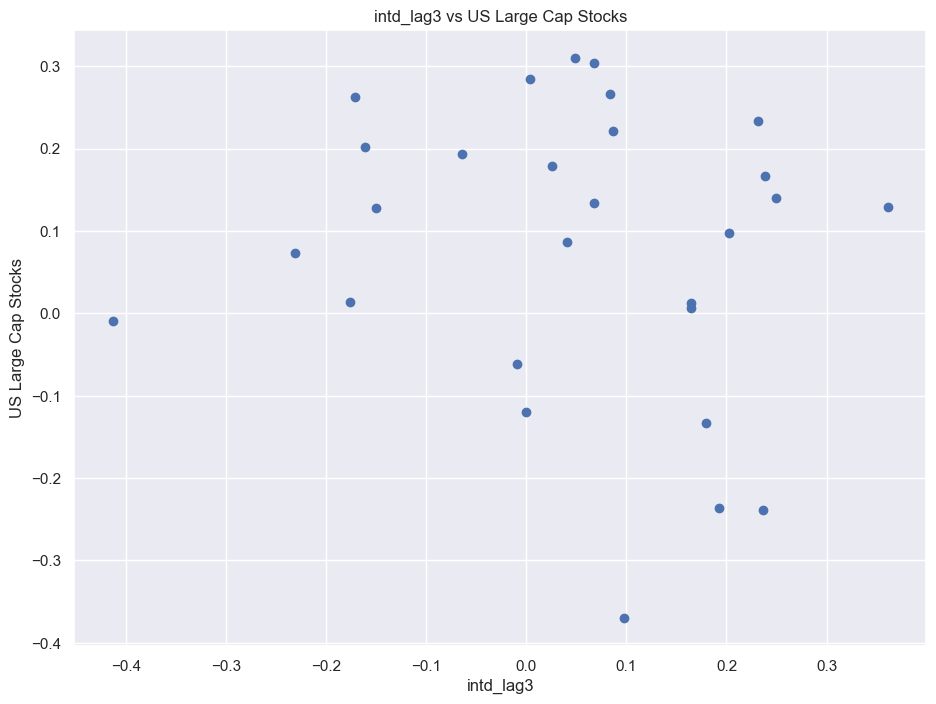

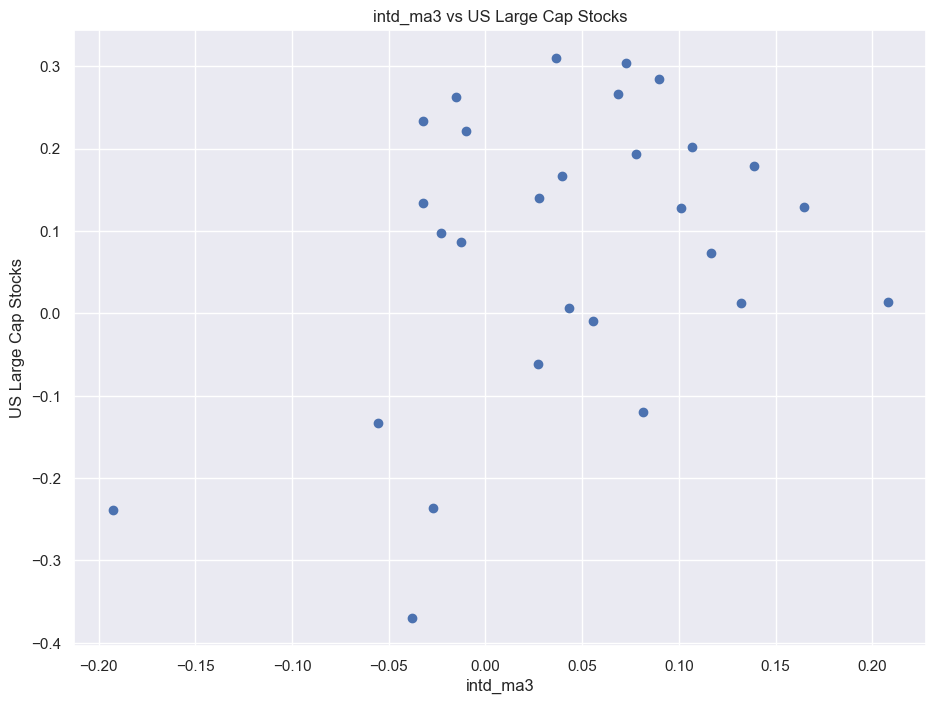

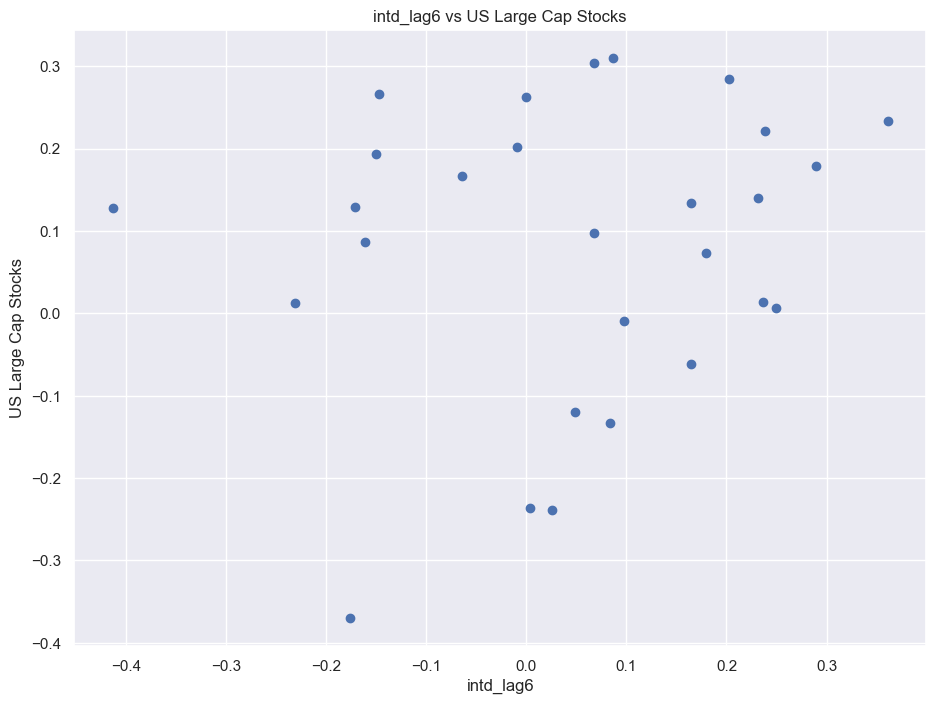

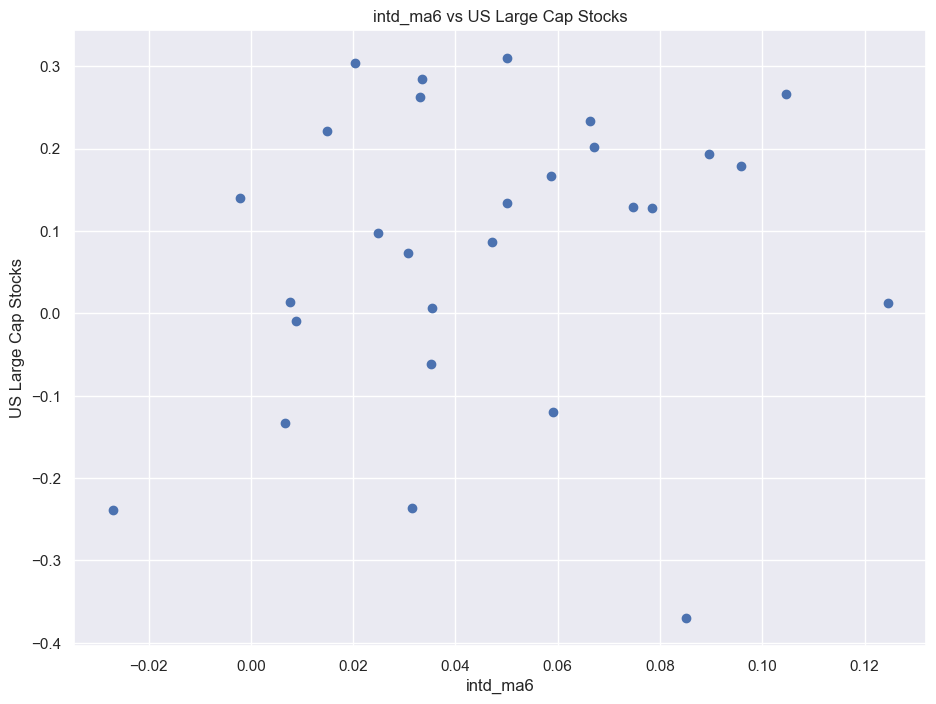

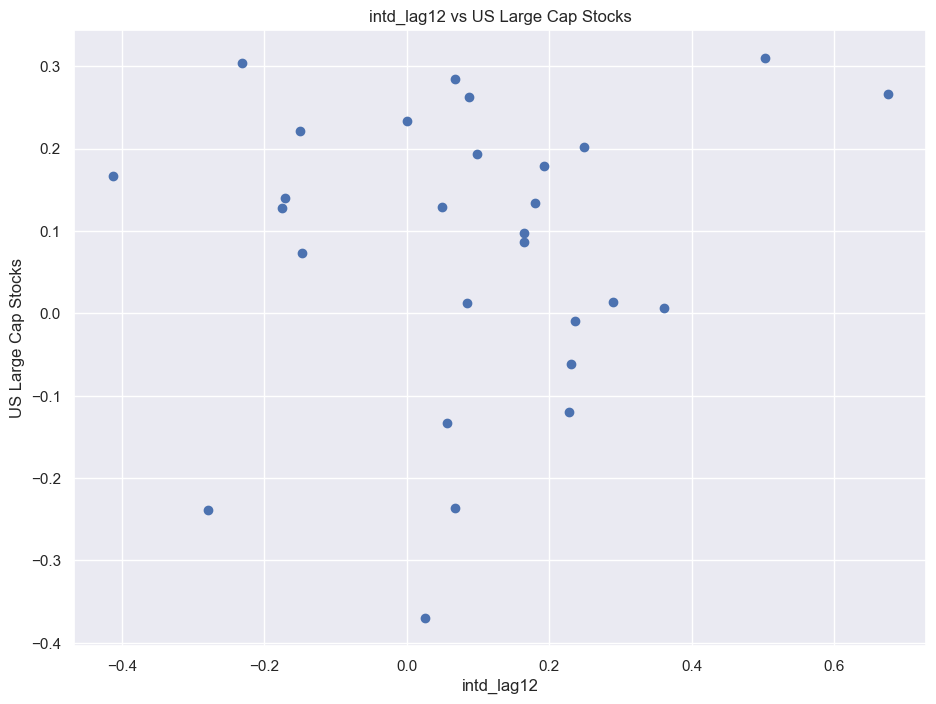

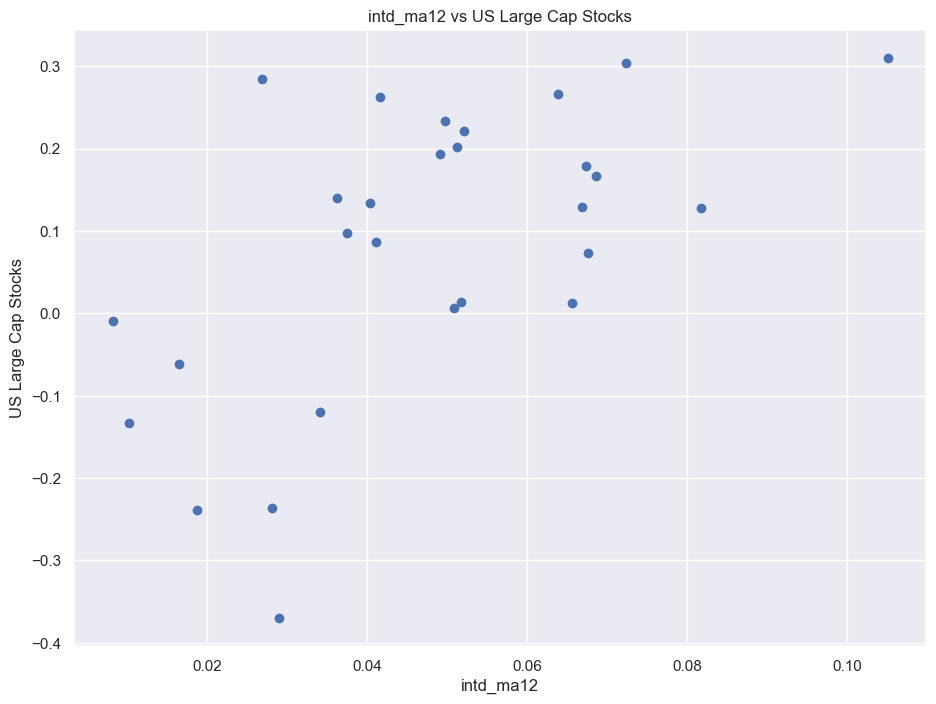

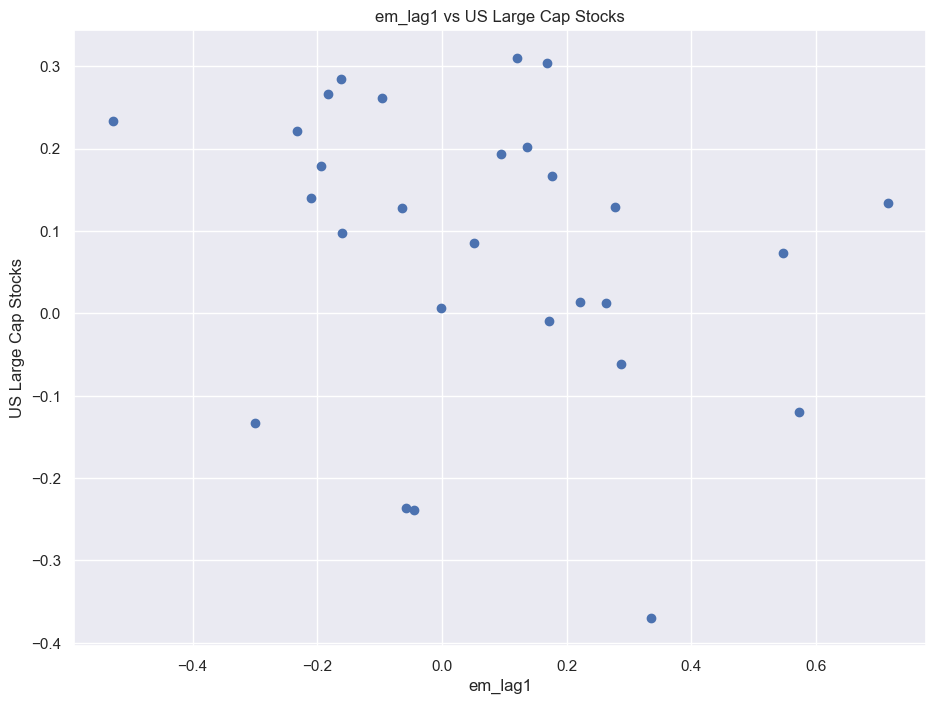

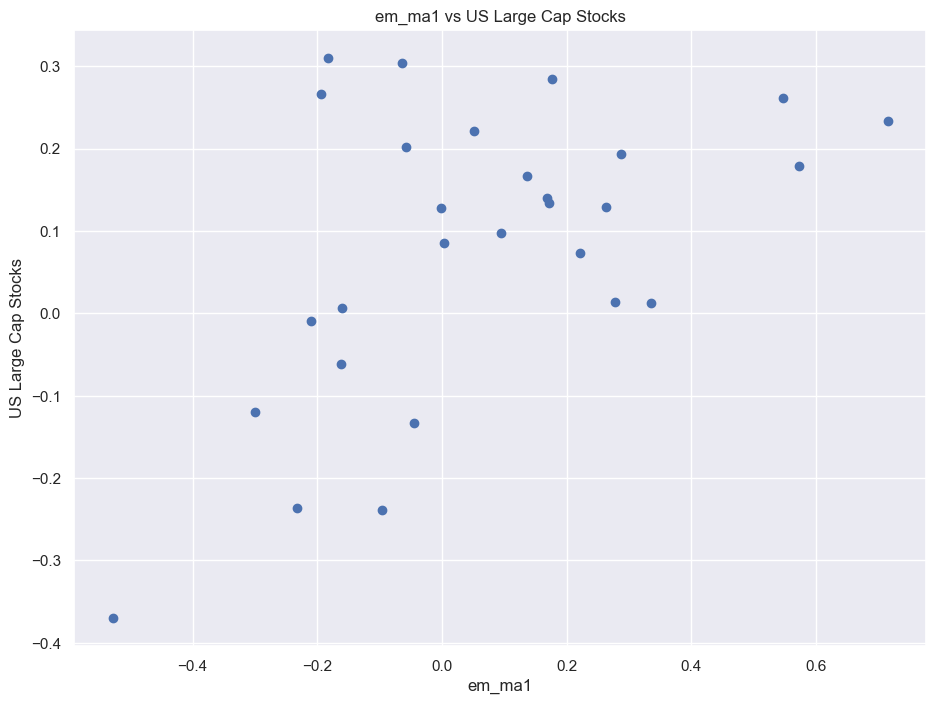

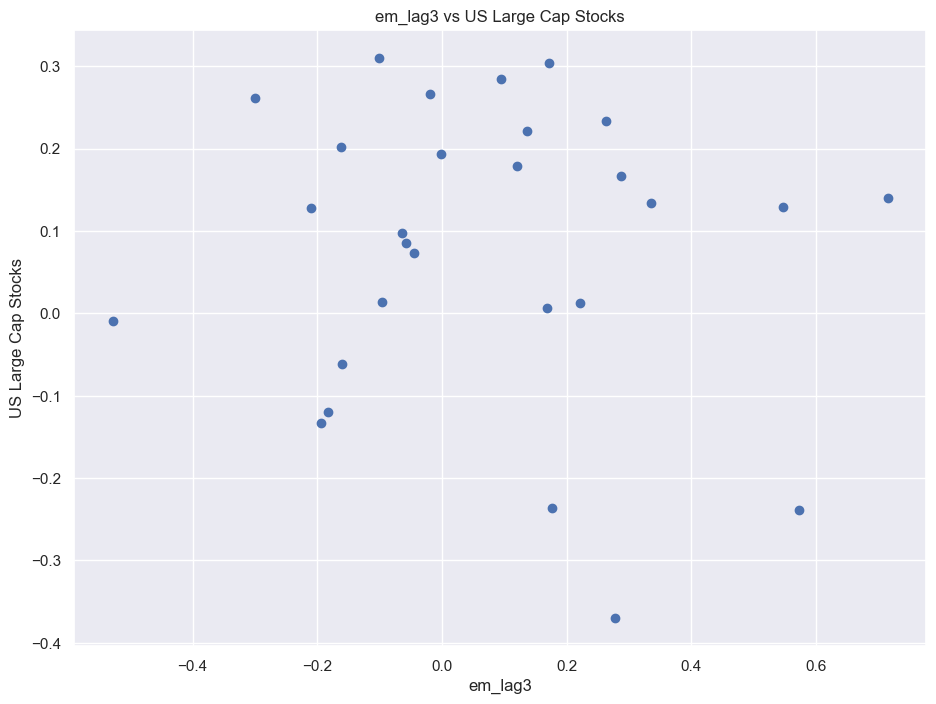

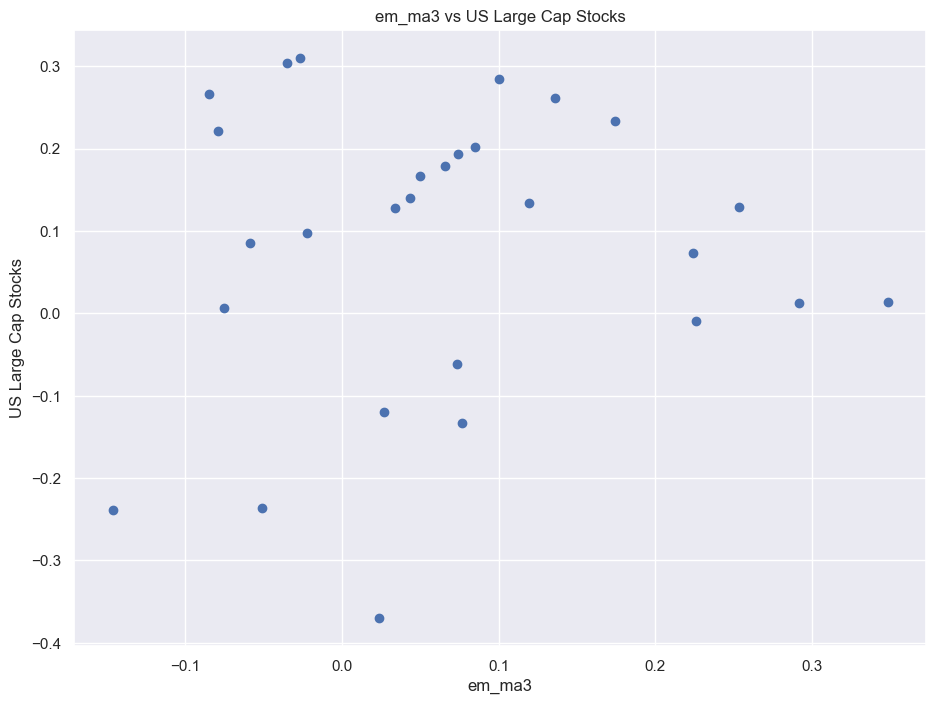

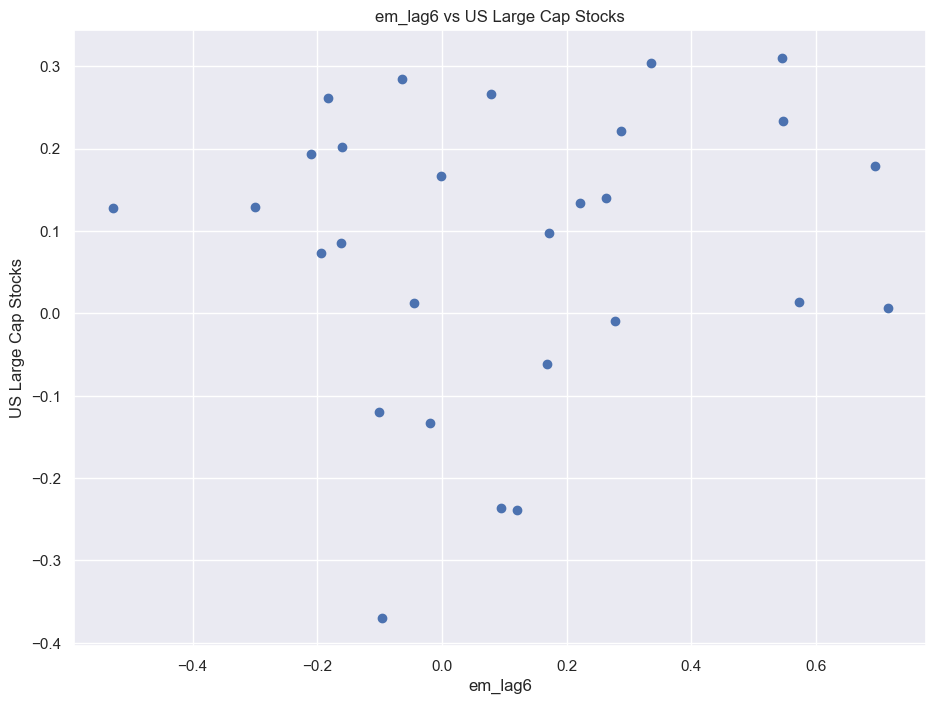

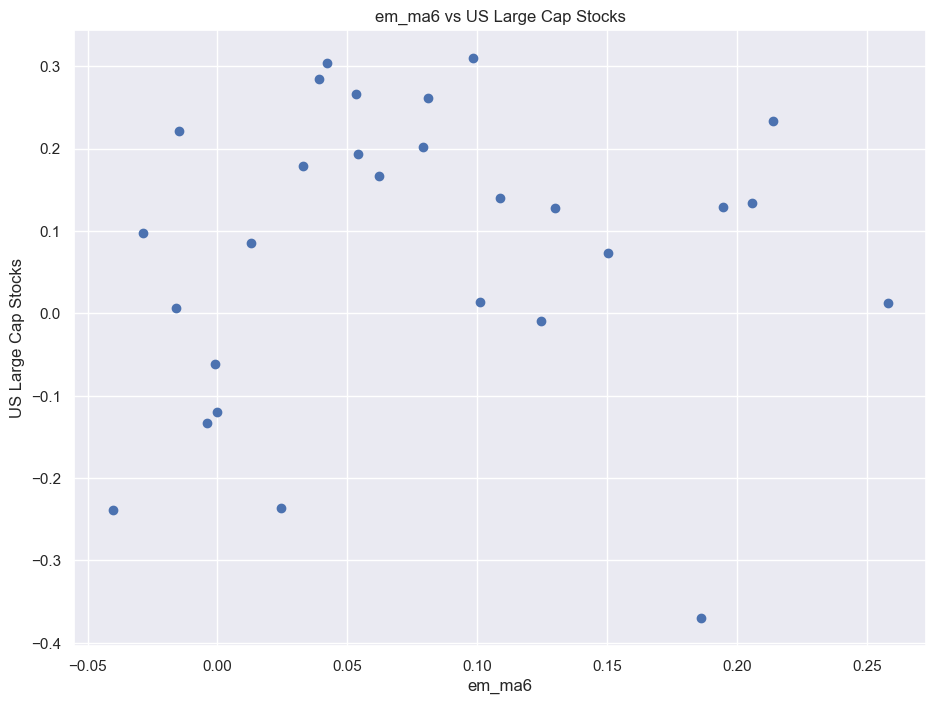

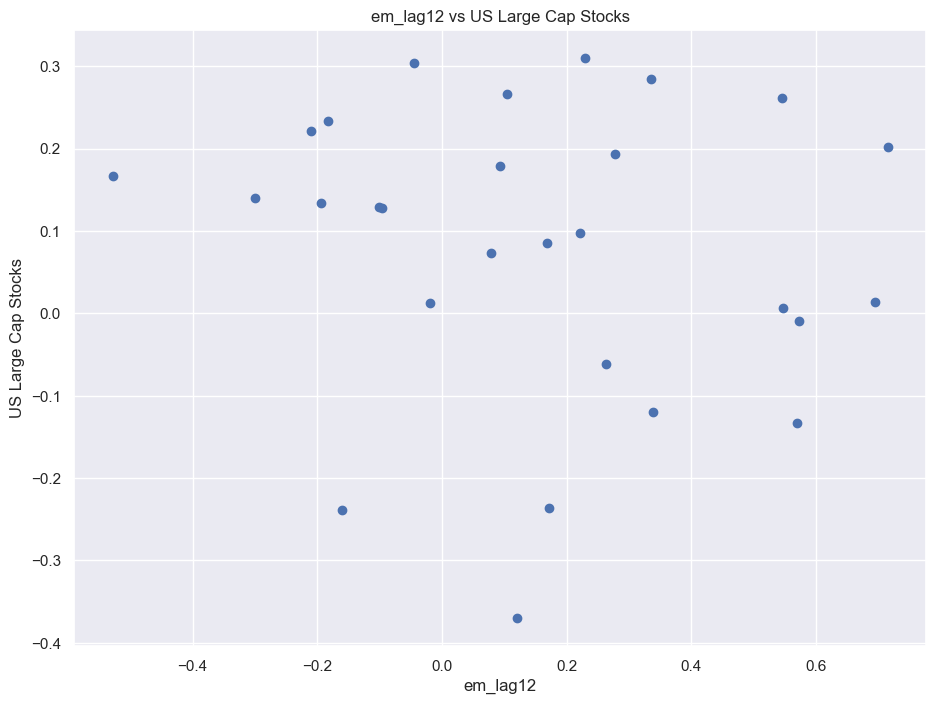

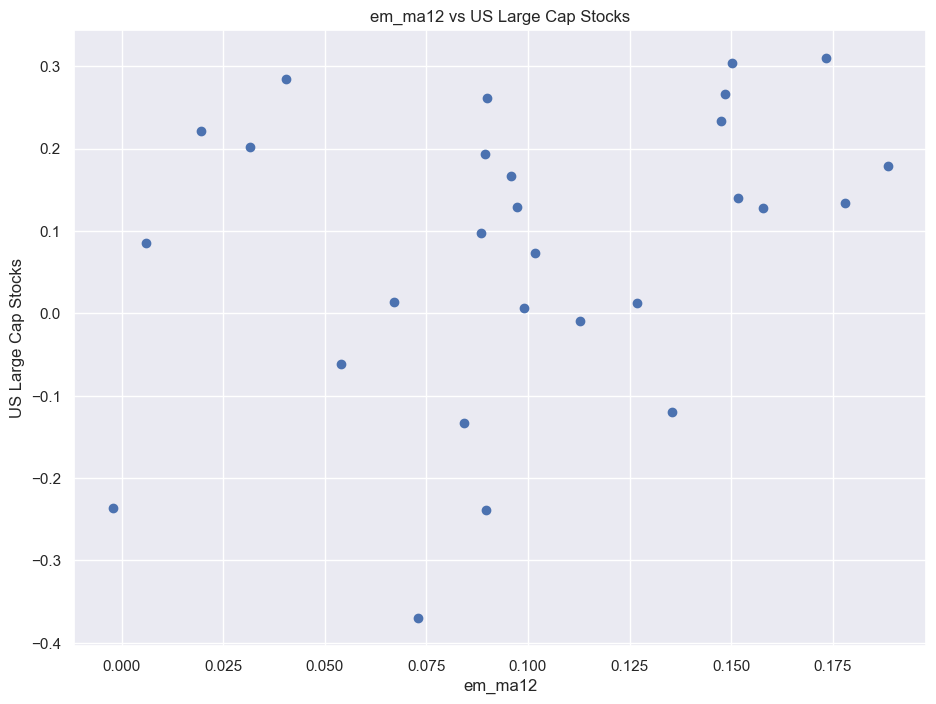

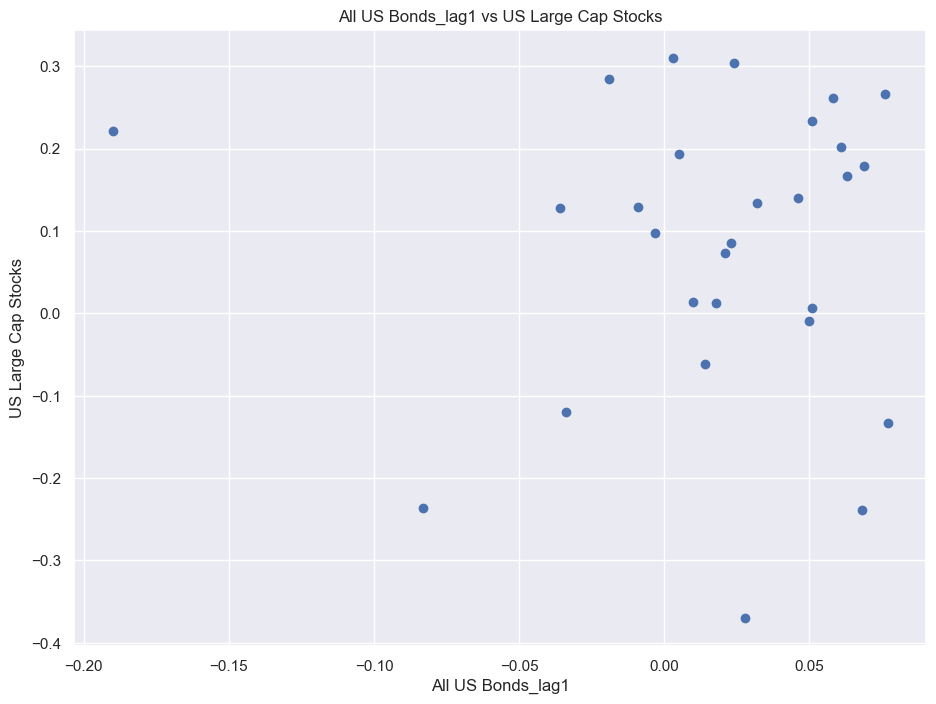

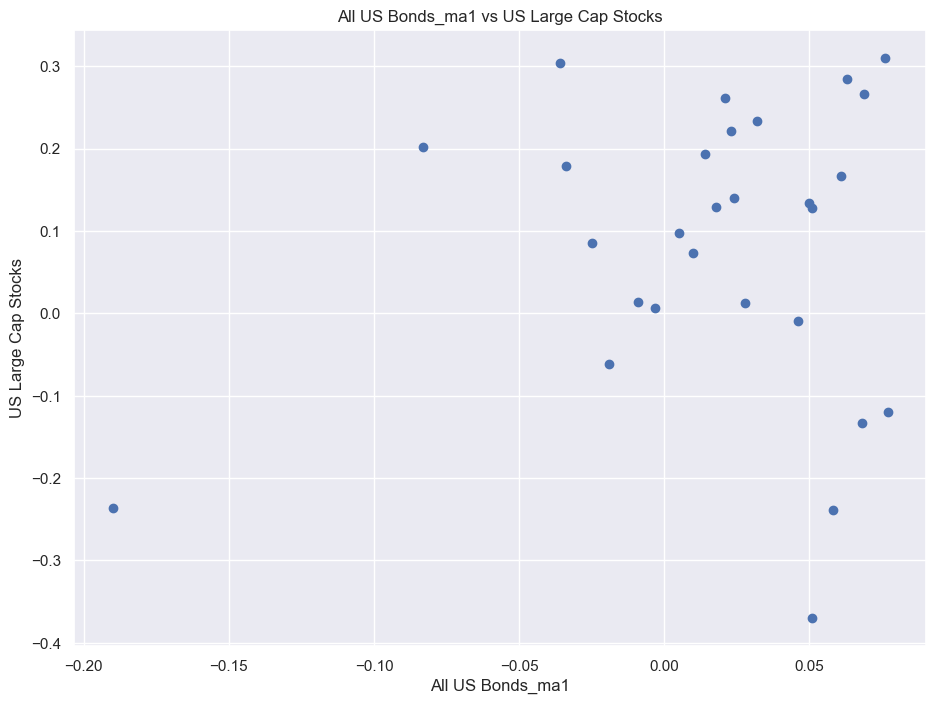

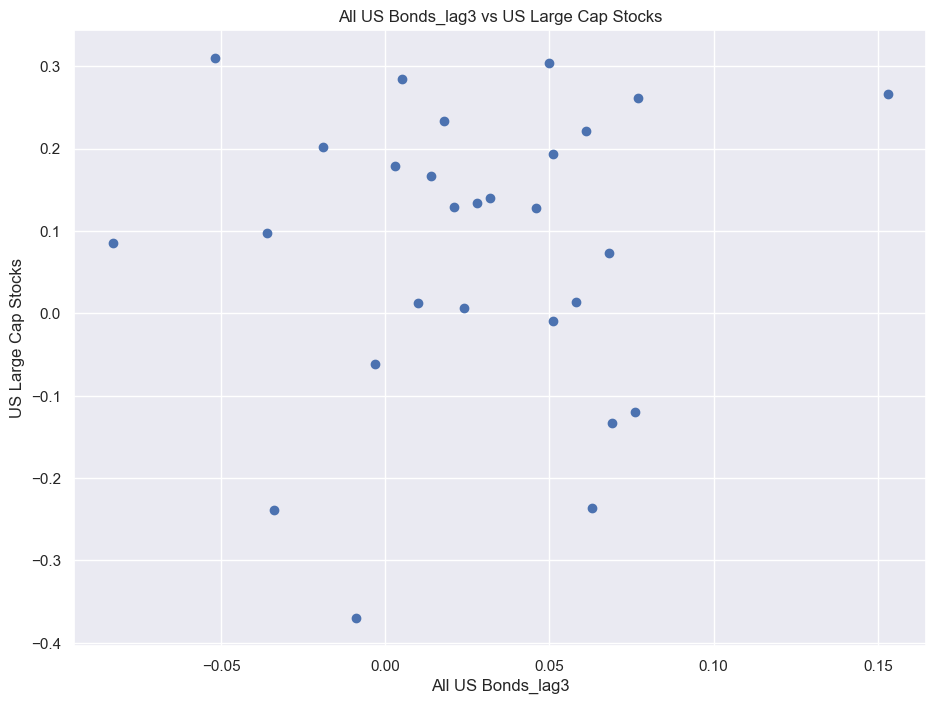

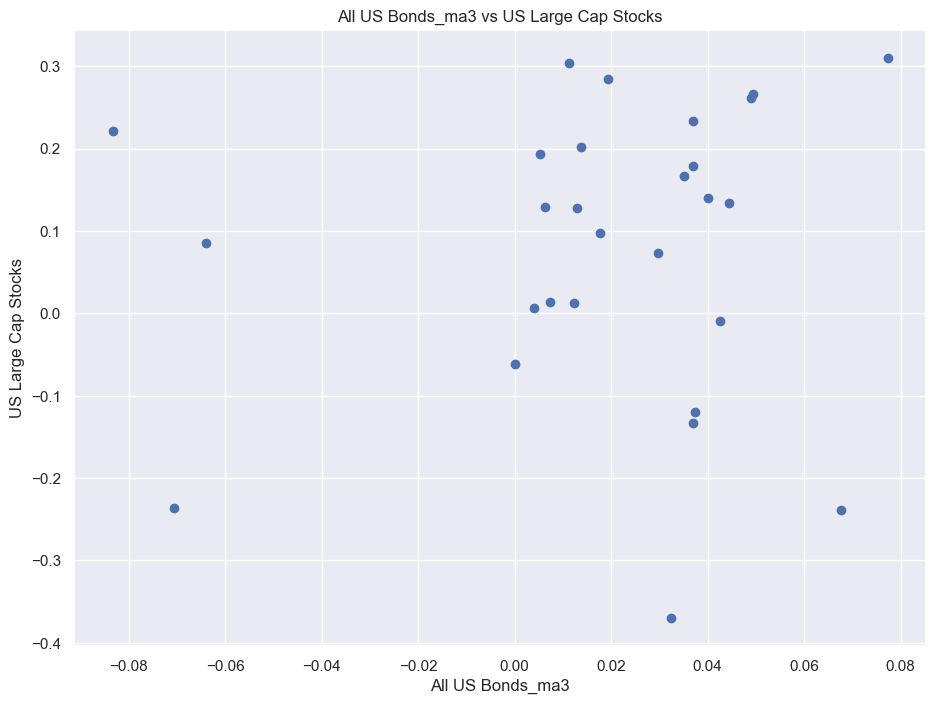

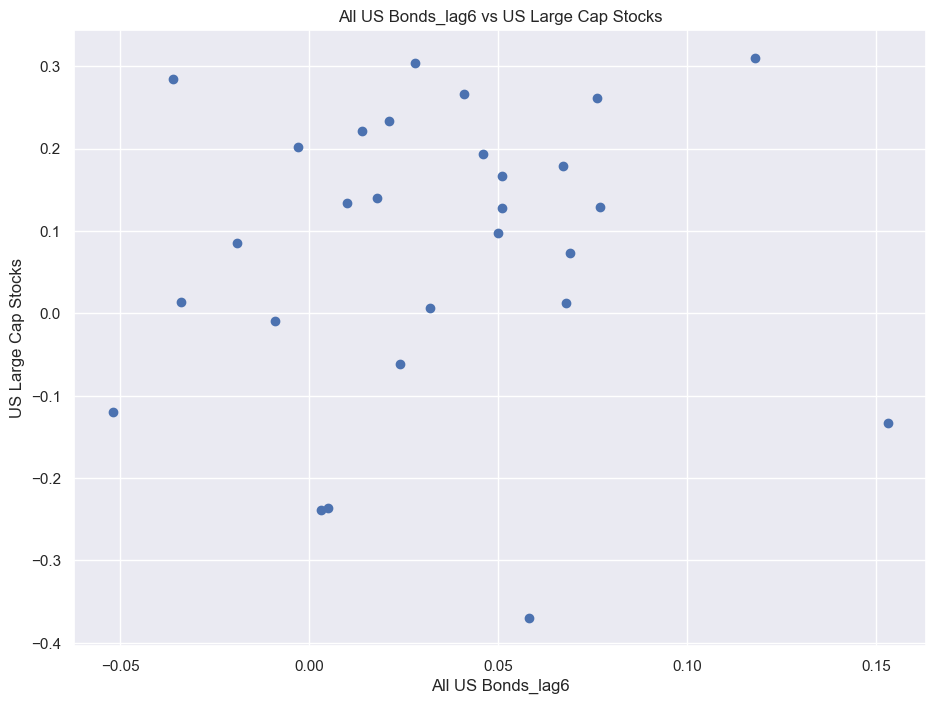

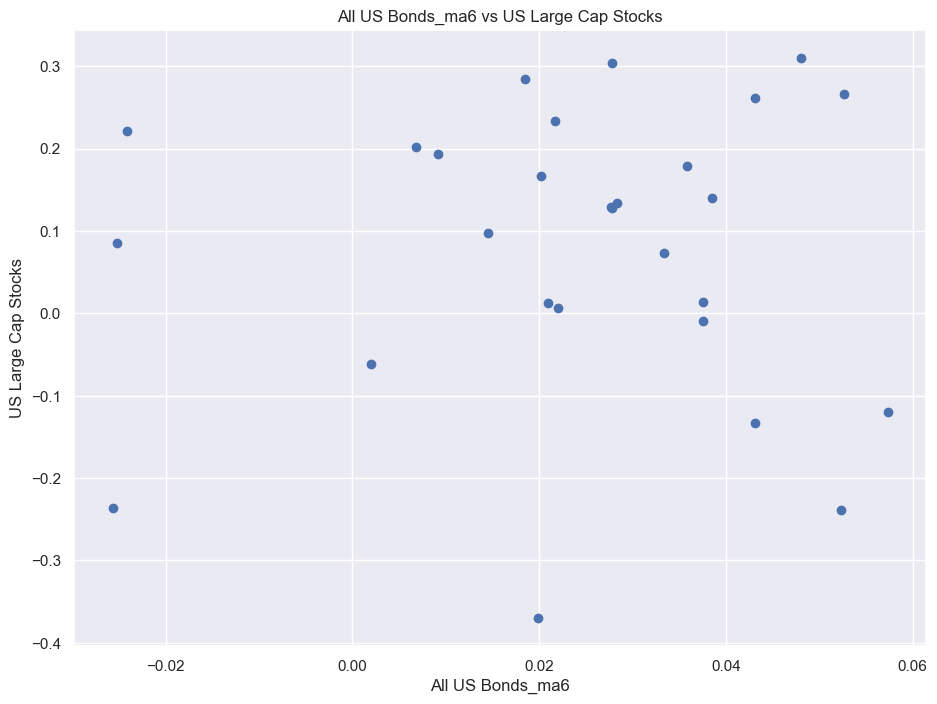

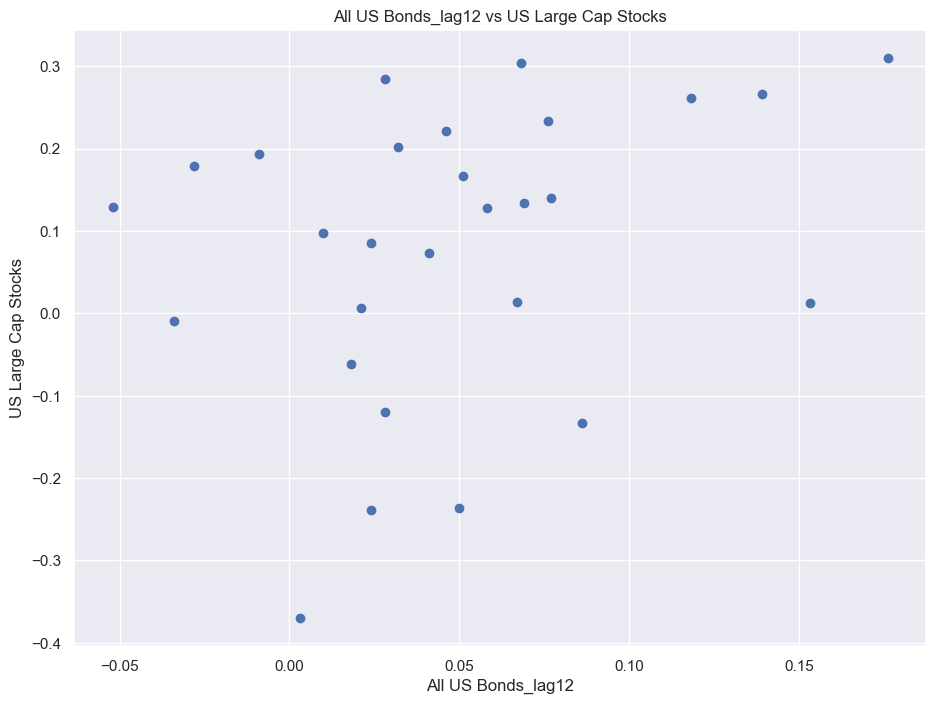

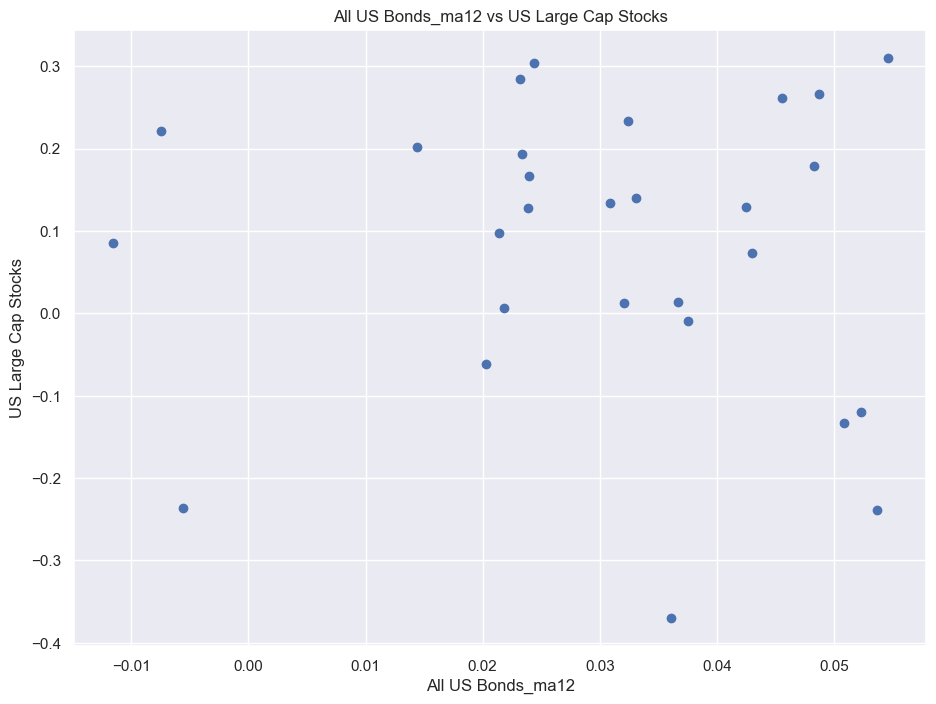

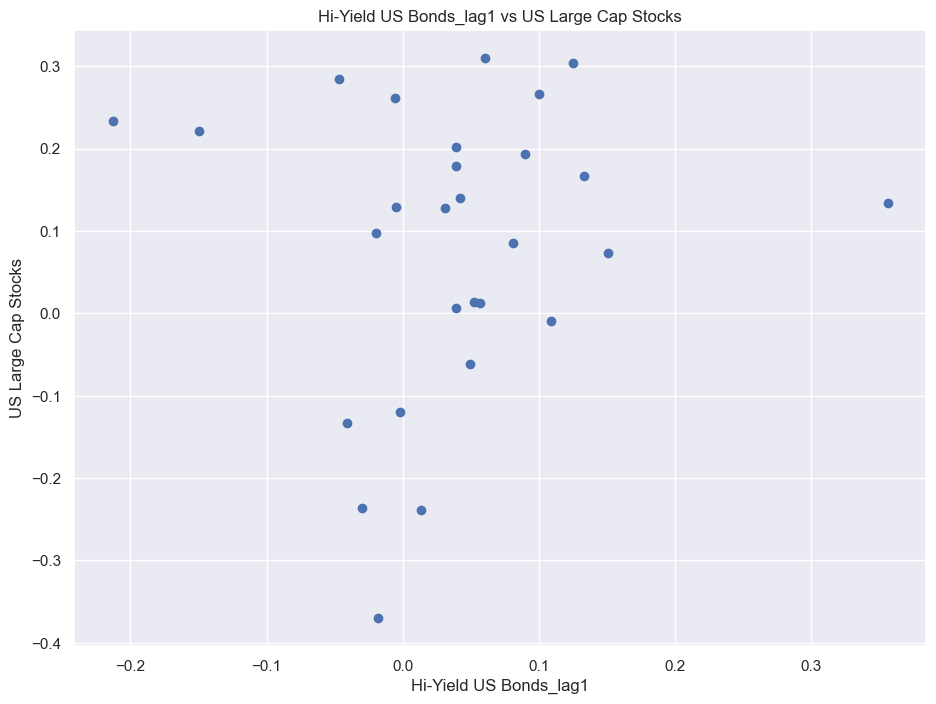

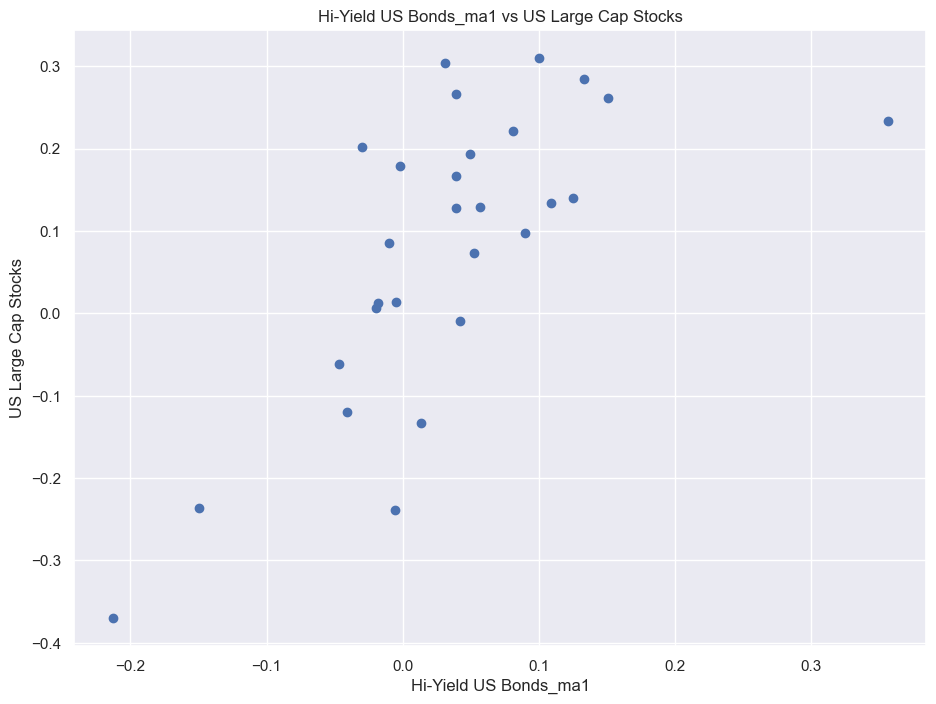

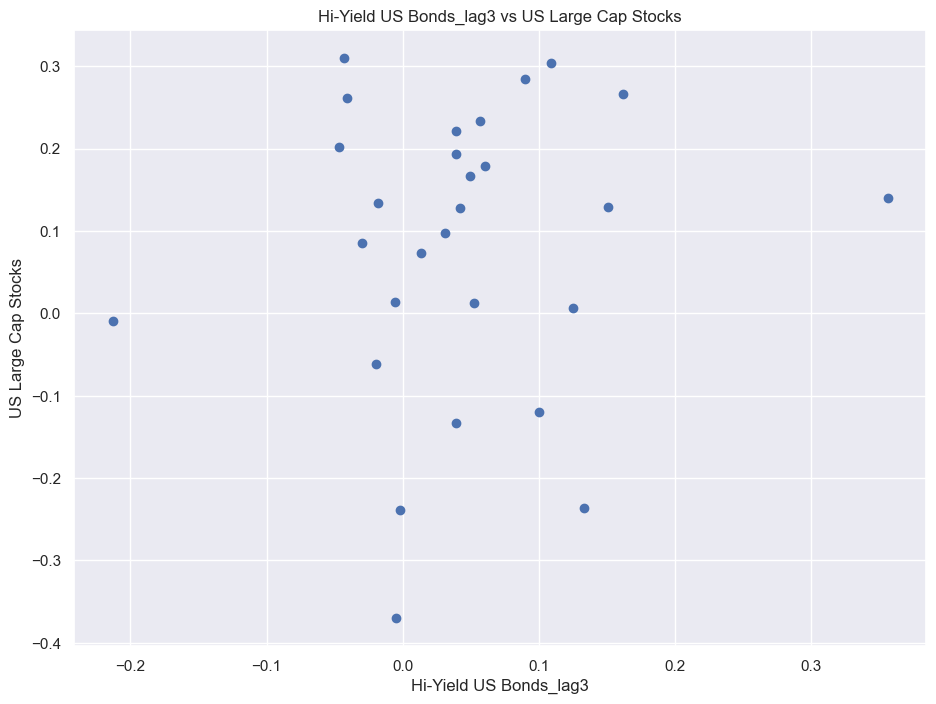

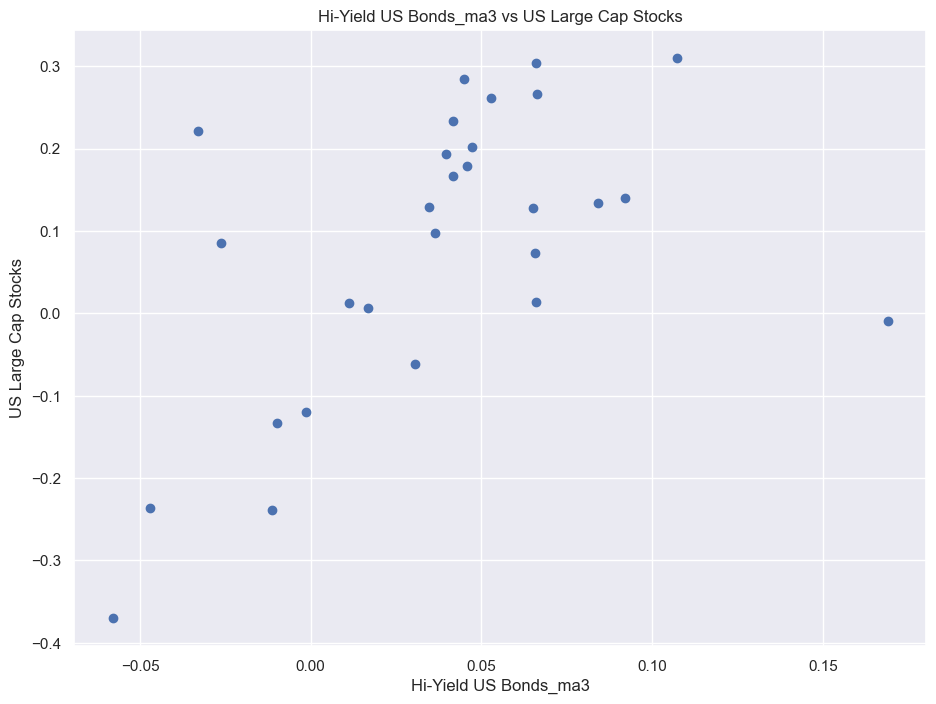

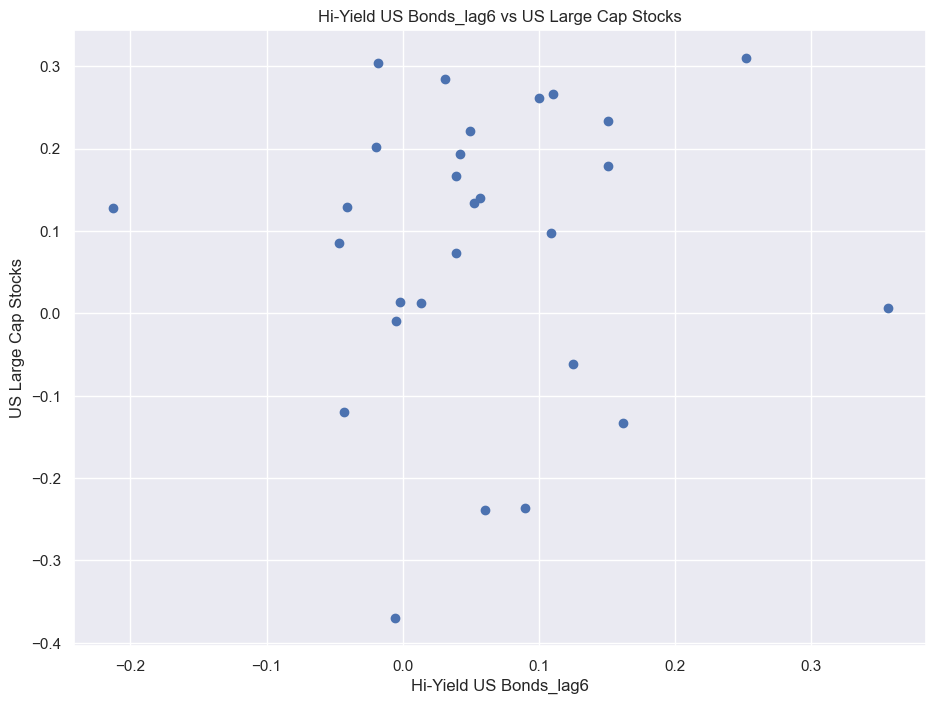

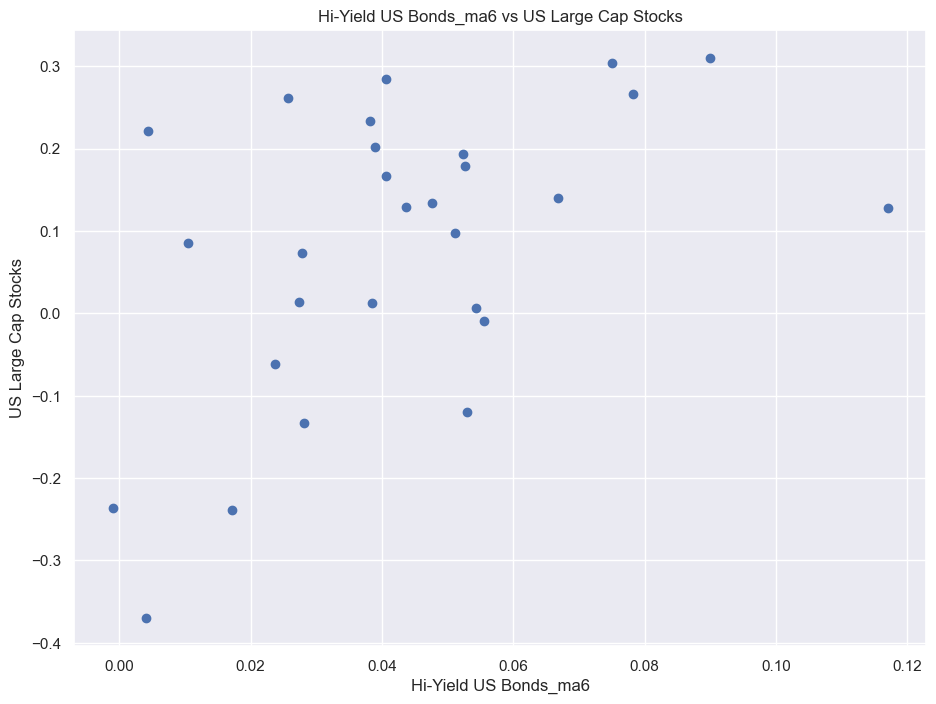

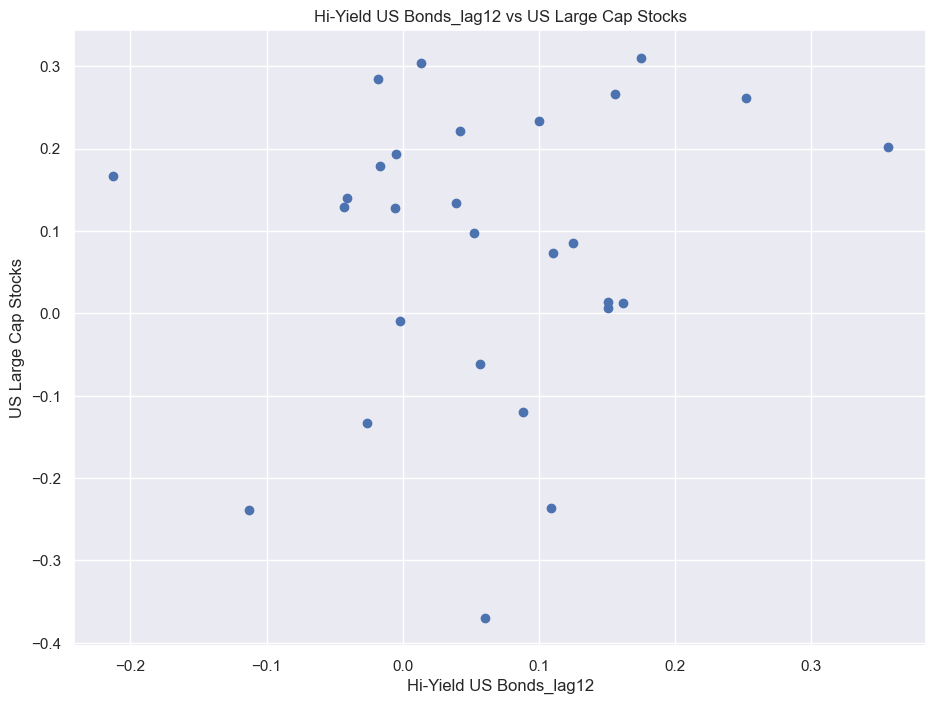

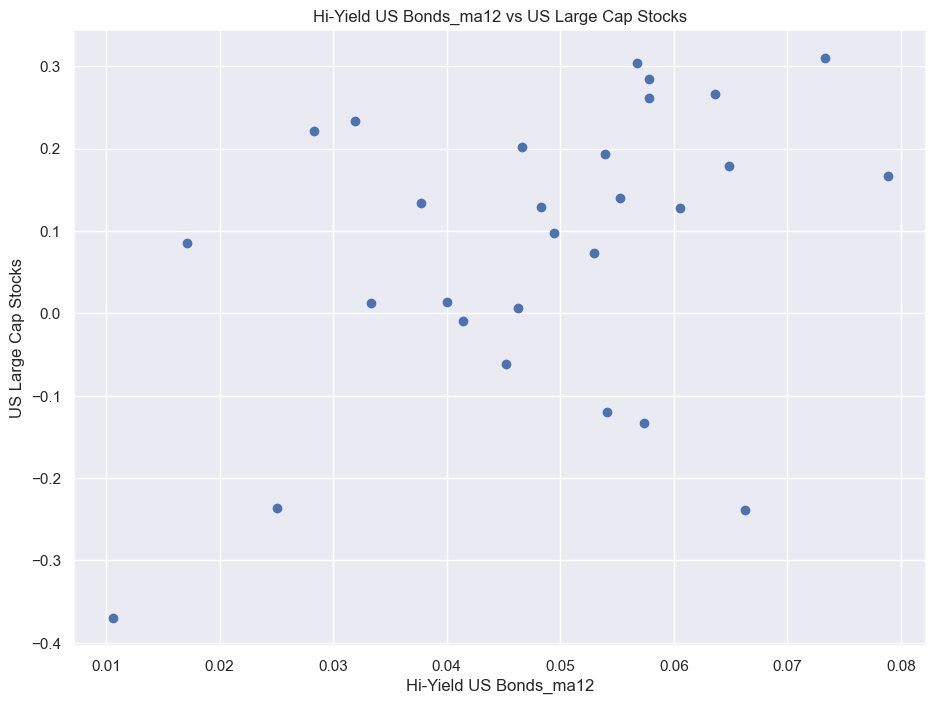

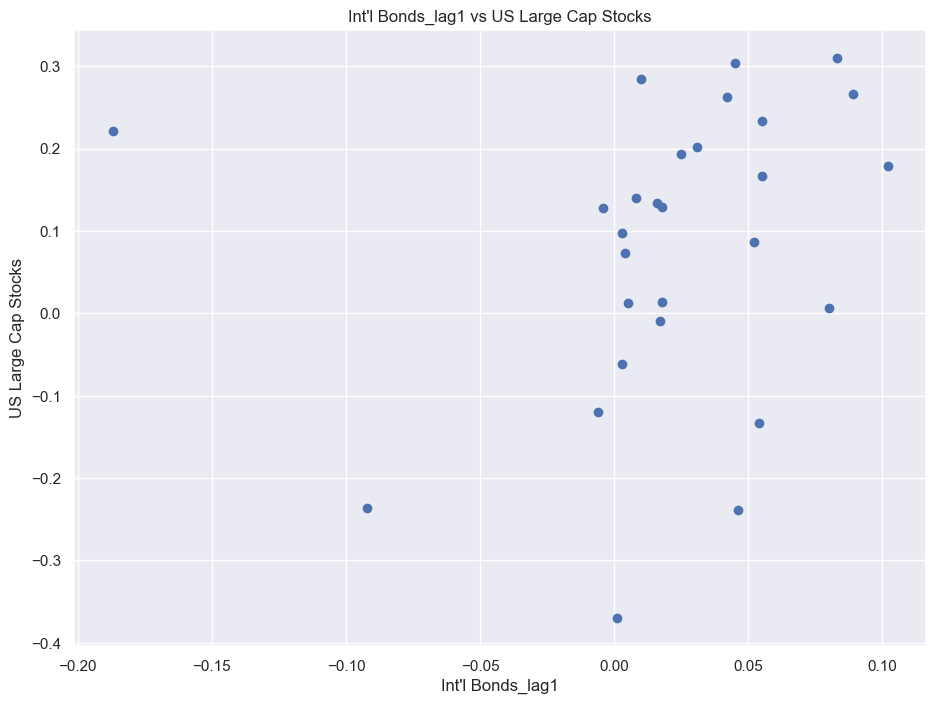

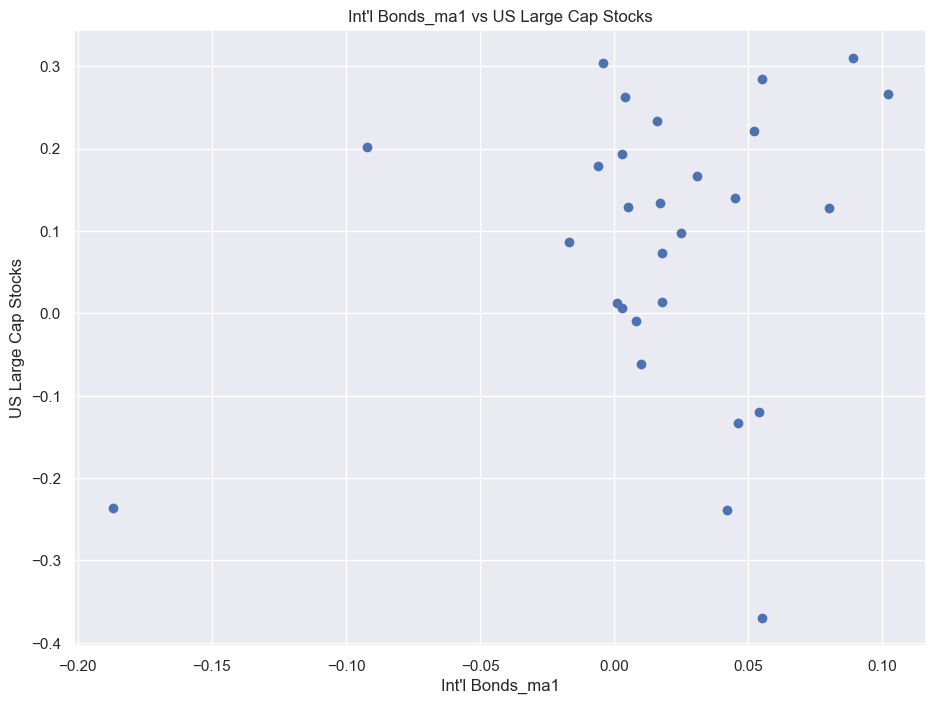

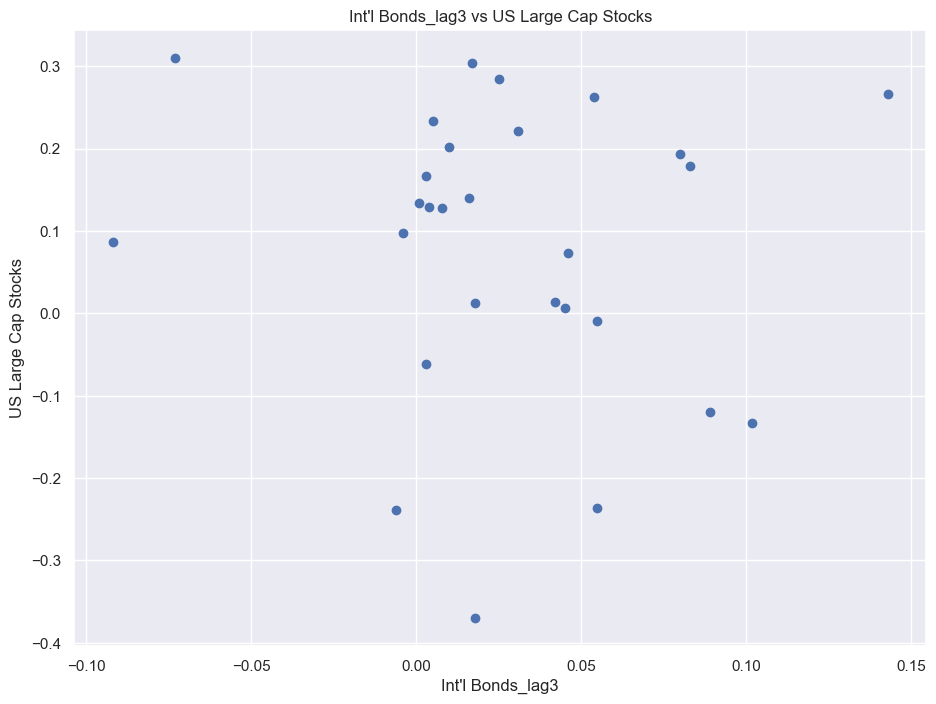

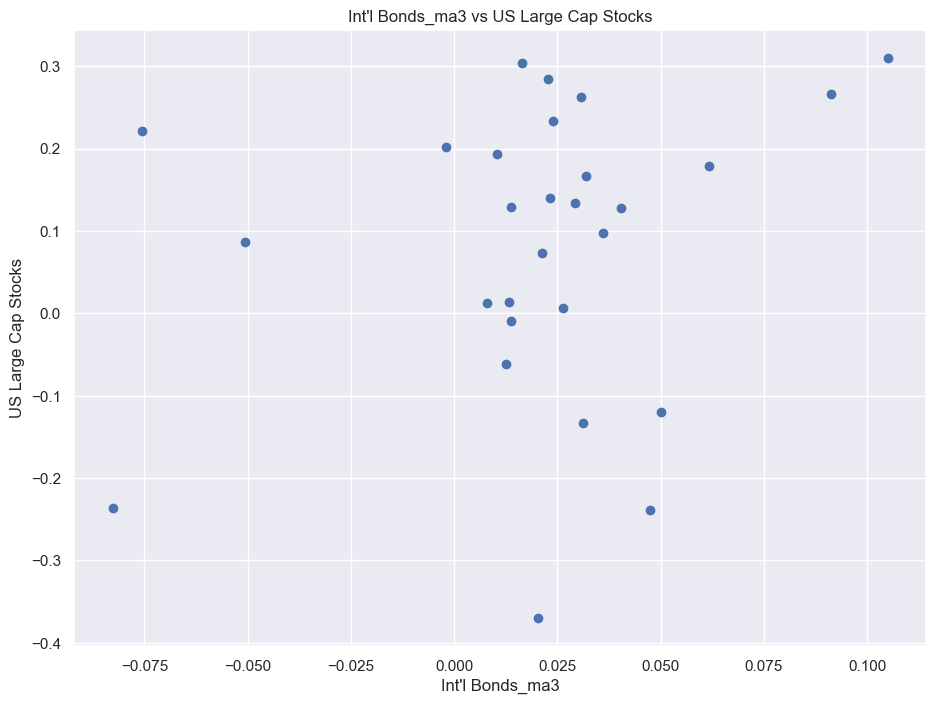

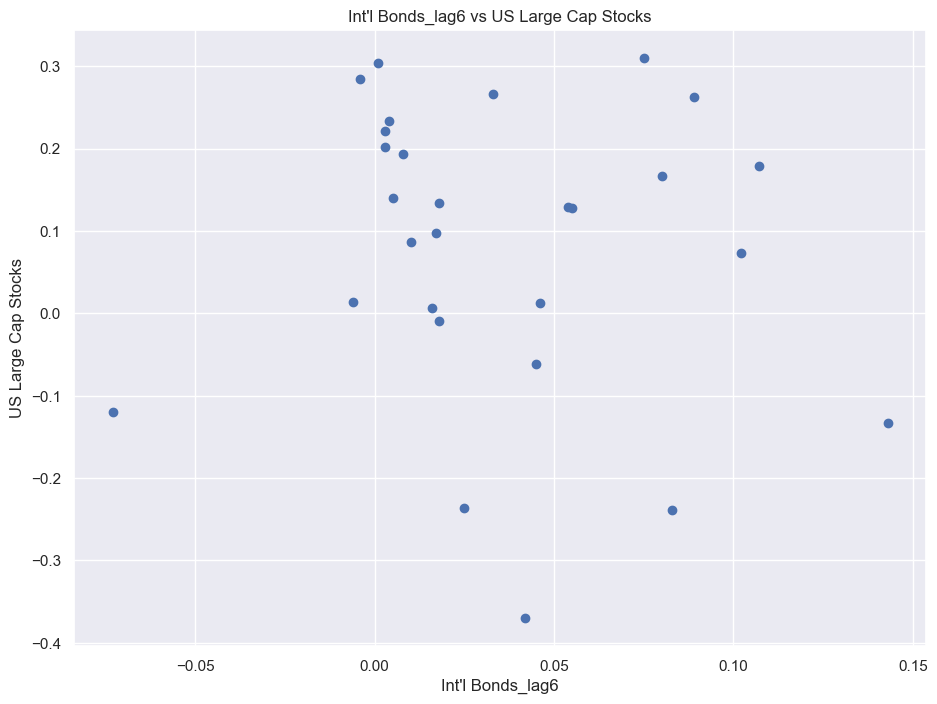

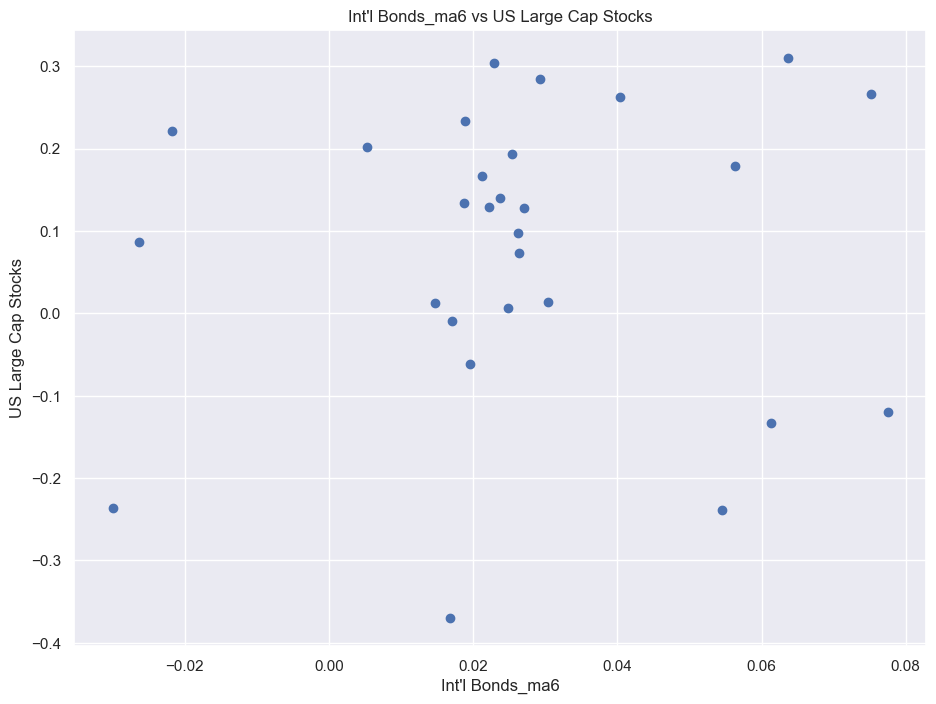

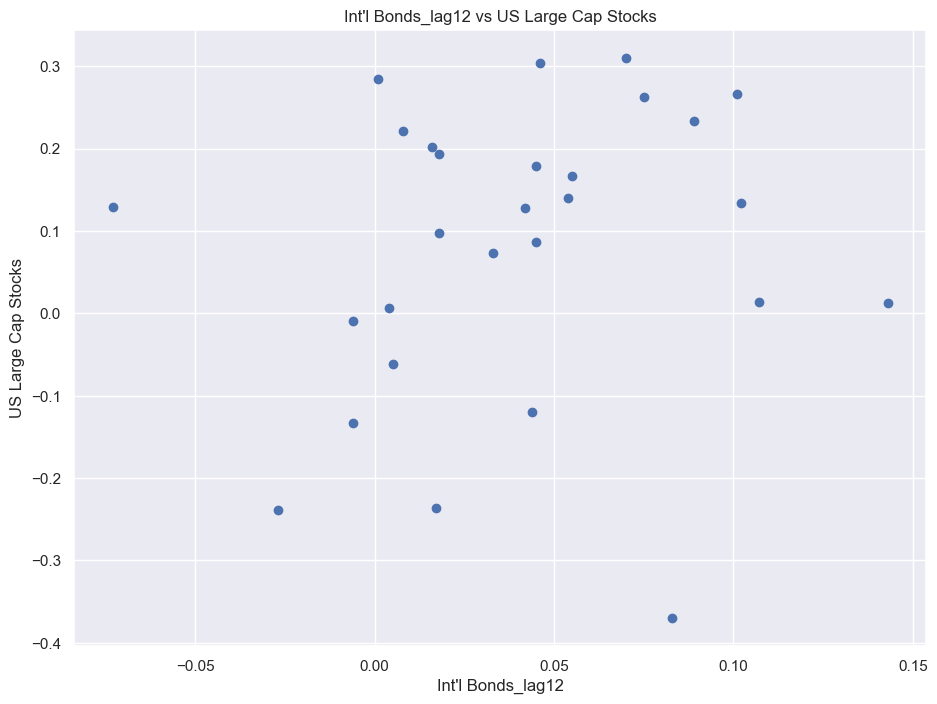

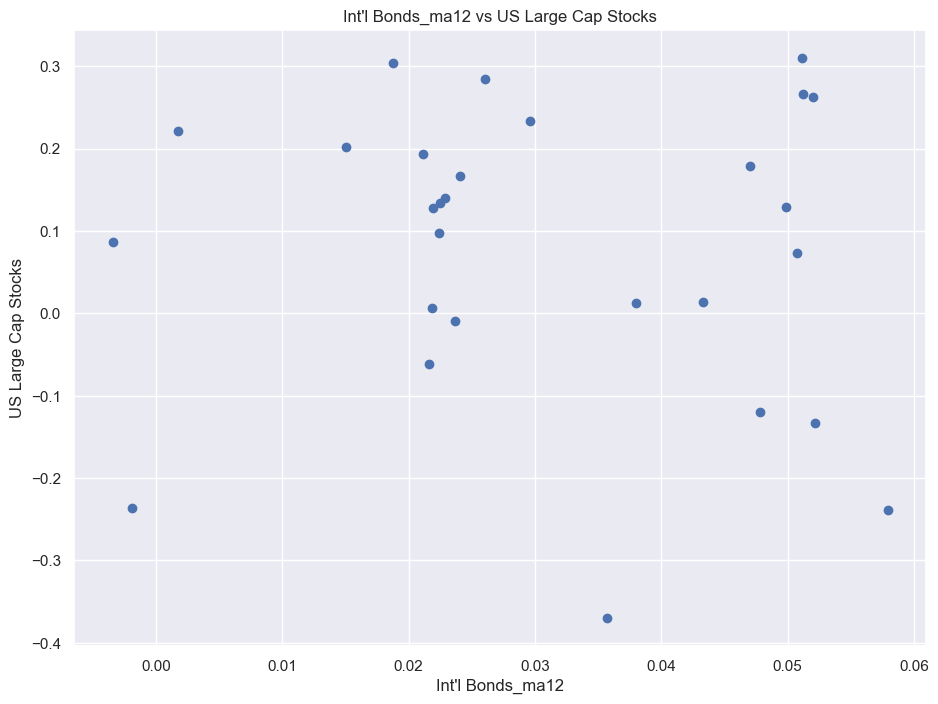

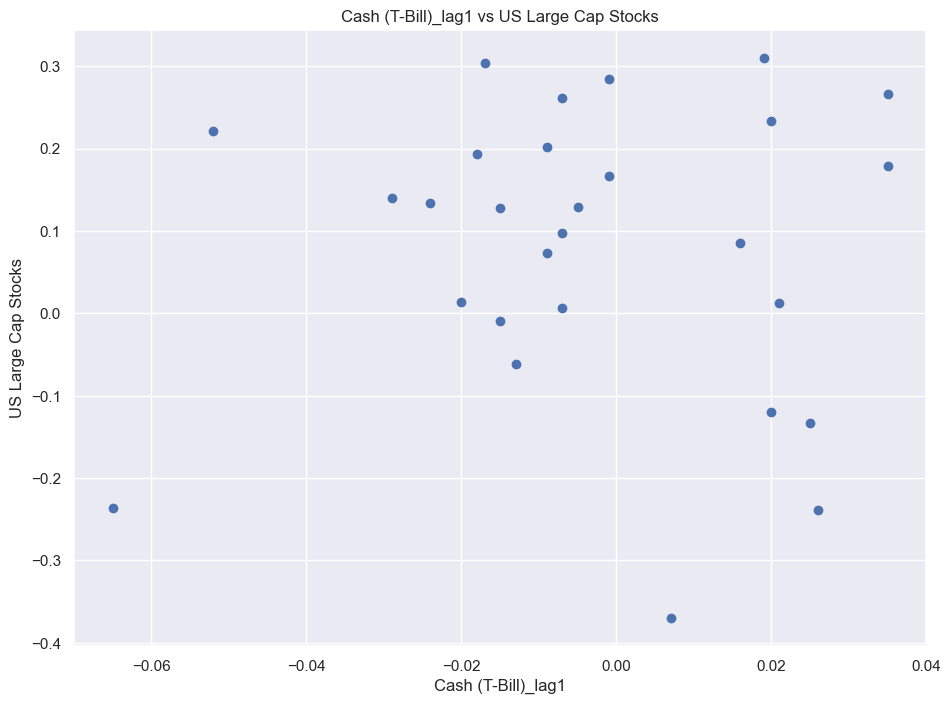

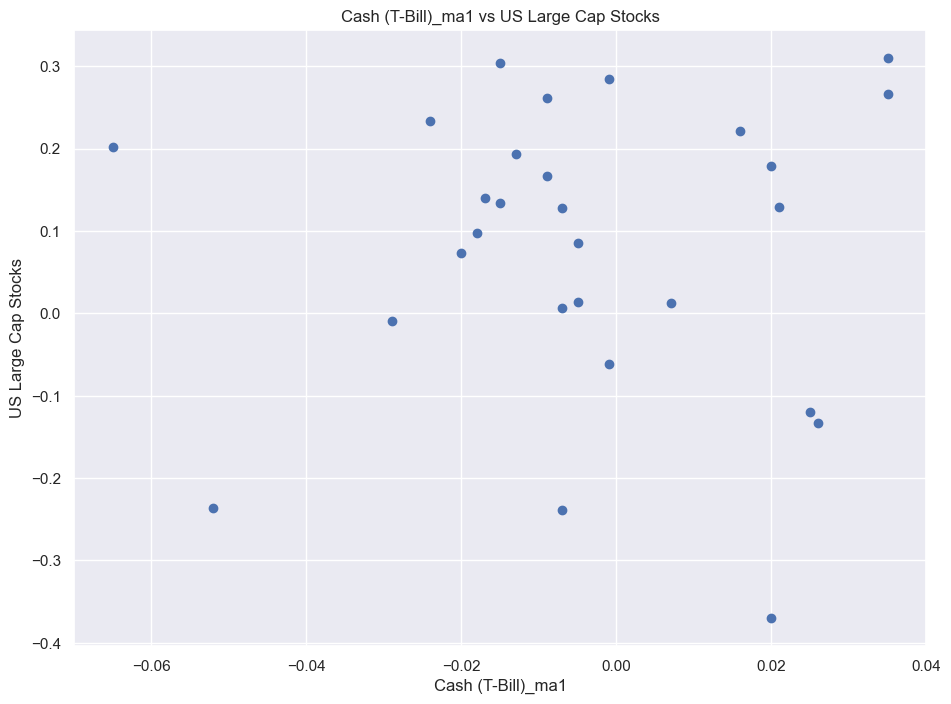

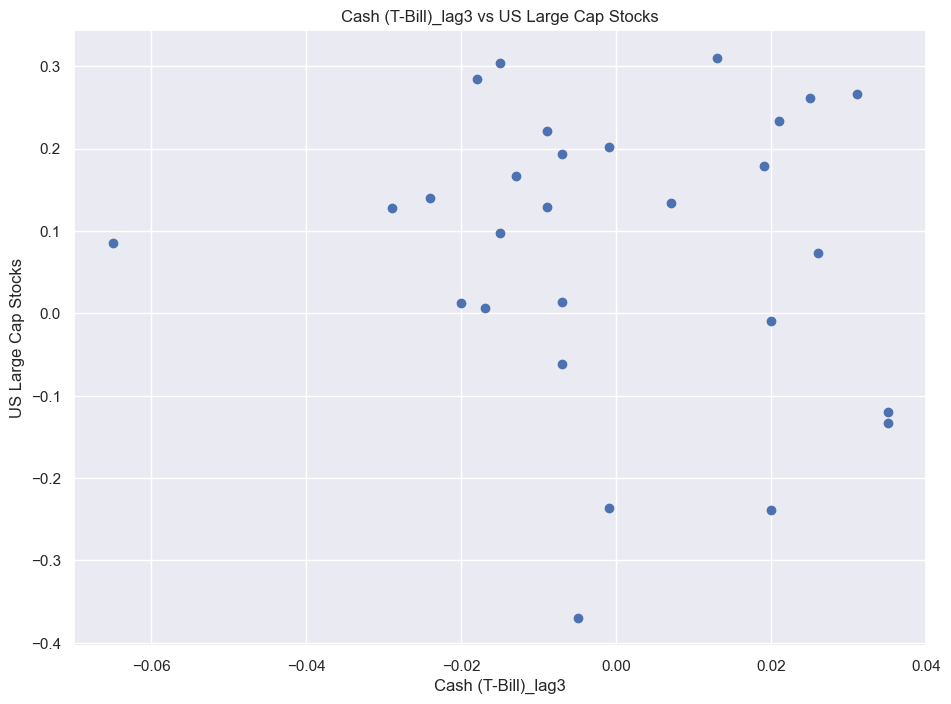

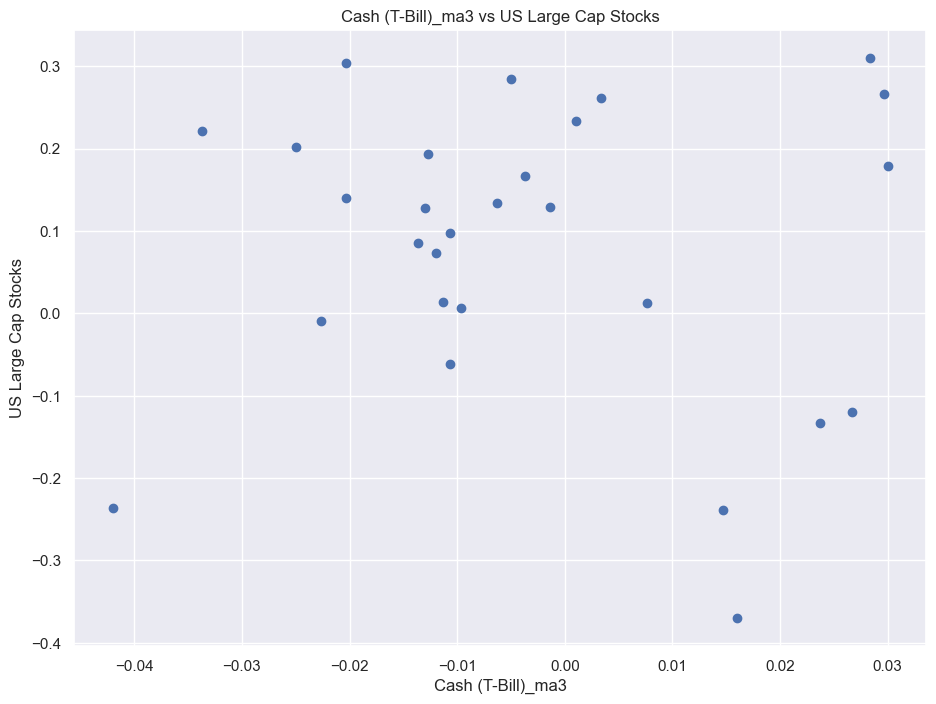

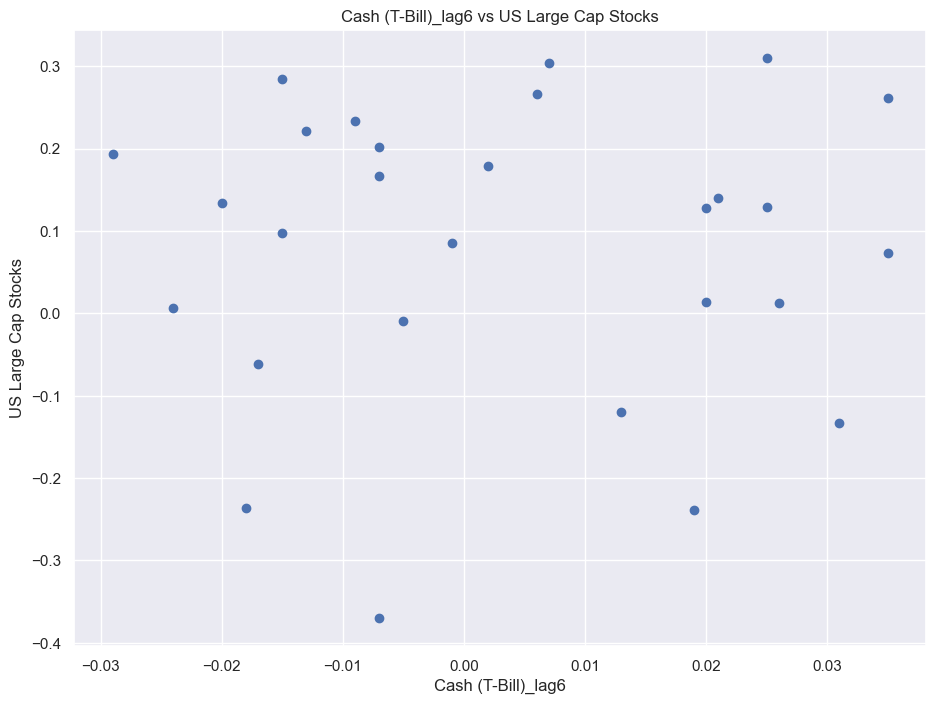

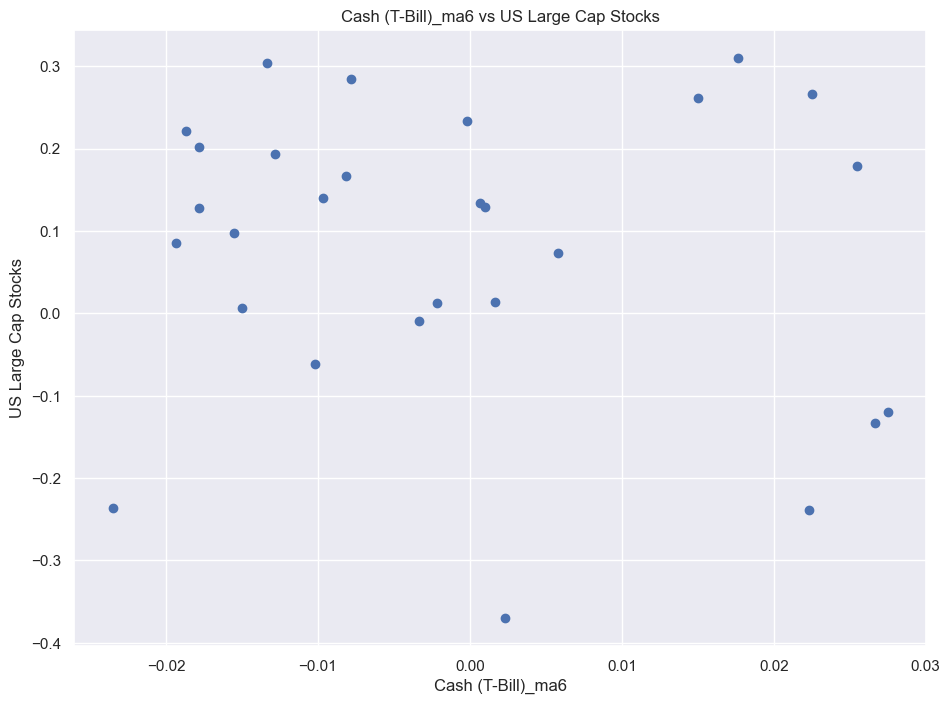

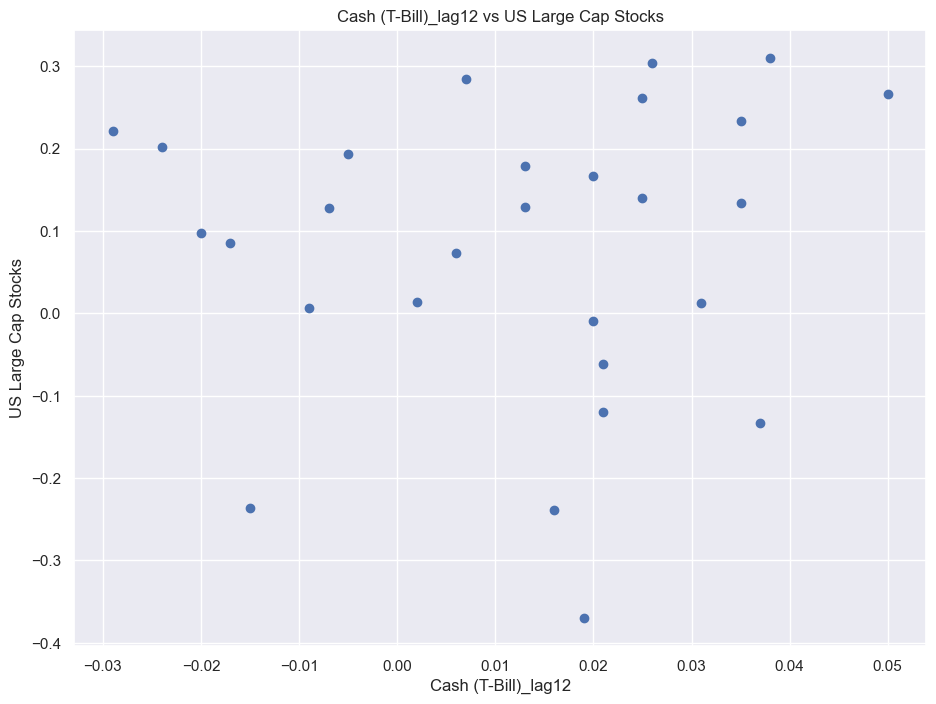

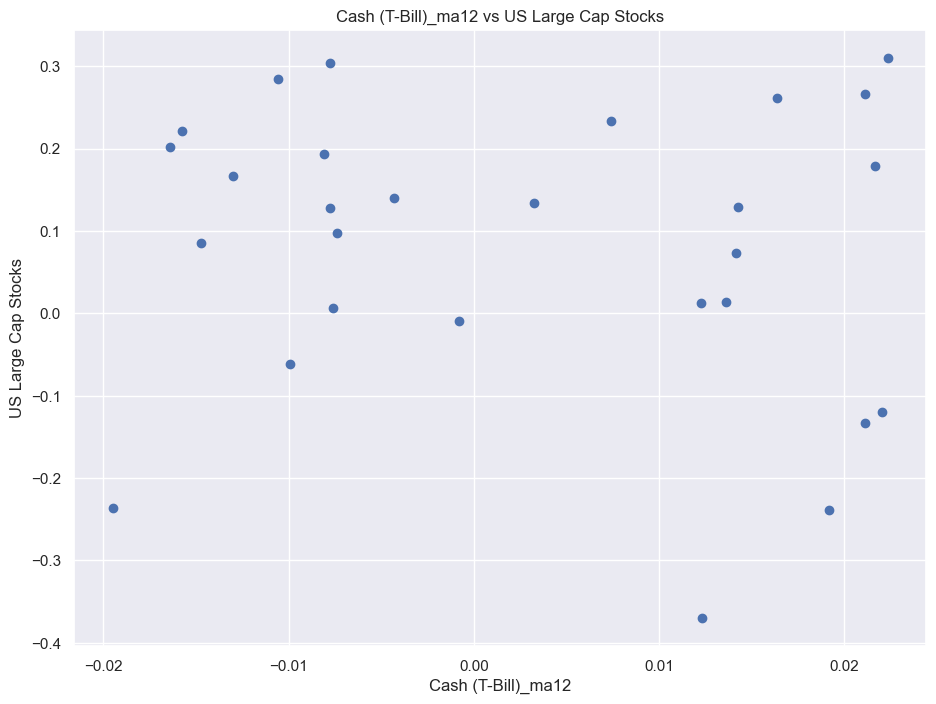

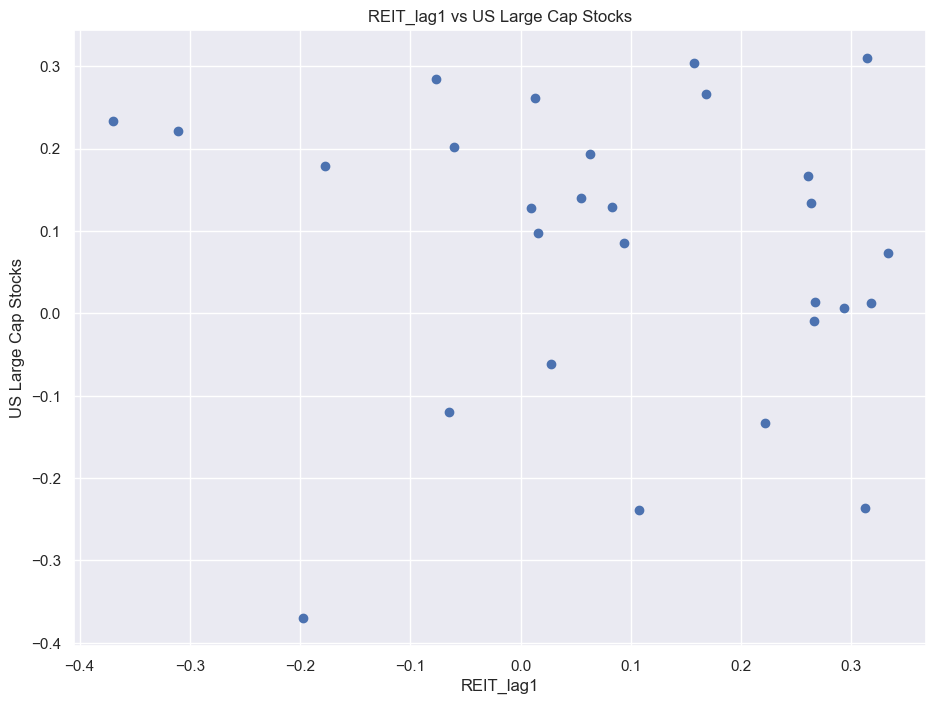

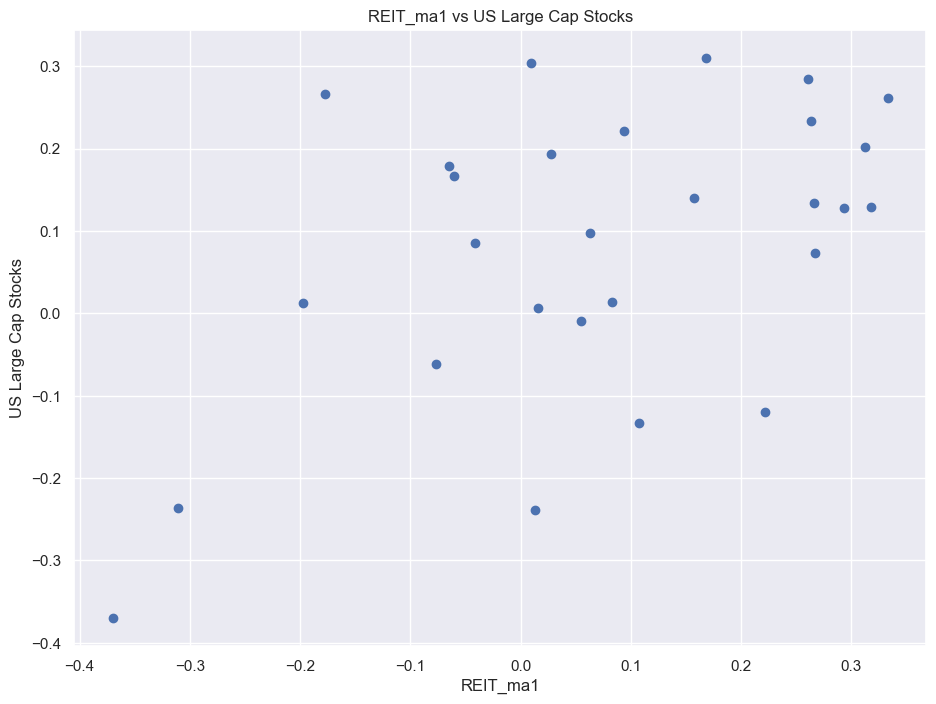

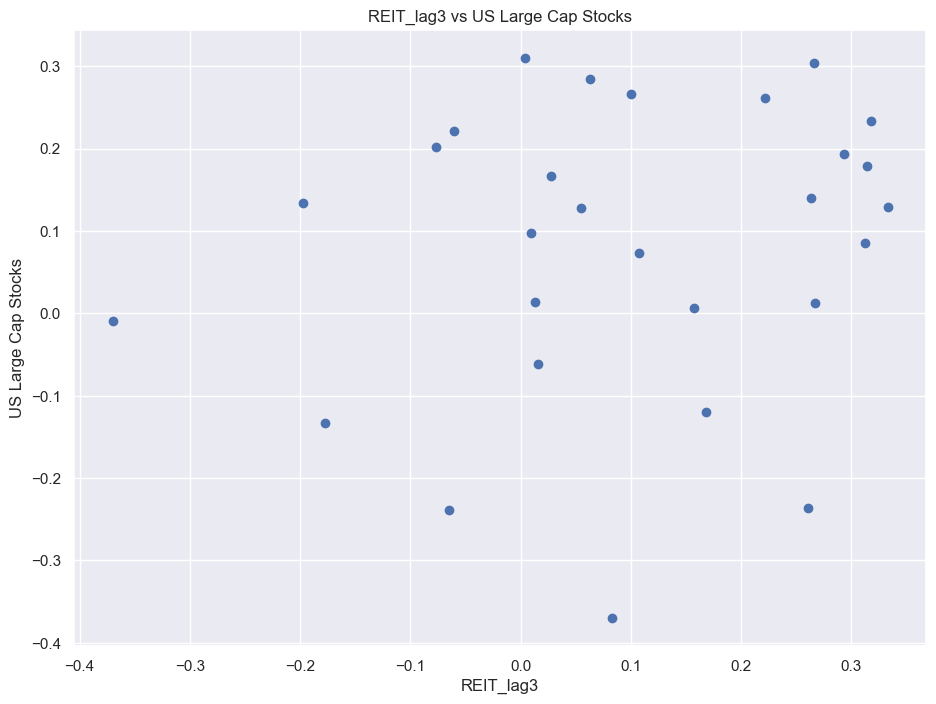

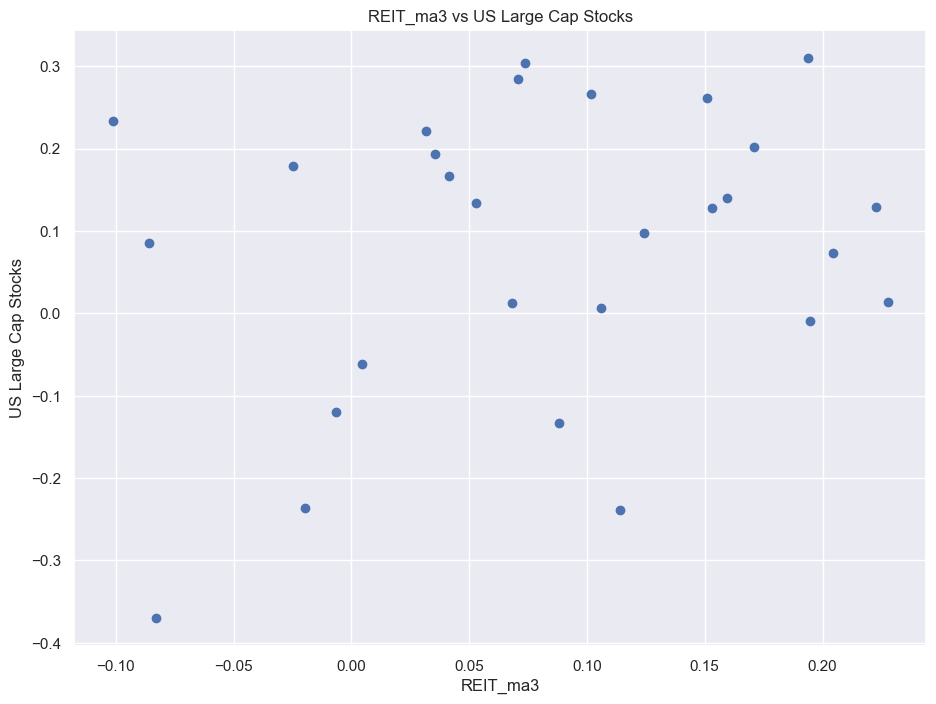

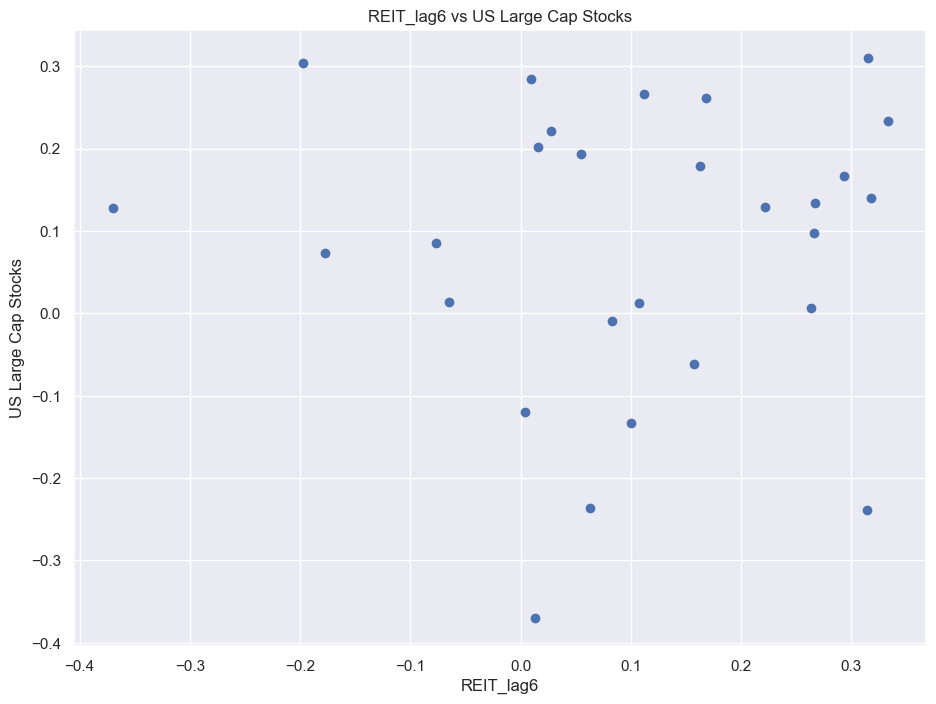

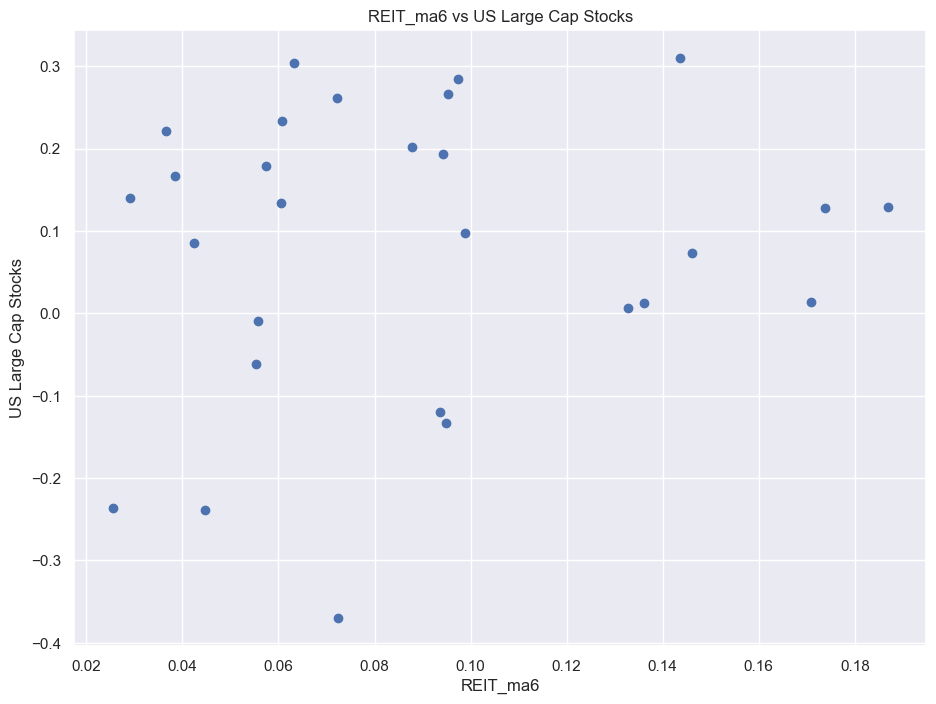

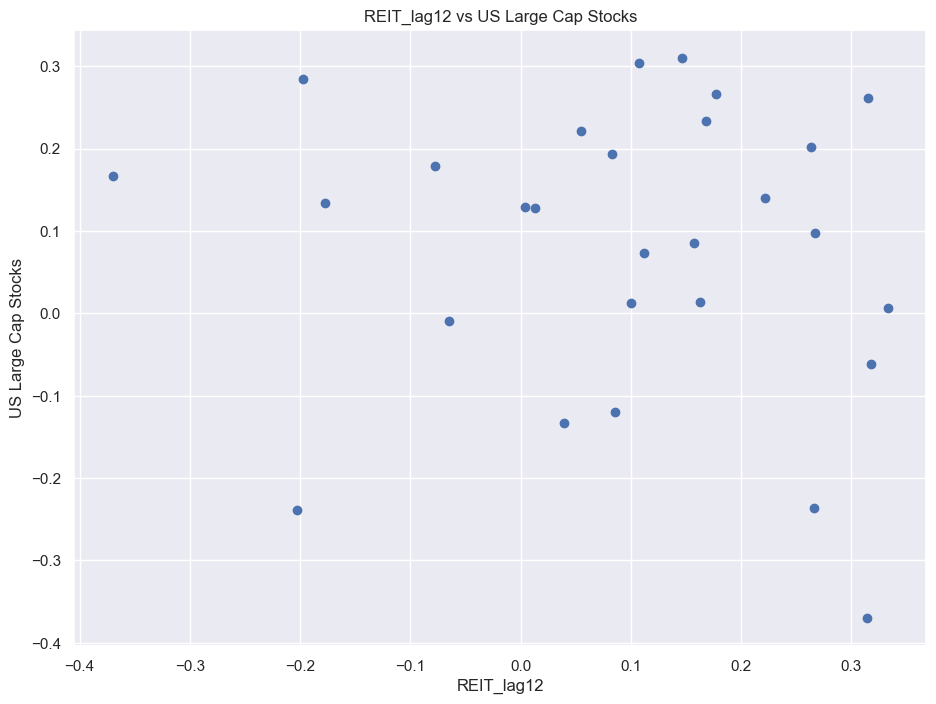

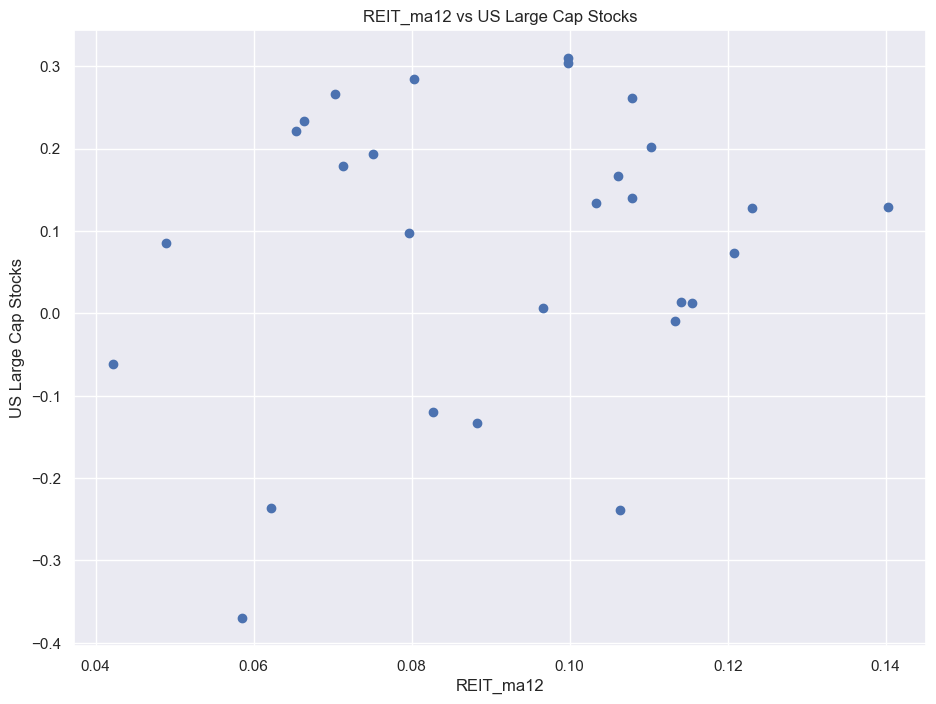

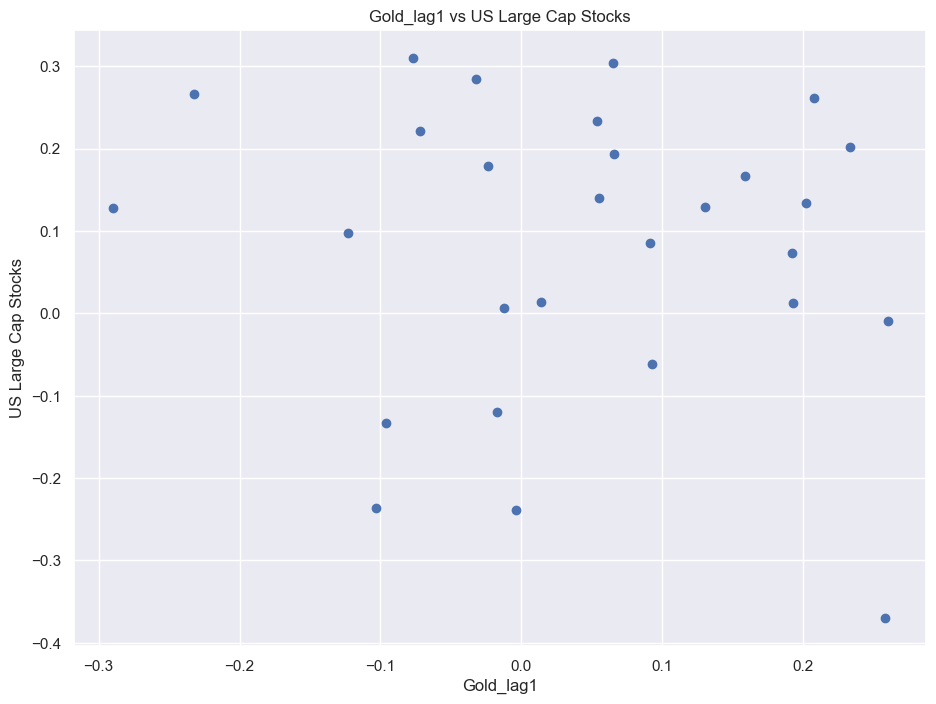

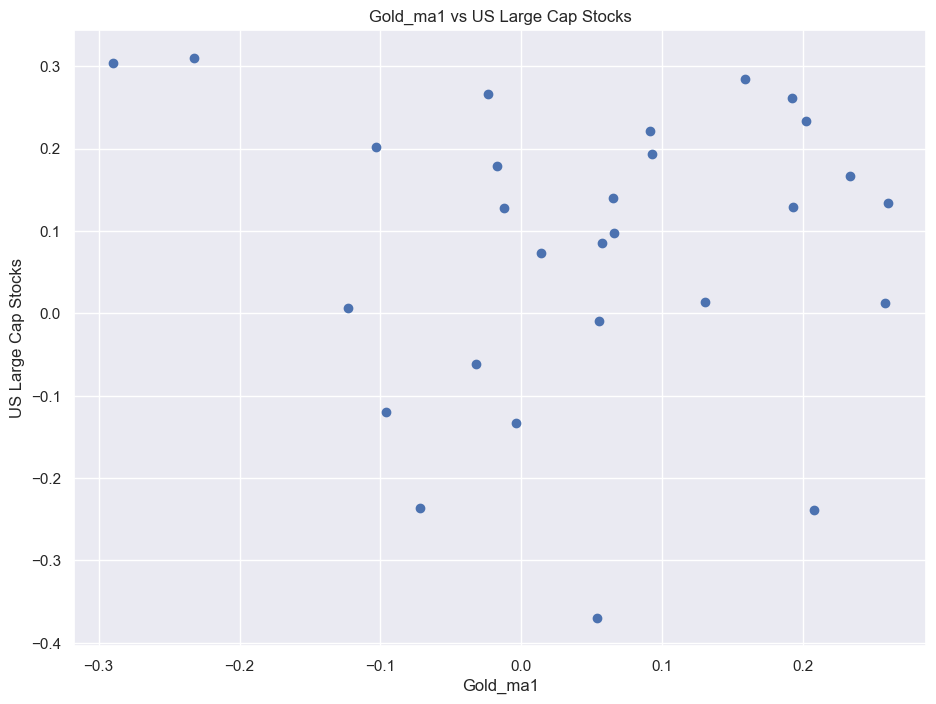

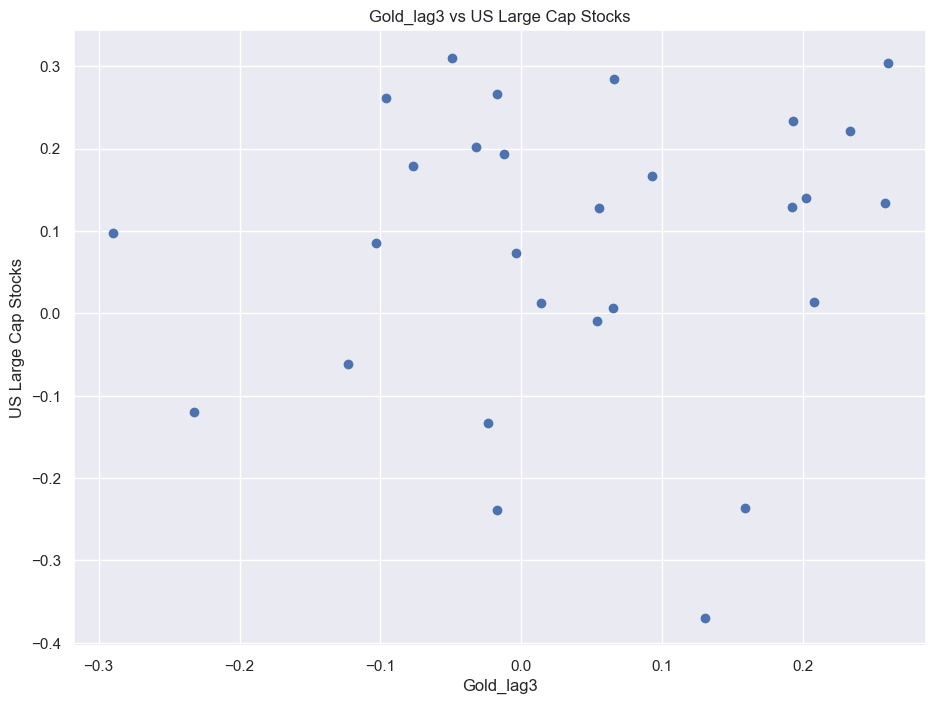

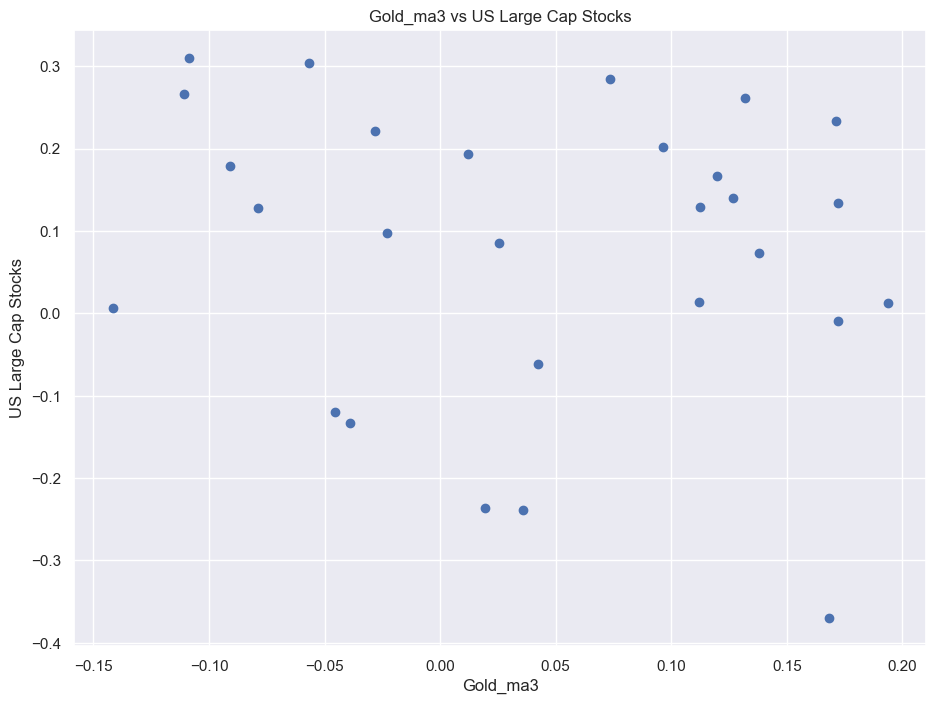

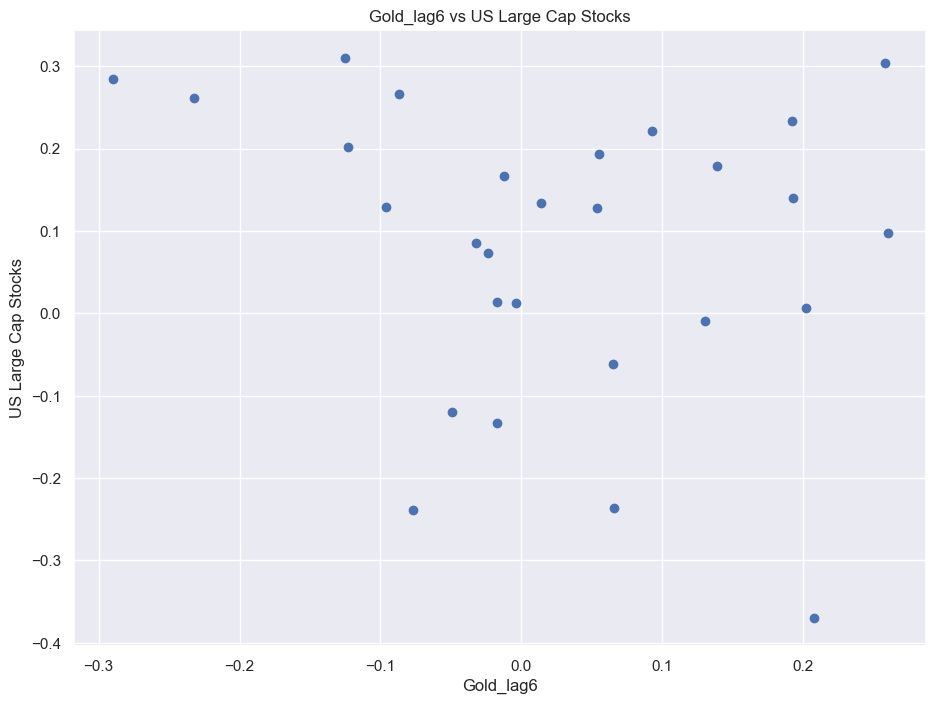

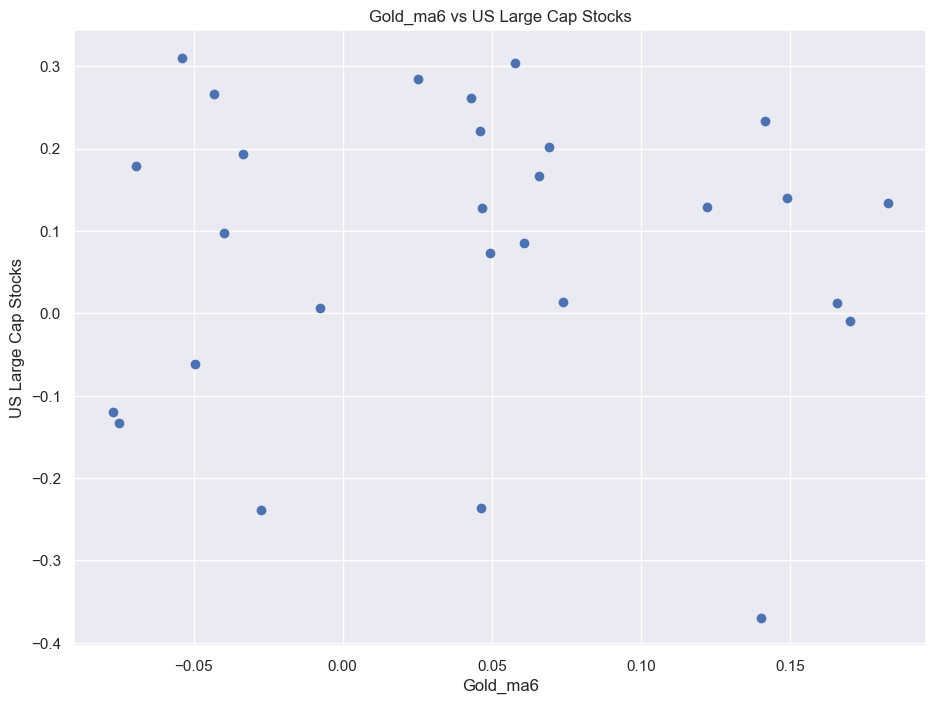

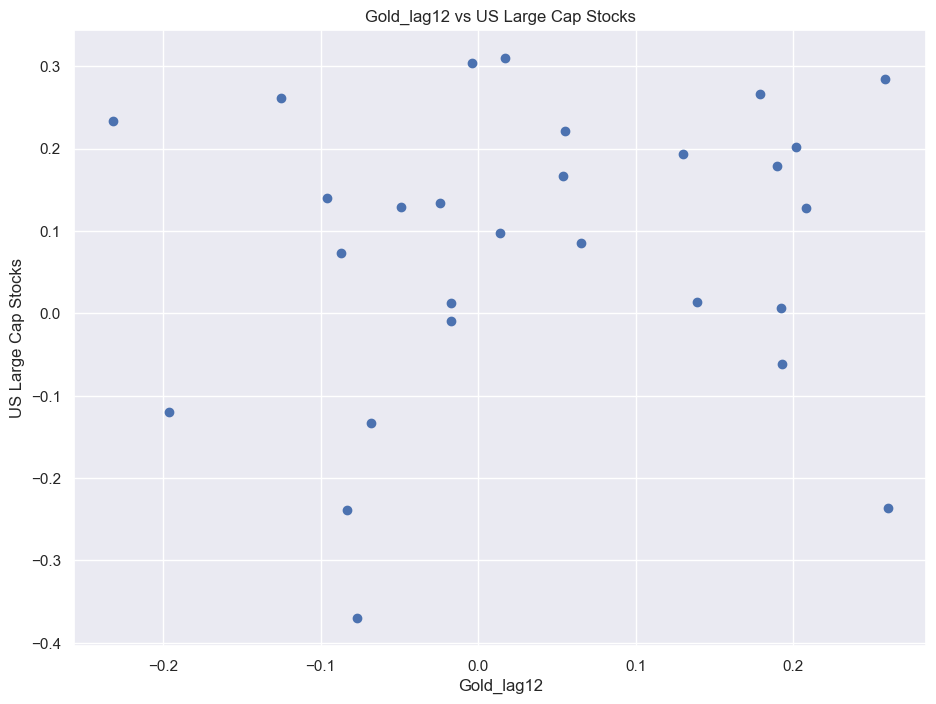

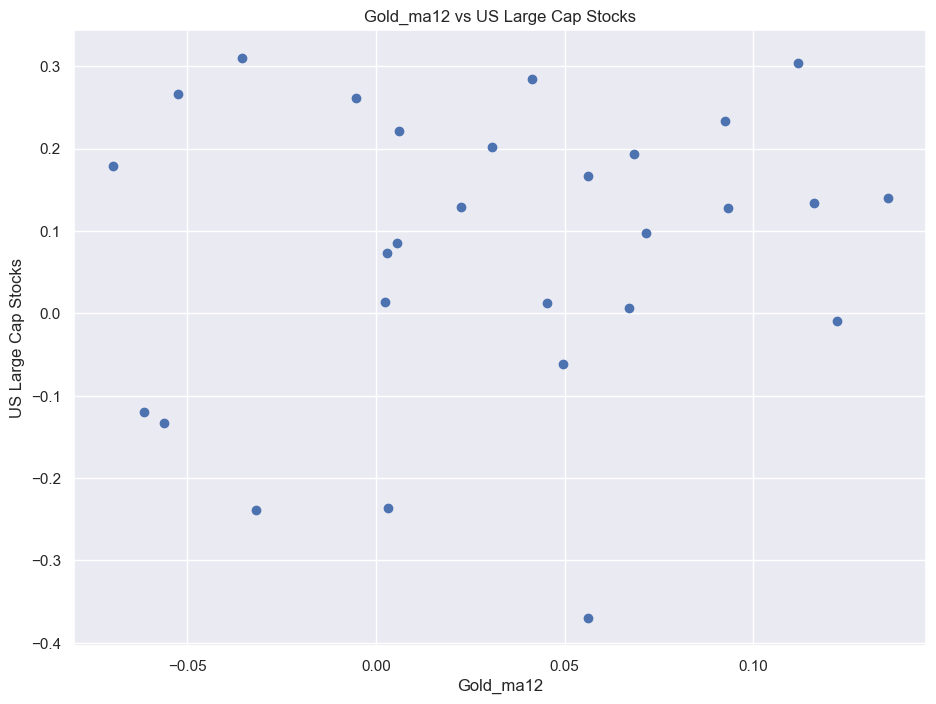

In [227]:
# Scatter plots for key variables
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

for col in numeric_cols:
    if col != 'year':
        plt.figure()
        plt.scatter(df[col], df['uslc'])
        plt.xlabel(col)
        plt.ylabel('US Large Cap Stocks')
        plt.title(f'{col} vs US Large Cap Stocks')
        plt.show()

- CPIAUCSL (Consumer Price Index) shows a slight negative correlation with stock returns, suggesting stocks tend to underperform in high inflation environments

- The 10-year minus 2-year Treasury yield spread (T10Y2Y) has a weak positive relationship with stock returns. A steeper yield curve may be a bullish signal.

- 30-year mortgage rates show little correlation with stock returns over this period.

- The federal funds rate has a negative relationship with stocks, as higher rates tend to pressure valuations.

- Unemployment rate (UNRATE) shows a negative correlation - stocks tend to struggle when unemployment is high.

- The 10-year minus 3-month Treasury yield spread (T10Y3M) has a positive relationship, again suggesting a steeper curve is bullish.

- M2 money supply growth has little correlation with stock returns.

- GDP growth shows a positive relationship with stock performance as expected.

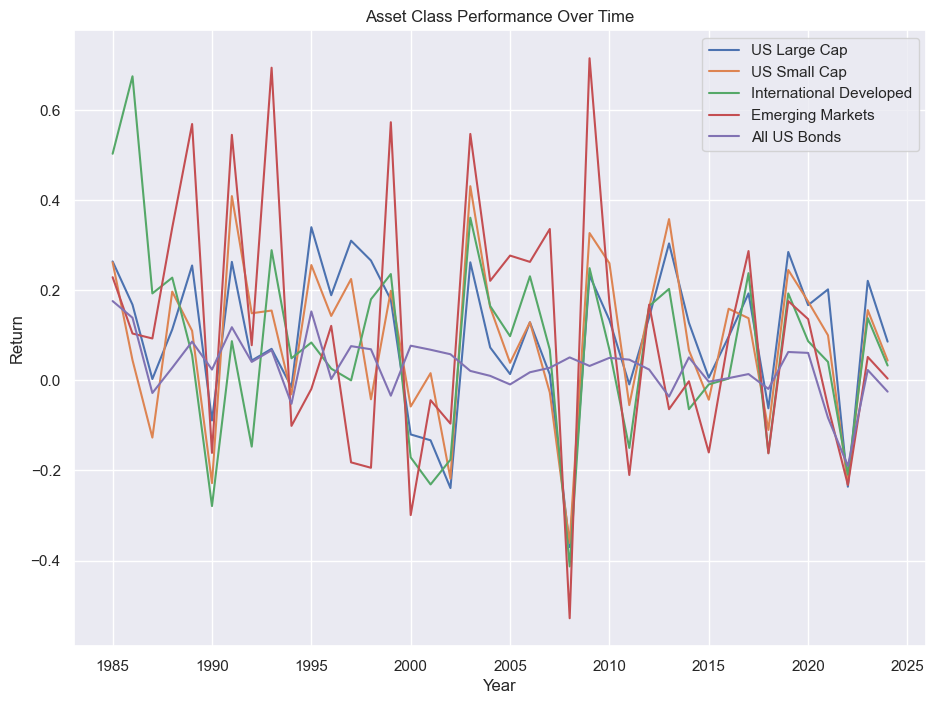

In [178]:
# Plot trends for key asset classes
plt.plot(df['year'], df['uslc'], label='US Large Cap')
plt.plot(df['year'], df['ussc'], label='US Small Cap')
plt.plot(df['year'], df['intd'], label='International Developed')
plt.plot(df['year'], df['em'], label='Emerging Markets')
plt.plot(df['year'], df['All US Bonds'], label='All US Bonds')


plt.title('Asset Class Performance Over Time')
plt.xlabel('Year')
plt.ylabel('Return')
plt.legend()
plt.grid(True)

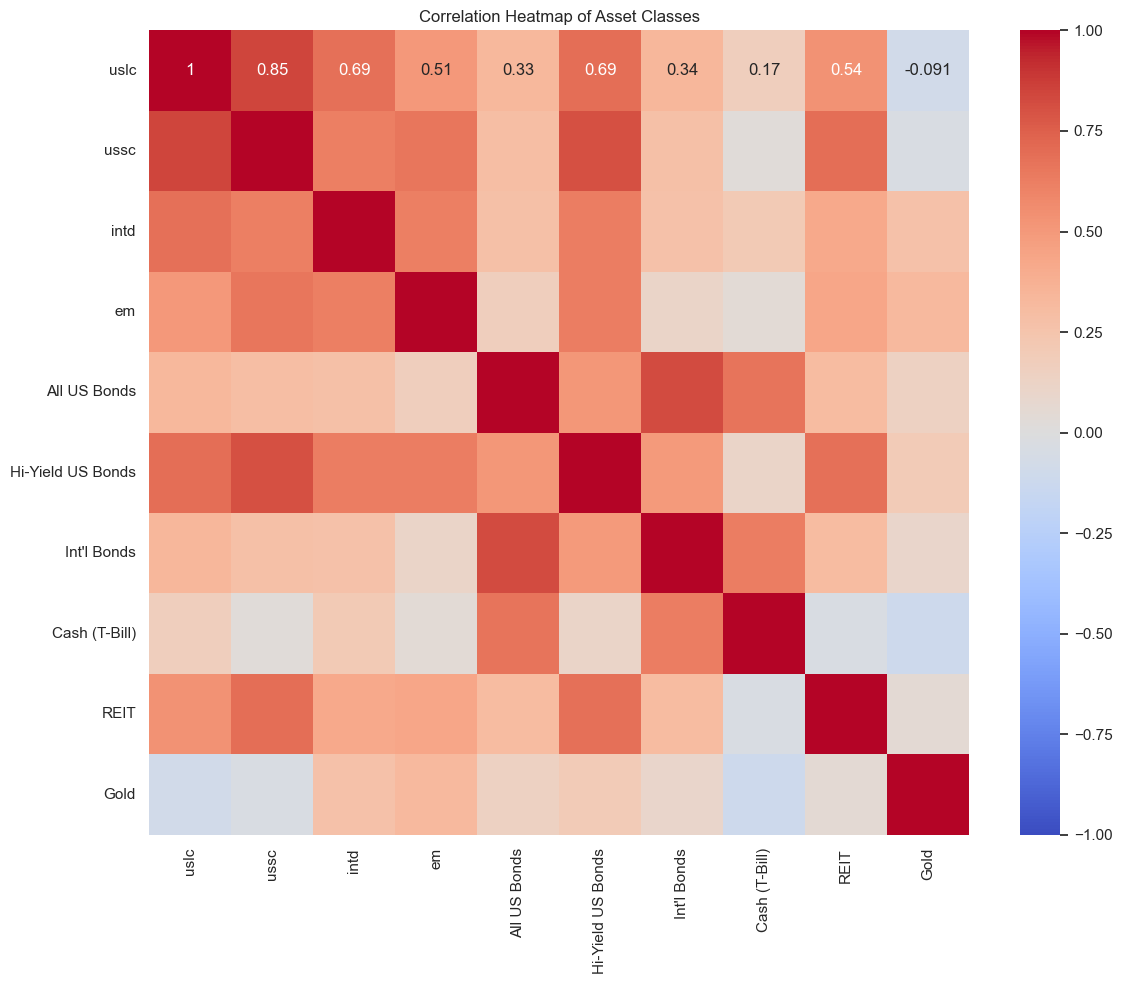

In [180]:
# Calculate correlation matrix
correlation_matrix = df[percentage_columns].corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap of Asset Classes')
plt.tight_layout()
plt.show()

In [200]:
# Convert 'year' to datetime
df['year'] = pd.to_datetime(df['year'], format='%Y')

Next I will run linear regression models for each of the equity asset classes.

In [201]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Define the target variable and features
target = 'uslc'
features = df.columns.difference([target, 'year'])

# Split the data into training and testing sets
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Baseline Linear Regression Model')
print('Mean Squared Error:', mse)
print('R-squared:', r2)

Baseline Linear Regression Model
Mean Squared Error: 0.01242671282472718
R-squared: 0.6302955065648597


###### These metrics provide a starting point for evaluating our model's performance. The R-squared value indicates that approximately 63.03% of the variance in the 'US Large Cap' returns can be explained by the model.

In [233]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Define the target variable and features
target1 = 'ussc'
features1 = df.columns.difference([target1, 'year'])

# Split the data into training and testing sets
X = df[features1]
y = df[target1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Baseline Linear Regression Model Small Caps')
print('Mean Squared Error:', mse)
print('R-squared:', r2)

Baseline Linear Regression Model Small Caps
Mean Squared Error: 0.006655960992880117
R-squared: 0.816164849466378


###### These metrics provide a starting point for evaluating our model's performance. The R-squared value indicates that approximately 81.61% of the variance in the 'US Small Cap' returns can be explained by the model.

In [234]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Define the target variable and features
target2 = 'intd'
features2 = df.columns.difference([target2, 'year'])

# Split the data into training and testing sets
X = df[features2]
y = df[target2]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Baseline Linear Regression Model Intenational Developed')
print('Mean Squared Error:', mse)
print('R-squared:', r2)

Baseline Linear Regression Model Intenational Developed
Mean Squared Error: 0.012758269612118242
R-squared: 0.5914244918477911


###### These metrics provide a starting point for evaluating our model's performance. The R-squared value indicates that approximately 59.14% of the variance in the 'International Developed' returns can be explained by the model.

In [235]:
# Define the target variable and features
target3 = 'em'
features3 = df.columns.difference([target3, 'year'])

# Split the data into training and testing sets
X = df[features3]
y = df[target3]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Baseline Linear Regression Model Intenational Developed')
print('Mean Squared Error:', mse)
print('R-squared:', r2)

Baseline Linear Regression Model Intenational Developed
Mean Squared Error: 0.003989049234196045
R-squared: 0.9654864253831231


###### These metrics provide a starting point for evaluating our model's performance. The R-squared value indicates that approximately 95.5% of the variance in the 'International Developed' returns can be explained by the model.

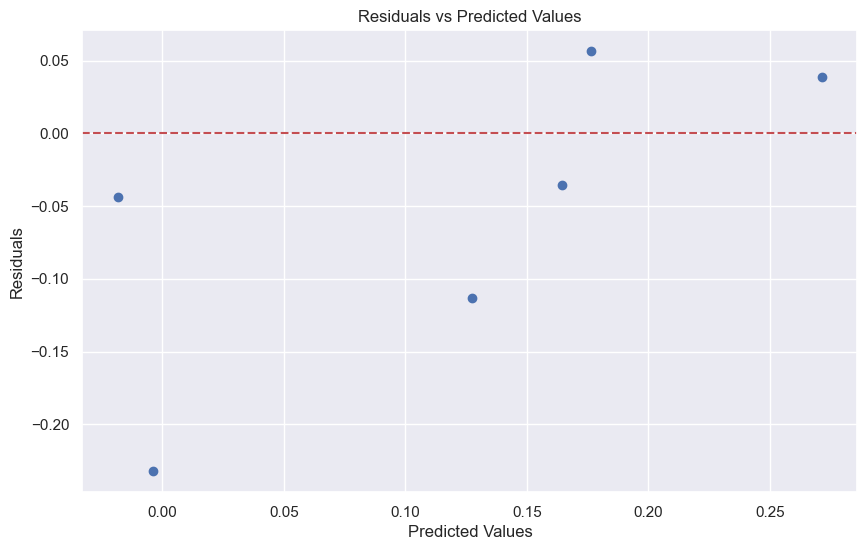

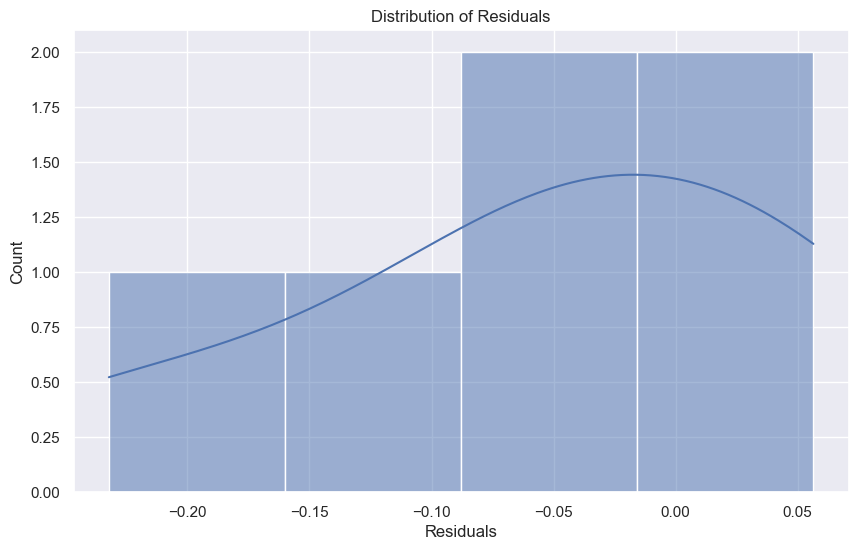

In [202]:
# Analyze the residuals of the baseline linear regression model
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.grid(True)
plt.show()

# Plot distribution of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.grid(True)
plt.show()

**Residuals vs Predicted Values**: This plot helps us check for patterns in the residuals. Ideally, the residuals should be randomly scattered around the horizontal line at zero, indicating that the model's errors are randomly distributed. If there are patterns, it might suggest issues like non-linearity or heteroscedasticity.

**Distribution of Residual**s: This plot shows the distribution of the residuals. Ideally, the residuals should follow a normal distribution centered around zero. Deviations from normality might indicate that the model's assumptions are not fully met.

Next I will perform cross-validation on the linear regression model.

In [208]:
from sklearn.model_selection import cross_val_score

# Initialize the linear regression model
model = LinearRegression()

# Perform k-fold cross-validation (k=5)
k = 5
cv_scores = cross_val_score(model, X, y, cv=k, scoring='neg_mean_squared_error')

# Convert negative MSE to positive
cv_scores = -cv_scores

# Calculate mean and standard deviation of the cross-validation scores
mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)

print('Cross-Validation Results (k=' + str(k) + ')')
print('Mean MSE:', mean_cv_score)
print('Standard Deviation of MSE:', std_cv_score)

Cross-Validation Results (k=5)
Mean MSE: 0.04807971619312132
Standard Deviation of MSE: 0.06237923064402724


These results provide an estimate of the model's performance and its variability across different subsets of the data. The mean MSE gives us an idea of the average error, while the standard deviation indicates the consistency of the model's performance.

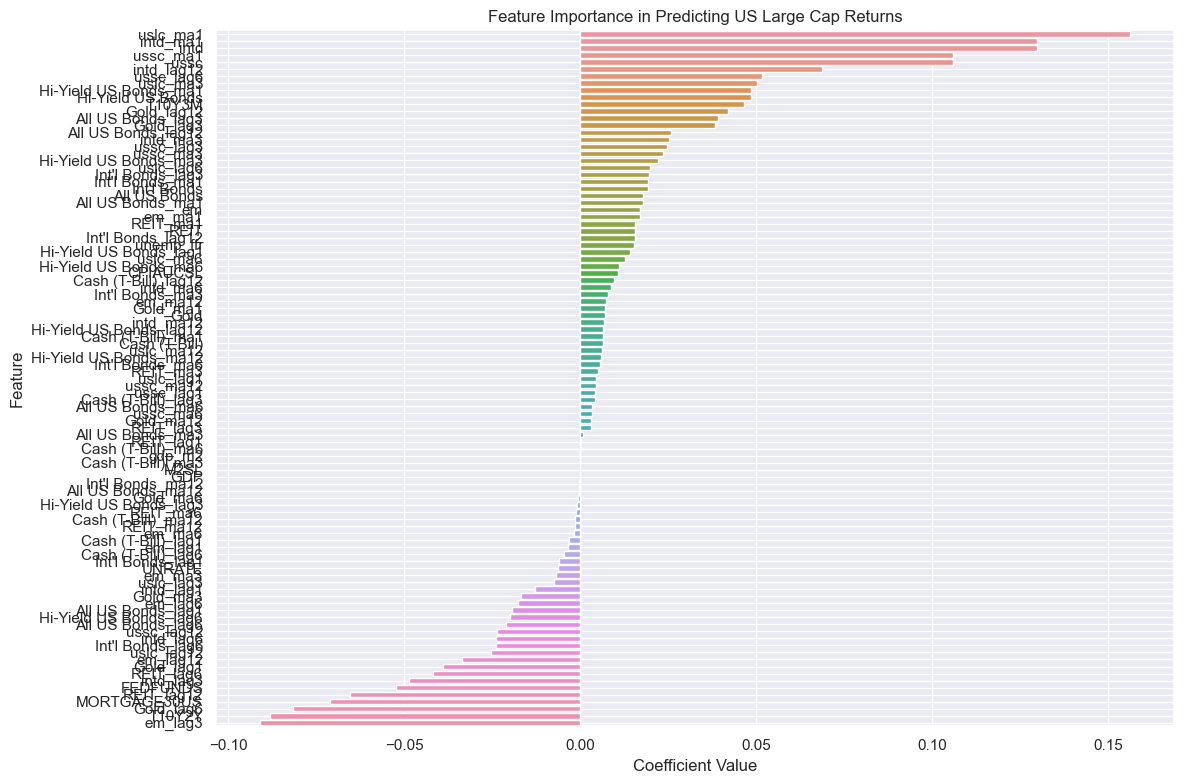

In [218]:
# Define the target variable and features
target = 'uslc'
features = df.columns.difference([target, 'year'])

# Split the data into training and testing sets
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Get feature importance (coefficients)
feature_importance = model.coef_

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance in Predicting US Large Cap Returns')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.grid(True)
plt.tight_layout()
plt.show()

Here we can see which features are the most important in predicting the US large cap stock returns.

To further improve the models as I move forward, I will:

- Explore more advanced algorithms like gradient boosting and neural networks

In [224]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Train a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluation
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Regressor")
print("Mean Squared Error:", mse_rf)
print("R-squared:", r2_rf)

Random Forest Regressor
Mean Squared Error: 0.0050607250999999956
R-squared: 0.8494394426024668


In [225]:
from sklearn.ensemble import GradientBoostingRegressor

# Train a Gradient Boosting Regressor
gbm_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gbm_model.fit(X_train, y_train)

# Predictions
y_pred_gbm = gbm_model.predict(X_test)

# Evaluation
mse_gbm = mean_squared_error(y_test, y_pred_gbm)
r2_gbm = r2_score(y_test, y_pred_gbm)

print("Gradient Boosting Regressor")
print("Mean Squared Error:", mse_gbm)
print("R-squared:", r2_gbm)

Gradient Boosting Regressor
Mean Squared Error: 0.0013626785138788216
R-squared: 0.959459241008124


**Moving forward I will look into using things like lagged variables, time series decomposition, and other techniques to improve the model.**